# 0. Setup

In [161]:
import geopandas as gpd
import os
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from dotenv import load_dotenv
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image
import io
import json
from tqdm import tqdm

`geopandas` documentation: https://geopandas.org/en/stable/

# 1. Loading the wildfires data from Catalunya

In [23]:
gdf = gpd.read_file(os.path.join('catalunya_fire_data', 'clean_data', 'catalunya_fires_cleaned.shp'))
gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84
# Convert date_activ to datetime using pandas
gdf['date_activ'] = pd.to_datetime(
    gdf['date_activ'], 
    format='mixed',  # Some are stored as DD/MM/YY, others as DD/MM/YYYY
    errors='raise'
)
gdf.head()

fire_code                municip date_activ  year  \
0  2014080187                  Tiana 2014-01-26  2014   
1  2014170069                  Roses 2014-10-22  2014   
2  2014250067                    Les 2014-03-17  2014   
3  2014250068  Sant Guim de la Plana 2014-07-17  2014   
4  2014250069                 Oliola 2014-06-21  2014   

                                            geometry  
0  POLYGON ((2.27641 41.49769, 2.27648 41.49766, ...  
1  POLYGON ((3.22466 42.24001, 3.22464 42.24004, ...  
2  MULTIPOLYGON (((0.70981 42.82654, 0.70987 42.8...  
3  POLYGON ((1.35591 41.7573, 1.35595 41.75733, 1...  
4  POLYGON ((1.23054 41.91515, 1.23053 41.91515, ...

# 2. Retrieving satellite images from wildfire locations

Following the retrieval method in https://dl.acm.org/doi/10.1145/3511808.3557528, we retrieve data from "Sentinel-2 L2A and Sentinel-1 GRD missions in a timespan of 2 months given the activation date of each wildfire provided by Copernicus EMS: 1 month prior and 1 month after the activation date."

Documentation for extracting satellite imagery data using the Sentinel Hub (which is what they use in the paper): https://dataspace.copernicus.eu/analyse/apis/sentinel-hub. 
- Relevant documentation for the APIs:
  - Processing API: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html
    - Examples:
      - Requests of Sentinel-1 GRD data: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S1GRD.html
      - Requests of Sentinel-2 L2A data: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S2L2A.html 
    - Customizing the request script: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html
  - Catalogue API: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Catalog.html
- First, need to create an OAuth client: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html#python
  - Install `oauthlib`: https://pypi.org/project/oauthlib/
  - Documentation: https://oauth.net/code/python/
  - Instructions: to access the Processing API, you need to create an OAuth client first through the Copernicus Dashboard:
    1. Go to the Dashboard: https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings
    2. Open the "User Settings" tab
    3. Find the "OAuth clients" section
    4. Click "Create" button
    5. Provide a name for your OAuth client
    6. Set expiry date
    7. Click "Create"
    8. Copy both the client ID and client secret (the secret won't be shown again!). Save them in the `.env` file in this folder.

- Alternative for accessing the data in a visual dashboard: [Copernicus Hub](https://browser.dataspace.copernicus.eu).

## 2.1. Requirements of images to match the images from the paper

- Time frame: "Sentinel-2 L2A and Sentinel-1 GRD missions in a timespan of 2 months given the activation date of each wildfire provided by Copernicus EMS: 1 month prior and 1 month after the activation date." But for fire severity assessment, only post-fire date can be used. As one of the possible tasks with their dataset, the authors suggest "[d]amage severity estimation based on post-wildfire imagery only and supervised techniques."
- "We downloaded the satellite imagery with the highest possible resolution, up to a maximum of 5000x5000 pixels".
- "Sentinel-1 data was acquired in IW mode with VV+VH polarisation." 
- "The images within the defined temporal range have been selected to (i) be available for at least the 90% of the desired AoI [Automated Optical Inspection] defined by the delineation, and (ii) cloud coverage must not exceed 10% of the acquisition."

Note, however, that:
- Sentinel-1 (radar data) has data available going back to the [3rd April 2014](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1).
- Sentinel-2 data is available from the [23rd June 2015 onwards](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2).

## 2.2. Setting up credentials

In [125]:
load_dotenv()  # Load environment variables from .env file

# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

b'[]'


`requests-oauthlib` doesn't check for status before checking if the response is ok. In case there's a server error, the user can receive an incorrect error, which falsely makes it seem as if the issue is on client side. Library's compliance hooks will prevent the invalid status response from being ignored, returning the correct error. To use them, add the following code:

## 2.3. Requests of necessary data



### Utilities

Request parameters:
- Request parameters for Sentinel-1 GRD: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S1GRD.html
- Request parameters for Sentinel-2 L2A: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html

About resolution:
- How to get images in higher resolution: https://documentation.dataspace.copernicus.eu/FAQ.html#how-can-i-get-images-in-higher-resolution
- Example of Processing API and setting higher resolution: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S2L1C.html#true-color-resolution-epsg-32633
- Available resolution for different bands: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L1C.html#available-bands-and-data. B02 (blue), B03 (green) and B04 (red) offer a resolution of 10m.

In [ ]:
def get_first_suitable_sentinel1_image(x_min, y_min, x_max, y_max, from_date_iso, to_date_iso, oauth, ):
    """
    Get the first Sentinel-1 GRD image in the date range with IW mode and VV+VH polarization
    
    Args:
      x_min: Minimum longitude of the bounding box
      y_min: Minimum latitude of the bounding box
      x_max: Maximum longitude of the bounding box
      y_max: Maximum latitude of the bounding box
      from_date_iso: Start date in ISO format
      to_date_iso: End date in ISO format
      oauth: Authenticated OAuth session
    
    Returns:
      image_array: numpy array of the image
      metadata: dictionary with scene metadata
    """

    # Step 1: Query catalog for available Sentinel-1 scenes
    catalog_request = {
        "bbox": [x_min, y_min, x_max, y_max],
        "datetime": f"{from_date_iso}/{to_date_iso}",
        "collections": ["sentinel-1-grd"],
        "limit": 100
    }
    
    catalog_url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"
    catalog_response = oauth.post(catalog_url, json=catalog_request)
    
    if catalog_response.status_code != 200:
        print(f"Catalog request failed: {catalog_response.status_code}")
        print(catalog_response.text)
        return None, None
    
    catalog_data = catalog_response.json()
    features = catalog_data.get('features', [])
    
    if not features:
        print("No Sentinel-1 scenes found in the specified date range and location!")
        return None, None
    
    # Step 2: Filter scenes for IW mode and dual polarization (VV+VH)
    suitable_scenes = []
    for feature in features:
        properties = feature['properties']
        
        # Check for IW (Interferometric Wide) mode and dual polarization
        sensor_mode = properties.get('sar:instrument_mode', '').upper()
        polarizations = properties.get('sar:polarizations', [])
        
        # Filter for IW mode with VV+VH polarization
        has_vv = 'VV' in polarizations
        has_vh = 'VH' in polarizations
        is_iw_mode = sensor_mode == 'IW'
        
        if is_iw_mode and has_vv and has_vh:
            suitable_scenes.append({
                'feature': feature,
                'id': feature['id'],
                'datetime': properties['datetime'],
                'platform': properties.get('platform', 'Unknown'),
                'sensor_mode': sensor_mode,
                'polarizations': polarizations,
                'orbit_direction': properties.get('sat:orbit_state', 'Unknown')
            })
    
    if not suitable_scenes:
        print("No suitable Sentinel-1 scenes found with IW mode and required polarization!")
        print("Available scenes (first 5):")
        for feature in features[:5]:
            properties = feature['properties']
            print(f"  Date: {properties['datetime']}")
            print(f"  Mode: {properties.get('sar:instrument_mode', 'N/A')}")
            print(f"  Polarizations: {properties.get('sar:polarizations', 'N/A')}")
            print(f"  Platform: {properties.get('platform', 'N/A')}")
            print("  ---")
        return None, None
    
    # Step 3: Sort suitable scenes by date (earliest first)
    suitable_scenes.sort(key=lambda x: x['datetime'])
    
    # Step 4: Select the first suitable scene
    selected_scene = suitable_scenes[0]
    print(f"Selected Sentinel-1 scene: {selected_scene['id']}")
    print(f"Date: {selected_scene['datetime']}")
    print(f"Platform: {selected_scene['platform']}")
    print(f"Sensor mode: {selected_scene['sensor_mode']}")
    print(f"Polarizations: {selected_scene['polarizations']}")
    print(f"Orbit direction: {selected_scene['orbit_direction']}")
    
    # Step 5: Define evalscript based on output format
    evalscript = """
    //VERSION=3
    function setup() {
    return {
        input: ["VV", "VH"],
        output: { id: "default", bands: 3 },
    }
    }

    function evaluatePixel(samples) {
    var vvdB = toDb(samples.VV)
    var vhdB = toDb(samples.VH)
    return [vvdB, vhdB, vvdB / vhdB / 10]
    }

    // displays VV in decibels from -20 to 0

    function toDb(linear) {
    // the following commented out lines are simplified below
    // var log = 10 * Math.log(linear) / Math.LN10
    // var val = Math.max(0, (log + 20) / 20)
    return Math.max(0, Math.log(linear) * 0.21714724095 + 1)
    }
    """
    
    # Step 6: Create processing request
    scene_date = selected_scene['datetime']
    scene_date_only = scene_date.split('T')[0]
    
    # Calculate bounding box dimensions and output size
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    aspect_ratio = bbox_width / bbox_height

    # Set maximum dimension to 2500 pixels while maintaining aspect ratio
    max_pixels = 2500
    if aspect_ratio >= 1:
        output_width = max_pixels
        output_height = int(max_pixels / aspect_ratio)
    else:
        output_height = max_pixels
        output_width = int(max_pixels * aspect_ratio)

    print(f"Bounding box aspect ratio: {aspect_ratio:.3f}")
    print(f"Output dimensions: {output_width}x{output_height}")

    request = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
                "bbox": [x_min, y_min, x_max, y_max],
            },
            "data": [
                {
                    "type": "sentinel-1-grd",
                    "dataFilter": {
                        "timeRange": {
                            "from": f"{scene_date_only}T00:00:00Z",
                            "to": f"{scene_date_only}T23:59:59Z",
                        },
                        "acquisitionMode": "IW",
                        "polarization": "DV"  # Dual VV+VH
                    },
                    "processing": {
                        "orthorectify": True,
                        "backCoeff": "GAMMA0_TERRAIN"  # Gamma-0 terrain corrected
                    }
                }
            ],
        },
        "output": {
            "width": output_width,
            "height": output_height,
        },
        "evalscript": evalscript,
    }
    
    # Step 7: Make the processing request
    print(f"Processing Sentinel-1 image ({output_width}x{output_height})...")
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    response = oauth.post(url, json=request)
    
    if response.status_code != 200:
        print(f"Processing failed with status code {response.status_code}")
        print(response.text)
        return None, None
    
    # Step 8: Process the response
    print("Processing successful! Converting image...")
    image_data = response.content
    image = Image.open(io.BytesIO(image_data))
    image_array = np.array(image)
    
    # Step 9: Create metadata dictionary
    metadata = {
        'scene_id': selected_scene['id'],
        'datetime': selected_scene['datetime'],
        'platform': selected_scene['platform'],
        'sensor_mode': selected_scene['sensor_mode'],
        'polarizations': selected_scene['polarizations'],
        'orbit_direction': selected_scene['orbit_direction'],
        'bbox': [x_min, y_min, x_max, y_max],
        'resolution': f'{output_width}x{output_height}',
        'aspect_ratio': aspect_ratio,
        'bbox_width_deg': bbox_width,
        'bbox_height_deg': bbox_height,
        'image_shape': image_array.shape,
        'image_dtype': str(image_array.dtype),
        'file_size_bytes': len(image_data),
        'data_type': 'sentinel-1-grd'
    }
    
    return image_array, metadata

In [192]:
def get_first_suitable_sentinel2_image(x_min, y_min, x_max, y_max, from_date_iso, to_date_iso, oauth, max_cloud_cover=10,
                                       target_resolution_m=10, target_image_size=2500):
    """
    Get the first Sentinel-2 image in the date range with cloud coverage ≤ max_cloud_cover
    
    Args:
        x_min, y_min, x_max, y_max: Bounding box coordinates
        from_date_iso, to_date_iso: Date range in ISO format
        oauth: Authenticated OAuth session
        max_cloud_cover: Maximum acceptable cloud coverage percentage (default: 10%)
        target_resolution_m: Target ground resolution in meters (default: 10m, Sentinel-2 native)
        target_image_size: Target output image size in pixels (default: 2500x2500)
    
    Returns:
        image_array: numpy array of the image
        metadata: dictionary with scene metadata
    """

    # Step 1: Query catalog for available scenes
    catalog_request = {
        "bbox": [x_min, y_min, x_max, y_max],
        "datetime": f"{from_date_iso}/{to_date_iso}",
        "collections": ["sentinel-2-l2a"],
        "limit": 100  # Get more scenes to find suitable ones
    }
    
    catalog_url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"
    catalog_response = oauth.post(catalog_url, json=catalog_request)
    
    if catalog_response.status_code != 200:
        print(f"Catalog request failed: {catalog_response.status_code}")
        print(catalog_response.text)
        return None, None
    
    catalog_data = catalog_response.json()
    features = catalog_data.get('features', [])
    
    if not features:
        print("No scenes found in the specified date range and location!")
        return None, None
    
    # Step 2: Filter scenes by cloud coverage and find the first suitable one
    suitable_scenes = []
    for feature in features:
        properties = feature['properties']
        cloud_cover = properties.get('eo:cloud_cover')
        
        if cloud_cover is not None and cloud_cover <= max_cloud_cover:
            suitable_scenes.append({
                'feature': feature,
                'id': feature['id'],
                'datetime': properties['datetime'],
                'cloud_cover': cloud_cover,
                'platform': properties.get('platform', 'Unknown')
            })
    
    if not suitable_scenes:
        print(f"No scenes found with cloud coverage ≤ {max_cloud_cover}%")
        print("Available scenes:")
        for feature in features[:5]:  # Show first 5 scenes
            properties = feature['properties']
            print(f"  Date: {properties['datetime']}, Cloud: {properties.get('eo:cloud_cover', 'N/A')}%")
        return None, None
    
    # Step 3: Sort suitable scenes by date (earliest first)
    suitable_scenes.sort(key=lambda x: x['datetime'])

    # Step 4: Select the first suitable scene (earliest date)
    selected_scene = suitable_scenes[0]
    print(f"Selected scene: {selected_scene['id']}")
    print(f"Date: {selected_scene['datetime']}")
    print(f"Cloud coverage: {selected_scene['cloud_cover']}%")
    print(f"Platform: {selected_scene['platform']}")
    
    # Step 5: Define evalscript for RGB visualization
    evalscript = """
    //VERSION=3
    function setup() {
      return {
        input: ["B02", "B03", "B04"],
        output: {
          bands: 3,
          sampleType: "AUTO"  // default value - scales the output values from [0,1] to [0,255].
        }
      }
    }

    function evaluatePixel(sample) {
      // Enhanced RGB with slight contrast boost
      return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
    """
    
    # Step 6: Create processing request for 5000x5000 pixels
    scene_date = selected_scene['datetime']
    # Convert to date-only format for precise scene selection
    scene_date_only = scene_date.split('T')[0]  # Extract date part only
    
    # Calculate bounding box dimensions
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    aspect_ratio = bbox_width / bbox_height

    # Ensure both dimensions are at least 512 pixels
    min_size = 512  # Minimum size for training compatibility
    
    if abs(aspect_ratio - 1.0) < 0.1:  # Nearly square
        output_width = target_image_size
        output_height = target_image_size
    elif aspect_ratio >= 1:  # Width > Height
        output_width = target_image_size
        output_height = int(target_image_size / aspect_ratio)
        # Ensure height is at least 512
        if output_height < min_size:
            output_height = min_size
            output_width = int(min_size * aspect_ratio)
    else:  # Height > Width
        output_height = target_image_size
        output_width = int(target_image_size * aspect_ratio)
        # Ensure width is at least 512
        if output_width < min_size:
            output_width = min_size
            output_height = int(min_size / aspect_ratio)

    # Final safety check - ensure both dimensions are at least 512
    output_width = max(output_width, min_size)
    output_height = max(output_height, min_size)

    print(f"Bounding box: {bbox_width:.6f}° x {bbox_height:.6f}°")
    print(f"Aspect ratio: {aspect_ratio:.3f}")
    print(f"Output dimensions: {output_width}x{output_height}")

    request = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
                "bbox": [x_min, y_min, x_max, y_max],
            },
            "data": [
                {
                    "type": "sentinel-2-l2a",
                    "dataFilter": {
                        "timeRange": {
                            "from": f"{scene_date_only}T00:00:00Z",
                            "to": f"{scene_date_only}T23:59:59Z",
                        }
                    },
                    "processing": {
                        "upsampling": "BILINEAR"  # Use bilinear upsampling for better quality
                    }
                }
            ],
        },
        "output": {
            "width": output_width,  # Maximum resolution available
            "height": output_height,  # Maximum resolution available
            # "resx": 1500,
            # "resy": 1500
        },
        "evalscript": evalscript,
    }
    
    # Step 7: Make the processing request
    print(f"Processing high-resolution image ({output_width}x{output_height})...")
    url = "https://sh.dataspace.copernicus.eu/api/v1/process"
    response = oauth.post(url, json=request)
    
    if response.status_code != 200:
        print(f"Processing failed with status code {response.status_code}")
        print(response.text)
        return None, None
    
    # Step 8: Process the response
    print("Processing successful! Converting image...")
    image_data = response.content
    image = Image.open(io.BytesIO(image_data))
    image_array = np.array(image)
    
    # Step 9: Create metadata dictionary
    metadata = {
        'scene_id': selected_scene['id'],
        'datetime': selected_scene['datetime'],
        'cloud_cover': selected_scene['cloud_cover'],
        'platform': selected_scene['platform'],
        'bbox': [x_min, y_min, x_max, y_max],
        'resolution': f'{output_width}x{output_height}',
        'aspect_ratio': aspect_ratio,
        'bbox_width_deg': bbox_width,
        'bbox_height_deg': bbox_height,
        'image_shape': image_array.shape,
        'image_dtype': str(image_array.dtype),
        'file_size_bytes': len(image_data)
    }
    
    return image_array, metadata

### Example

#### Sample wildfire

In [89]:
sentinel_1_launch_date = datetime.datetime(2014, 4, 3)  # Sentinel-1A launch date (April 3, 2014)
sentinel_2_launch_date = datetime.datetime(2015, 6, 23)  # Sentinel-2A launch date (June 23, 2015)

In [90]:
# Filter to fires with an activation date after both Sentinel launches
gdf_filtered = gdf[gdf['date_activ'] > sentinel_2_launch_date]
first_fire = gdf_filtered.head(1)

first_fire

fire_code municip date_activ  year  \
11  2015080225  ÃDENA 2015-07-26  2015   

                                             geometry  
11  MULTIPOLYGON (((1.66951 41.63021, 1.66981 41.6...

In [97]:
# Now, get one month later from the first fire's activation date
first_fire_date = first_fire['date_activ'].values[0]
one_month_later = first_fire_date + pd.Timedelta(days=30)

# Create a bounding box around the first fire
bbox = first_fire.geometry.bounds.values[0]
bbox = [bbox[0], bbox[1], bbox[2], bbox[3]]  # [minx, miny, maxx, maxy]

# Print the bounding box and the date one month later
print(f"Bounding Box: {bbox}")
print(f"Date one month later: {one_month_later}")

Bounding Box: [np.float64(1.6632070712764817), np.float64(41.62078229507559), np.float64(1.7591148856231957), np.float64(41.6603653453595)]
Date one month later: 2015-08-25 00:00:00


In [98]:
# Use GeoPandas buffer method for more accurate buffering
# First, reproject to a projected CRS for accurate distance calculations
# Use UTM zone appropriate for Catalunya (UTM Zone 31N, EPSG:25831) - for converting
# degrees to meters
first_fire_projected = first_fire.to_crs(epsg=25831)  # UTM Zone 31N for Catalunya  (see https://epsg.io/map#srs=25831-1149&x=424888.602437&y=4659994.712628&z=4&layer=streets)
bbox_projected = first_fire_projected.geometry.bounds.values[0]

# Calculate buffer distance as 25% of the average of width and height (in meters)
avg_dimension = ((bbox_projected[2] - bbox_projected[0]) + (bbox_projected[3] - bbox_projected[1])) / 2
buffer_distance_meters = avg_dimension * 0.25

# Create buffered geometry in projected CRS
buffered_geometry_projected = first_fire_projected.geometry.buffer(buffer_distance_meters)

# Convert back to WGS84 for use with Sentinel Hub API
buffered_geometry = buffered_geometry_projected.to_crs(epsg=4326)
buffer_bbox = buffered_geometry.bounds.values[0].tolist()

print(f"Original Bounding Box (WGS84): {bbox}")
print(f"Buffered Bounding Box (WGS84): {buffer_bbox}")
print(f"Buffer distance: {buffer_distance_meters:.1f} meters")

Original Bounding Box (WGS84): [np.float64(1.6632070712764817), np.float64(41.62078229507559), np.float64(1.7591148856231957), np.float64(41.6603653453595)]
Buffered Bounding Box (WGS84): [1.6446788063471893, 41.60688083521271, 1.7776460291729006, 41.67426687043064]
Buffer distance: 1543.8 meters


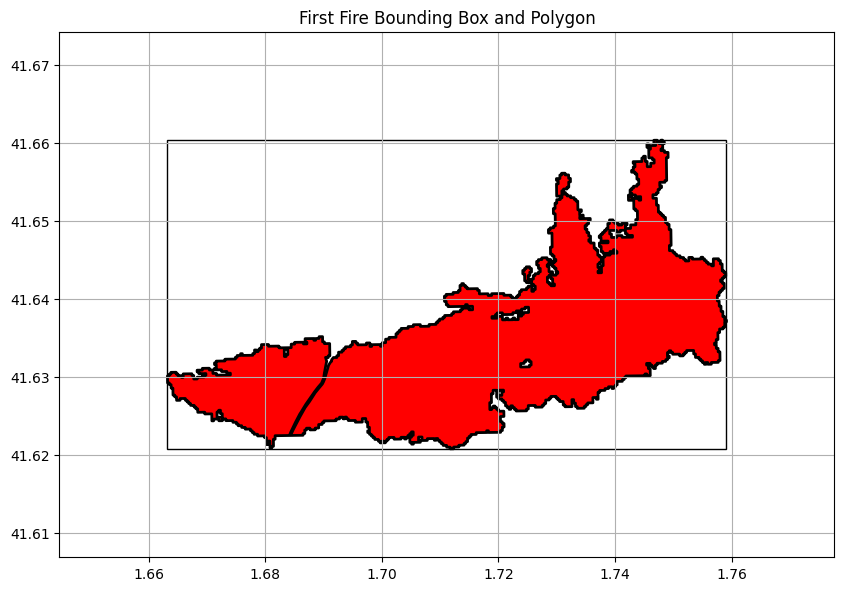

In [99]:
# Display the original and the new bounding box and the polygon of the first fire
fig, ax = plt.subplots(figsize=(10, 10))
first_fire.geometry.plot(ax=ax, color='red', edgecolor='black', linewidth=2)
ax.set_title('First Fire Bounding Box and Polygon')
plt.xlim(buffer_bbox[0], buffer_bbox[2])  # Set x limits to the bounding box
plt.ylim(buffer_bbox[1], buffer_bbox[3])  # Set y limits to the bounding box
# Create a rectangle for the original bounding box
rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='black', facecolor='none', label='Original Bounding Box')
ax.add_patch(rect)
plt.grid(True)
plt.show()

In [135]:
# Get the fire code for the first fire
fire_code = first_fire['fire_code'].values[0]

# Set the bounding box coordinates
x_min = buffer_bbox[0]
x_max = buffer_bbox[2]
y_min = buffer_bbox[1]
y_max = buffer_bbox[3]

# Set the date range for the request (one week before and one week after one month later
# of the fire activation date)
from_date = one_month_later - pd.Timedelta(days=7)
to_date = one_month_later + pd.Timedelta(days=7)

# Convert to ISO 8601 format with Z suffix for UTC timezone
from_date_iso = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
to_date_iso = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')

print(f"From date: {from_date_iso}")
print(f"To date: {to_date_iso}")

From date: 2015-08-18T00:00:00Z
To date: 2015-09-01T00:00:00Z


#### Sentinel-2 L2A data

Now, let's get the data for the Sentinel-2 L2A using their example as the template.

=== SENTINEL-2 IMAGE ACQUISITION PIPELINE ===
Searching for images from 2015-08-18T00:00:00Z to 2015-09-01T00:00:00Z
Bounding box: [1.644679, 41.606881, 1.777646, 41.674267]
Max cloud coverage: 10%

Selected scene: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCG_20231018T041328.SAFE
Date: 2015-08-25T10:59:26.343Z
Cloud coverage: 2.27%
Platform: sentinel-2a
Bounding box aspect ratio: 1.973
Output dimensions: 2500x1266
Processing high-resolution image (2500x1266)...
Processing successful! Converting image...

=== IMAGE SUCCESSFULLY ACQUIRED ===
Scene ID: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCG_20231018T041328.SAFE
Acquisition date: 2015-08-25T10:59:26.343Z
Cloud coverage: 2.27%
Image shape: (1266, 2500, 3)
File size: 2.5 MB


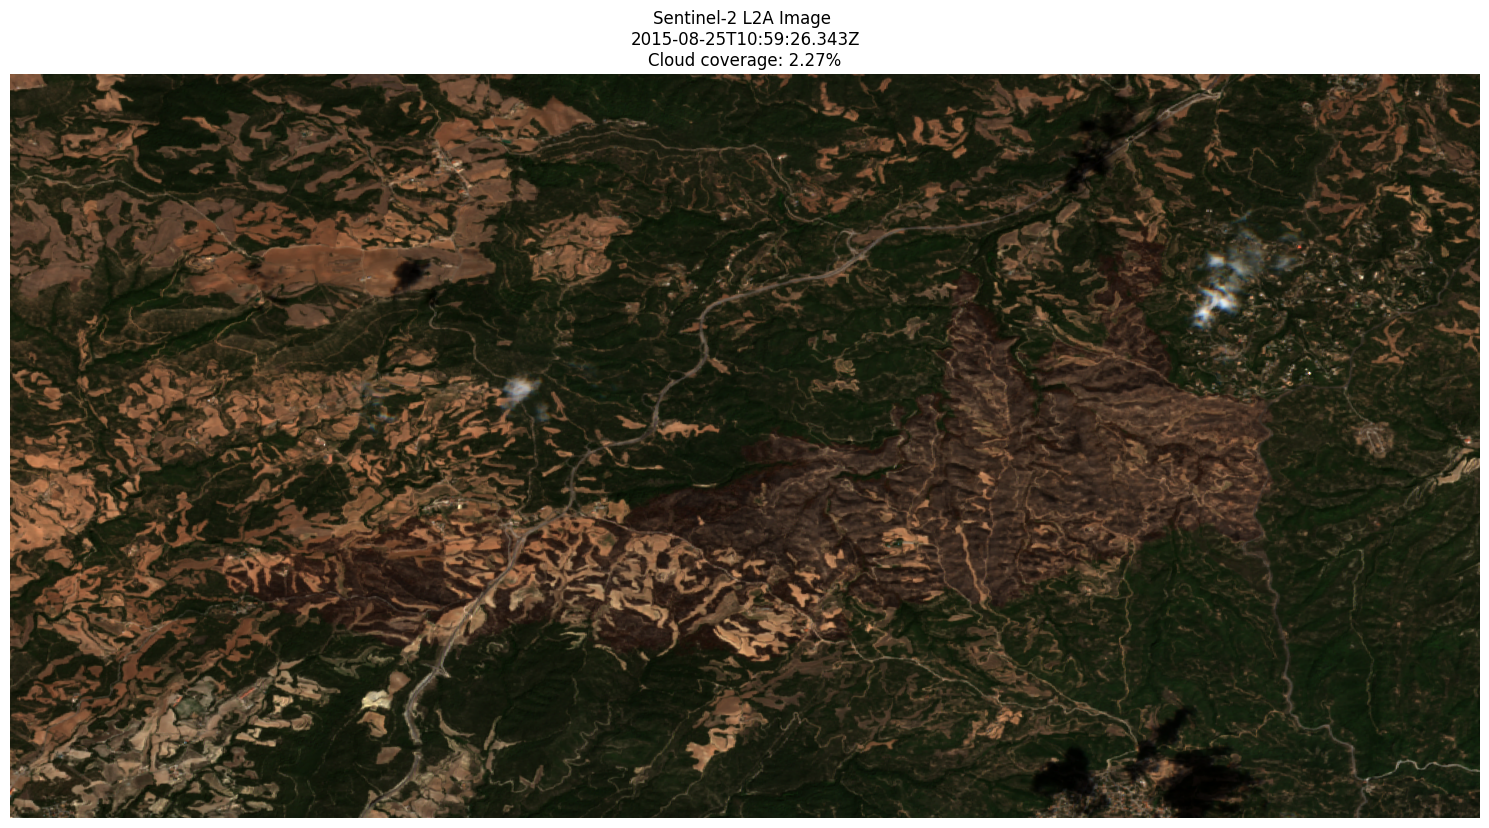


=== IMAGE STATISTICS ===
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 41.73
Standard deviation: 29.81


In [134]:
# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# Execute the pipeline
print("=== SENTINEL-2 IMAGE ACQUISITION PIPELINE ===")
print(f"Searching for images from {from_date_iso} to {to_date_iso}")
print(f"Bounding box: [{x_min:.6f}, {y_min:.6f}, {x_max:.6f}, {y_max:.6f}]")
print(f"Max cloud coverage: 10%")
print()

image_array, metadata = get_first_suitable_sentinel2_image(
    x_min, y_min, x_max, y_max, 
    from_date_iso, to_date_iso, 
    oauth, 
    max_cloud_cover=10
)

if image_array is not None and metadata is not None:
    print("\n=== IMAGE SUCCESSFULLY ACQUIRED ===")
    print(f"Scene ID: {metadata['scene_id']}")
    print(f"Acquisition date: {metadata['datetime']}")
    print(f"Cloud coverage: {metadata['cloud_cover']}%")
    print(f"Image shape: {metadata['image_shape']}")
    print(f"File size: {metadata['file_size_bytes'] / (1024*1024):.1f} MB")
    
    # Display the image
    plt.figure(figsize=(15, 15))
    plt.imshow(image_array)
    plt.title(f'Sentinel-2 L2A Image \n{metadata["datetime"]}\nCloud coverage: {metadata["cloud_cover"]}%')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Save the image and metadata
    scene_id_clean = metadata['scene_id'].replace('/', '_').replace(':', '_').split('SAFE')[0]
    image_filename = f"sentinel2_{scene_id_clean}.png"
    metadata_filename = f"sentinel2_{scene_id_clean}_metadata.json"
    
    # # Save image
    # Image.fromarray(image_array).save(image_filename)
    # print(f"Image saved as: {image_filename}")
    
    # # Save metadata
    # with open(metadata_filename, 'w') as f:
    #     json.dump(metadata, f, indent=2)
    # print(f"Metadata saved as: {metadata_filename}")
    
    # Display some statistics
    print(f"\n=== IMAGE STATISTICS ===")
    print(f"Min pixel value: {image_array.min()}")
    print(f"Max pixel value: {image_array.max()}")
    print(f"Mean pixel value: {image_array.mean():.2f}")
    print(f"Standard deviation: {image_array.std():.2f}")
    
else:
    print("\n=== FAILED TO ACQUIRE IMAGE ===")
    print("No suitable images found with the specified criteria.")
    print("Consider:")
    print("- Increasing the date range")
    print("- Increasing max cloud coverage threshold")
    print("- Checking if the location has Sentinel-2 coverage")

#### Sentinel-1 GDR data

Let's make a request for the first sample wildfire and the Sentinel-1 data.


=== SENTINEL-1 IMAGE ACQUISITION PIPELINE ===
Searching for Sentinel-1 images from 2015-08-18T00:00:00Z to 2015-09-01T00:00:00Z
Bounding box: [1.644679, 41.606881, 1.777646, 41.674267]
Mode: IW with VV+VH polarization

Selected Sentinel-1 scene: S1A_IW_GRDH_1SDV_20150821T060048_20150821T060113_007357_00A1B9_C98C_COG.SAFE
Date: 2015-08-21T06:00:48Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Bounding box aspect ratio: 1.973
Output dimensions: 2500x1266
Processing Sentinel-1 image (2500x1266)...
Processing successful! Converting image...

=== SENTINEL-1 IMAGE SUCCESSFULLY ACQUIRED ===
Scene ID: S1A_IW_GRDH_1SDV_20150821T060048_20150821T060113_007357_00A1B9_C98C_COG.SAFE
Acquisition date: 2015-08-21T06:00:48Z
Platform: sentinel-1a
Sensor mode: IW
Polarizations: ['VV', 'VH']
Orbit direction: descending
Image shape: (1266, 2500, 3)
File size: 3.4 MB


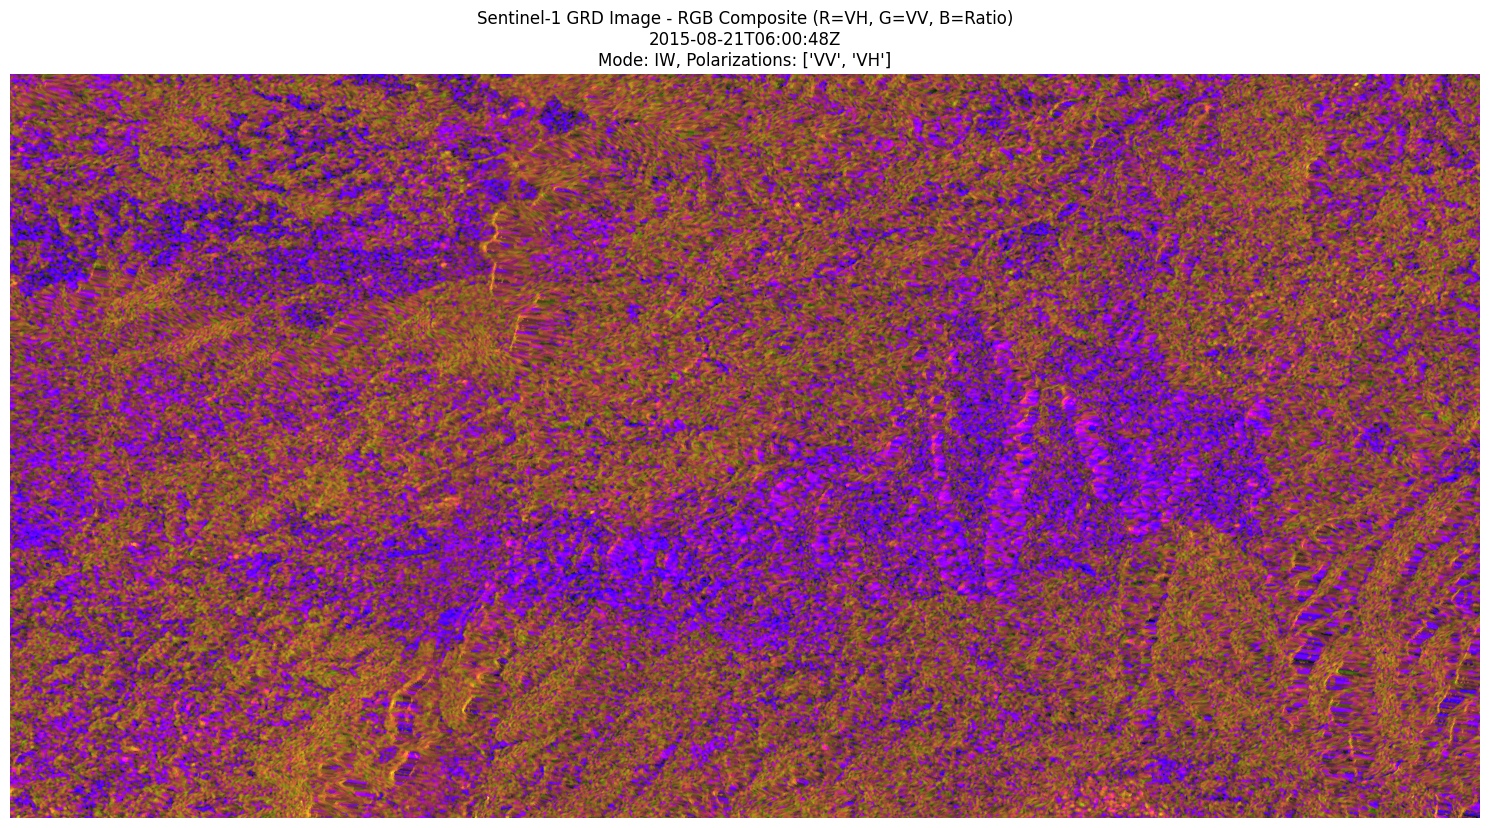


=== SENTINEL-1 IMAGE STATISTICS ===
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 95.06
Standard deviation: 60.56


In [155]:
# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# Usage example for Sentinel-1 data
print("\n=== SENTINEL-1 IMAGE ACQUISITION PIPELINE ===")
print(f"Searching for Sentinel-1 images from {from_date_iso} to {to_date_iso}")
print(f"Bounding box: [{x_min:.6f}, {y_min:.6f}, {x_max:.6f}, {y_max:.6f}]")
print(f"Mode: IW with VV+VH polarization")
print()

# Get Sentinel-1 image
s1_image_array, s1_metadata = get_first_suitable_sentinel1_image(
    x_min, y_min, x_max, y_max, 
    from_date_iso, to_date_iso, 
    oauth
)

if s1_image_array is not None and s1_metadata is not None:
    print("\n=== SENTINEL-1 IMAGE SUCCESSFULLY ACQUIRED ===")
    print(f"Scene ID: {s1_metadata['scene_id']}")
    print(f"Acquisition date: {s1_metadata['datetime']}")
    print(f"Platform: {s1_metadata['platform']}")
    print(f"Sensor mode: {s1_metadata['sensor_mode']}")
    print(f"Polarizations: {s1_metadata['polarizations']}")
    print(f"Orbit direction: {s1_metadata['orbit_direction']}")
    print(f"Image shape: {s1_metadata['image_shape']}")
    print(f"File size: {s1_metadata['file_size_bytes'] / (1024*1024):.1f} MB")
    
    # Display the Sentinel-1 image
    plt.figure(figsize=(15, 15))
    if len(s1_image_array.shape) == 3 and s1_image_array.shape[2] == 3:
        plt.imshow(s1_image_array)
        title_suffix = "RGB Composite (R=VH, G=VV, B=Ratio)"
    else:
        plt.imshow(s1_image_array, cmap='gray')
        title_suffix = f"{s1_metadata['output_format'].upper()} Polarization"
    
    plt.title(f'Sentinel-1 GRD Image - {title_suffix}\n{s1_metadata["datetime"]}\nMode: {s1_metadata["sensor_mode"]}, Polarizations: {s1_metadata["polarizations"]}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Display statistics
    print(f"\n=== SENTINEL-1 IMAGE STATISTICS ===")
    print(f"Min pixel value: {s1_image_array.min()}")
    print(f"Max pixel value: {s1_image_array.max()}")
    print(f"Mean pixel value: {s1_image_array.mean():.2f}")
    print(f"Standard deviation: {s1_image_array.std():.2f}")
    
else:
    print("\n=== FAILED TO ACQUIRE SENTINEL-1 IMAGE ===")
    print("No suitable Sentinel-1 images found with the specified criteria.")
    print("Consider:")
    print("- Increasing the date range")
    print("- Checking if the location has Sentinel-1 coverage")
    print("- Verifying IW mode availability in the region")

### Saving Sentinel-2 images for all fires after S2-L2A launch date

In [188]:
# Calculate the largest dimension of the bounding box in meters for all fires

# First, reproject all fires to UTM Zone 31N for accurate distance calculations
gdf_projected = gdf.to_crs(epsg=25831)  # UTM Zone 31N for Catalunya

# Calculate fire dimensions for all fires
fire_dimensions = []

for index, fire in gdf_projected.iterrows():
    # Get the fire bounds
    bounds = fire.geometry.bounds
    
    # Calculate dimensions in meters
    fire_width_m = bounds[2] - bounds[0]  # maxx - minx
    fire_height_m = bounds[3] - bounds[1]  # maxy - miny
    fire_max_dimension_m = max(fire_width_m, fire_height_m)
    fire_area_m2 = fire.geometry.area
    
    fire_dimensions.append({
        'fire_code': fire['fire_code'],
        'year': fire['year'],
        'date_activ': fire['date_activ'],
        'width_m': fire_width_m,
        'height_m': fire_height_m,
        'max_dimension_m': fire_max_dimension_m,
        'area_m2': fire_area_m2,
        'area_km2': fire_area_m2 / 1_000_000
    })

# Convert to DataFrame for easier analysis
fire_dims_df = pd.DataFrame(fire_dimensions)

# Display statistics
print("=== FIRE DIMENSION STATISTICS ===")
print(f"Total number of fires: {len(fire_dims_df)}")
print(f"\nWidth statistics (meters):")
print(f"  Min: {fire_dims_df['width_m'].min():.1f}m")
print(f"  Max: {fire_dims_df['width_m'].max():.1f}m")
print(f"  Mean: {fire_dims_df['width_m'].mean():.1f}m")
print(f"  Median: {fire_dims_df['width_m'].median():.1f}m")

print(f"\nHeight statistics (meters):")
print(f"  Min: {fire_dims_df['height_m'].min():.1f}m")
print(f"  Max: {fire_dims_df['height_m'].max():.1f}m")
print(f"  Mean: {fire_dims_df['height_m'].mean():.1f}m")
print(f"  Median: {fire_dims_df['height_m'].median():.1f}m")

print(f"\nMaximum dimension statistics (meters):")
print(f"  Min: {fire_dims_df['max_dimension_m'].min():.1f}m")
print(f"  Max: {fire_dims_df['max_dimension_m'].max():.1f}m")
print(f"  Mean: {fire_dims_df['max_dimension_m'].mean():.1f}m")
print(f"  Median: {fire_dims_df['max_dimension_m'].median():.1f}m")
print(f"  75th percentile: {fire_dims_df['max_dimension_m'].quantile(0.75):.1f}m")
print(f"  90th percentile: {fire_dims_df['max_dimension_m'].quantile(0.90):.1f}m")
print(f"  95th percentile: {fire_dims_df['max_dimension_m'].quantile(0.95):.1f}m")
print(f"  99th percentile: {fire_dims_df['max_dimension_m'].quantile(0.99):.1f}m")

print(f"\nArea statistics (km²):")
print(f"  Min: {fire_dims_df['area_km2'].min():.4f} km²")
print(f"  Max: {fire_dims_df['area_km2'].max():.2f} km²")
print(f"  Mean: {fire_dims_df['area_km2'].mean():.3f} km²")
print(f"  Median: {fire_dims_df['area_km2'].median():.4f} km²")

=== FIRE DIMENSION STATISTICS ===
Total number of fires: 211

Width statistics (meters):
  Min: 184.8m
  Max: 12952.0m
  Mean: 1096.1m
  Median: 652.1m

Height statistics (meters):
  Min: 193.7m
  Max: 15960.4m
  Mean: 1217.1m
  Median: 723.9m

Maximum dimension statistics (meters):
  Min: 242.6m
  Max: 15960.4m
  Mean: 1399.3m
  Median: 790.0m
  75th percentile: 1445.7m
  90th percentile: 2805.3m
  95th percentile: 4347.9m
  99th percentile: 8855.9m

Area statistics (km²):
  Min: 0.0242 km²
  Max: 60.81 km²
  Mean: 1.245 km²
  Median: 0.1840 km²


In [207]:
# --- 1. Parameters that can be customized ---

base_output_folder = os.path.join('..', 'catalunya_fire_imgs')  # Custom output folder for images

buffer = 0.25  # Buffer size in in reprojected meters (x% more of the average dimension)

# target_image_size = 1000  # Fixed image size in pixels (if 1000, for example, the covered area will be of 10x10km, if 2500, it will be 25x25km)

# --- 2. Setup ---

load_dotenv()  # Load environment variables from .env file (credentials for Copernicus)

# Load credentials from environment variables
client_id = os.getenv('COPERNICUS_CLIENT_ID')
client_secret = os.getenv('COPERNICUS_CLIENT_SECRET')

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

sentinel_2_launch_date = datetime.datetime(2015, 6, 23)  # Sentinel-2A launch date (June 23, 2015)

# Filter to fires with an activation date after Sentinel-2 launch
gdf_filtered = gdf[gdf['date_activ'] > sentinel_2_launch_date]

# Loop over each fire and get Sentinel-2 images with progress bar
for index, fire in tqdm(gdf_filtered.iterrows(), total=len(gdf_filtered), desc="Processing fires"):
    fire_code = fire['fire_code']  # Get the fire code
    fire_date = fire['date_activ']
    fire_date_str = fire_date.strftime('%Y-%m-%d')  # Format date as string for output
    fire_year = fire['year']
    
    # Create a single-row GeoDataFrame for the current fire
    current_fire = gdf_filtered.loc[[index]]  # Get current fire as GeoDataFrame
    
    # --- 3. Set the bounding box around the fire with a buffer ---

    # Get the current fire's actual bounds in projected coordinates
    current_fire_projected = current_fire.to_crs(epsg=25831)  # UTM Zone 31N for Catalunya
    fire_bounds = current_fire_projected.geometry.bounds.values[0]

    # Calculate fire dimensions in meters
    fire_width_m = fire_bounds[2] - fire_bounds[0]
    fire_height_m = fire_bounds[3] - fire_bounds[1]
    fire_max_dimension_m = max(fire_width_m, fire_height_m)

    print(f"Fire dimensions: {fire_width_m:.0f}m x {fire_height_m:.0f}m")
    print(f"Fire max dimension: {fire_max_dimension_m:.0f}m")

    # Set adaptive extent with buffer
    buffer_factor = 2.0  # Show 2x the fire size (100% buffer around fire)
    target_resolution_m = 10  # Sentinel-2 native resolution in meters

    min_image_size = 512   # Minimum for training compatibility (512x512 tiles)
    max_image_size = 5000  # Maximum for practical limits
    min_extent_m = min_image_size * target_resolution_m  # 5.12km for 512px
    max_extent_m = max_image_size * target_resolution_m  # 50km for 5000px

    # Calculate required extent
    required_extent_m = fire_max_dimension_m * buffer_factor
    extent_meters = max(min_extent_m, min(required_extent_m, max_extent_m))

    print(f"Final extent (after limits): {extent_meters:.0f}m")

    # Calculate corresponding image size to maintain 10m resolution
    target_image_size = int(extent_meters / target_resolution_m)

    # Ensure target_image_size is at least 512 (safety check)
    target_image_size = max(target_image_size, min_image_size)

    print(f"Required extent with buffer: {required_extent_m:.0f}m")
    print(f"Final extent (after constraints): {extent_meters:.0f}m")
    print(f"Target image size: {target_image_size}x{target_image_size} pixels")
    print(f"Actual coverage: {extent_meters/1000:.1f}km x {extent_meters/1000:.1f}km")
    print(f"Actual resolution: {extent_meters/target_image_size:.1f}m/pixel")

    # Get fire centroid and create centered bounding box
    fire_centroid = current_fire.geometry.centroid.iloc[0]
    center_x = fire_centroid.x  # x coordinate of the centroid (longitude)
    center_y = fire_centroid.y  # y coordinate of the centroid (latitude)

    # Convert extent to degrees
    lat_center = center_y
    meters_per_deg_lat = 111320
    meters_per_deg_lon = 111320 * np.cos(np.radians(lat_center))

    extent_deg_lat = extent_meters / meters_per_deg_lat
    extent_deg_lon = extent_meters / meters_per_deg_lon

    half_extent_lat = extent_deg_lat / 2
    half_extent_lon = extent_deg_lon / 2

    buffer_bbox = [
        center_x - half_extent_lon,  # x_min
        center_y - half_extent_lat,  # y_min
        center_x + half_extent_lon,  # x_max
        center_y + half_extent_lat   # y_max
    ]

    print(f"Fire centroid: ({center_x:.6f}, {center_y:.6f})")
    print(f"Centered bounding box: {buffer_bbox}")

    # Set the bounding box coordinates
    x_min = buffer_bbox[0]
    x_max = buffer_bbox[2]
    y_min = buffer_bbox[1]
    y_max = buffer_bbox[3]
        
    # --- 4. Set the date range for the request ---

    # Calculate one month later for THIS fire
    one_month_later = fire_date + pd.Timedelta(days=30)
    
    # Set date range for the request (2 weeks before and after one month later)
    from_date = one_month_later - pd.Timedelta(days=14)
    to_date = one_month_later + pd.Timedelta(days=14)
    
    # Convert to ISO 8601 format with Z suffix for UTC timezone
    from_date_iso = from_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    to_date_iso = to_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # --- 5. Get the Sentinel-2 image and save the results ---

    print(f"Bounding box: {buffer_bbox}")
    print(f"Image size: {target_image_size}x{target_image_size} pixels")

    # Get Sentinel-2 image
    image_array, metadata = get_first_suitable_sentinel2_image(
        x_min, y_min, x_max, y_max, 
        from_date_iso, to_date_iso, 
        oauth, 
        max_cloud_cover=10,
        target_resolution_m=target_resolution_m,
        target_image_size=target_image_size
    )
    
    if image_array is not None and metadata is not None:
        print(f"Scene ID: {metadata['scene_id']}, Date: {metadata['datetime']}, Cloud cover: {metadata['cloud_cover']}%")
        
        # Save the image and metadata
        # Replace '.' with '-' for filenames and keep only 3 decimal places
        longitude = f"{center_x:.3f}".replace('.', '-')
        latitude = f"{center_y:.3f}".replace('.', '-')
        image_filename = f"sentinel2_{fire_date_str}_lon{longitude}_lat{latitude}.tiff"  # Save as TIFF for better quality
        metadata_filename = f"sentinel2_{fire_date_str}_lon{longitude}_lat{latitude}.json"
    
        # Create output folder structure (use base_output_folder to avoid reassignment)
        year_output_folder = os.path.join(base_output_folder, str(fire_year))
        os.makedirs(year_output_folder, exist_ok=True)

        # Folder for images
        imgs_folder = os.path.join(year_output_folder, 'images')
        os.makedirs(imgs_folder, exist_ok=True)

        # Folder for metadata
        metadata_folder = os.path.join(year_output_folder, 'metadata')
        os.makedirs(metadata_folder, exist_ok=True)

        image_path = os.path.join(imgs_folder, image_filename)
        metadata_path = os.path.join(metadata_folder, metadata_filename)

        # Save the image
        Image.fromarray(image_array).save(
            image_path,
            format='TIFF',
            compression='lzw'  # Lossless compression to reduce file size
        )
        print(f"Image saved as: {image_path}")

        # Save metadata (add fire size info)
        metadata['fire_dimensions_m'] = {
            'width_m': fire_width_m,
            'height_m': fire_height_m,
            'max_dimension_m': fire_max_dimension_m,
            'extent_used_m': extent_meters,
            'buffer_factor': buffer_factor
        }
        
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Metadata saved as: {metadata_path}")
    else:
        print(f"Fire {fire_code}: No suitable image found")

Processing fires:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Fire dimensions: 8000m x 4350m
Fire max dimension: 8000m
Final extent (after limits): 16000m
Required extent with buffer: 16000m
Final extent (after constraints): 16000m
Target image size: 1600x1600 pixels
Actual coverage: 16.0km x 16.0km
Actual resolution: 10.0m/pixel
Fire centroid: (1.719290, 41.634612)
Centered bounding box: [np.float64(1.623136174681819), np.float64(41.56274678559037), np.float64(1.8154433557838838), np.float64(41.70647657358894)]
Bounding box: [np.float64(1.623136174681819), np.float64(41.56274678559037), np.float64(1.8154433557838838), np.float64(41.70647657358894)]
Image size: 1600x1600 pixels
Selected scene: S2A_MSIL2A_20150825T105046_N0500_R051_T31TDG_20231018T041328.SAFE
Date: 2015-08-25T10:59:21.821Z
Cloud coverage: 7.21%
Platform: sentinel-2a
Bounding box: 0.192307° x 0.143730°
Aspect ratio: 1.338
Output dimensions: 1600x1195
Processing high-resolution image (1600x1195)...


Processing fires:   1%|          | 1/197 [00:08<29:11,  8.94s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20150825T105046_N0500_R051_T31TDG_20231018T041328.SAFE, Date: 2015-08-25T10:59:21.821Z, Cloud cover: 7.21%
Image saved as: ../catalunya_fire_imgs/2015/images/sentinel2_2015-07-26_lon1-719_lat41-635.tiff
Metadata saved as: ../catalunya_fire_imgs/2015/metadata/sentinel2_2015-07-26_lon1-719_lat41-635.json
Fire dimensions: 602m x 1516m
Fire max dimension: 1516m
Final extent (after limits): 5120m
Required extent with buffer: 3033m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.836754, 41.978945)
Centered bounding box: [np.float64(2.805819301964456), 41.95594800055666, np.float64(2.8676892366376925), 42.0019415327162]
Bounding box: [np.float64(2.805819301964456), 41.95594800055666, np.float64(2.8676892366376925), 42.0019415327162]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date:

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20150802T104026_N0500_R008_T31TEH_20231024T054044.SAFE
Date: 2015-08-02T10:49:11.38Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.062316° x 0.045994°
Aspect ratio: 1.355
Output dimensions: 693x512
Processing high-resolution image (693x512)...


Processing fires:   2%|▏         | 3/197 [00:10<09:50,  3.05s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20150802T104026_N0500_R008_T31TEH_20231024T054044.SAFE, Date: 2015-08-02T10:49:11.38Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2015/images/sentinel2_2015-07-13_lon3-161_lat42-432.tiff
Metadata saved as: ../catalunya_fire_imgs/2015/metadata/sentinel2_2015-07-13_lon3-161_lat42-432.json
Fire dimensions: 650m x 575m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1300m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.707862, 42.825716)
Centered bounding box: [np.float64(0.6765071775609592), 42.80271901815658, np.float64(0.7392178053343306), 42.84871255031612]
Bounding box: [np.float64(0.6765071775609592), 42.80271901815658, np.float64(0.7392178053343306), 42.84871255031612]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCH_202310

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   2%|▏         | 4/197 [00:12<07:59,  2.49s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20150825T105046_N0500_R051_T31TCH_20231018T041328.SAFE, Date: 2015-08-25T10:59:12.047Z, Cloud cover: 0.12%
Image saved as: ../catalunya_fire_imgs/2015/images/sentinel2_2015-08-03_lon0-708_lat42-826.tiff
Metadata saved as: ../catalunya_fire_imgs/2015/metadata/sentinel2_2015-08-03_lon0-708_lat42-826.json
Fire dimensions: 737m x 771m
Fire max dimension: 771m
Final extent (after limits): 5120m
Required extent with buffer: 1542m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.742782, 41.401840)
Centered bounding box: [np.float64(0.7121231125237383), 41.378843545271785, np.float64(0.7734404780282508), 41.42483707743133]
Bounding box: [np.float64(0.7121231125237383), 41.378843545271785, np.float64(0.7734404780282508), 41.42483707743133]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20151203T105422_N0500_R051_T31TCF_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   3%|▎         | 5/197 [00:13<07:04,  2.21s/it]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   4%|▎         | 7/197 [00:14<03:43,  1.17s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20151203T105422_N0500_R051_T31TCF_20231030T224854.SAFE, Date: 2015-12-03T10:59:40.226Z, Cloud cover: 1.55%
Image saved as: ../catalunya_fire_imgs/2015/images/sentinel2_2015-11-05_lon0-743_lat41-402.tiff
Metadata saved as: ../catalunya_fire_imgs/2015/metadata/sentinel2_2015-11-05_lon0-743_lat41-402.json
Fire dimensions: 573m x 721m
Fire max dimension: 721m
Final extent (after limits): 5120m
Required extent with buffer: 1443m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.813675, 41.177941)
Centered bounding box: [np.float64(0.7831214160486109), 41.15494437559198, np.float64(0.8442287100487991), 41.20093790775152]
Bounding box: [np.float64(0.7831214160486109), 41.15494437559198, np.float64(0.8442287100487991), 41.20093790775152]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Dat

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   4%|▍         | 8/197 [00:14<02:49,  1.11it/s]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2015-10-04T10:59:43.282Z, Cloud: 99.29%
  Date: 2015-10-01T10:49:47.605Z, Cloud: 67.66%
  Date: 2015-09-24T10:59:43.86Z, Cloud: 32.56%
  Date: 2015-09-14T10:59:43.407Z, Cloud: 87.29%
Fire 2015430118: No suitable image found
Fire dimensions: 855m x 569m
Fire max dimension: 855m
Final extent (after limits): 5120m
Required extent with buffer: 1709m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.495914, 41.004185)
Centered bounding box: [np.float64(0.4654406695506538), 40.98118871181892, np.float64(0.5263865676038885), 41.027182243978466]
Bounding box: [np.float64(0.4654406695506538), 40.98118871181892, np.float64(0.5263865676038885), 41.027182243978466]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20151203T105422_N0500_R051_T31TBF_20231030T224854.SAFE
Date: 2015-12-03T10:59:44.833Z
Cloud coverage: 1.55%
Plat

Processing fires:   5%|▍         | 9/197 [00:16<03:54,  1.25s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20151203T105422_N0500_R051_T31TBF_20231030T224854.SAFE, Date: 2015-12-03T10:59:44.833Z, Cloud cover: 1.55%
Image saved as: ../catalunya_fire_imgs/2015/images/sentinel2_2015-10-22_lon0-496_lat41-004.tiff
Metadata saved as: ../catalunya_fire_imgs/2015/metadata/sentinel2_2015-10-22_lon0-496_lat41-004.json
Fire dimensions: 770m x 609m
Fire max dimension: 770m
Final extent (after limits): 5120m
Required extent with buffer: 1539m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.470929, 41.229191)
Centered bounding box: [np.float64(1.4403514174163774), 41.206194172268, np.float64(1.501506586610862), 41.25218770442754]
Bounding box: [np.float64(1.4403514174163774), 41.206194172268, np.float64(1.501506586610862), 41.25218770442754]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160627T104022_N0500_R008_T31TCF_20231015T0

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   5%|▌         | 10/197 [00:19<05:04,  1.63s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160627T104022_N0500_R008_T31TCF_20231015T075606.SAFE, Date: 2016-06-27T10:49:46.298Z, Cloud cover: 0.62%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-06-01_lon1-471_lat41-229.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-06-01_lon1-471_lat41-229.json
Fire dimensions: 497m x 458m
Fire max dimension: 497m
Final extent (after limits): 5120m
Required extent with buffer: 994m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.145424, 42.366688)
Centered bounding box: [np.float64(3.1142983219759413), 42.343691070509735, np.float64(3.1765487147936944), 42.38968460266928]
Bounding box: [np.float64(3.1142983219759413), 42.343691070509735, np.float64(3.1765487147936944), 42.38968460266928]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Da

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20160710T105032_N0500_R051_T31TCG_20231027T150945.SAFE
Date: 2016-07-10T10:59:30.248Z
Cloud coverage: 2.7%
Platform: sentinel-2a
Bounding box: 0.061427° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:   6%|▌         | 12/197 [00:21<04:18,  1.40s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160710T105032_N0500_R051_T31TCG_20231027T150945.SAFE, Date: 2016-07-10T10:59:30.248Z, Cloud cover: 2.7%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-06-23_lon1-128_lat41-518.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-06-23_lon1-128_lat41-518.json
Fire dimensions: 354m x 1061m
Fire max dimension: 1061m
Final extent (after limits): 5120m
Required extent with buffer: 2121m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.709446, 41.868864)
Centered bounding box: [np.float64(2.6785642425548986), 41.84586733148042, np.float64(2.740327524721736), 41.89186086363996]
Bounding box: [np.float64(2.6785642425548986), 41.84586733148042, np.float64(2.740327524721736), 41.89186086363996]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   7%|▋         | 13/197 [00:24<05:21,  1.74s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE, Date: 2016-08-26T10:49:28.012Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-19_lon2-709_lat41-869.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-19_lon2-709_lat41-869.json
Fire dimensions: 3660m x 5300m
Fire max dimension: 5300m
Final extent (after limits): 10600m
Required extent with buffer: 10600m
Final extent (after constraints): 10600m
Target image size: 1060x1060 pixels
Actual coverage: 10.6km x 10.6km
Actual resolution: 10.0m/pixel
Fire centroid: (1.121615, 41.539740)
Centered bounding box: [np.float64(1.0580072742654225), np.float64(41.49212923952881), np.float64(1.1852237060508835), np.float64(41.587350224077866)]
Bounding box: [np.float64(1.0580072742654225), np.float64(41.49212923952881), np.float64(1.1852237060508835), np.float64(41.587350224077866)]
Image size: 1060x1060 pixels
Sele

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   7%|▋         | 14/197 [00:28<07:45,  2.54s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160806T104032_N0500_R008_T31TCG_20231002T220245.SAFE, Date: 2016-08-06T10:49:34.007Z, Cloud cover: 4.44%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-19_lon1-122_lat41-540.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-19_lon1-122_lat41-540.json
Fire dimensions: 1030m x 2580m
Fire max dimension: 2580m
Final extent (after limits): 5160m
Required extent with buffer: 5160m
Final extent (after constraints): 5160m
Target image size: 515x515 pixels
Actual coverage: 5.2km x 5.2km
Actual resolution: 10.0m/pixel
Fire centroid: (1.360372, 41.622210)
Centered bounding box: [np.float64(1.3293685358671765), np.float64(41.59903368308055), np.float64(1.3913756727017295), np.float64(41.645386539710074)]
Bounding box: [np.float64(1.3293685358671765), np.float64(41.59903368308055), np.float64(1.3913756727017295), np.float64(41.645386539710074)]
Image size: 515x515 pixels
Selected sce

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   8%|▊         | 15/197 [00:31<07:45,  2.56s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160806T104032_N0500_R008_T31TCG_20231002T220245.SAFE, Date: 2016-08-06T10:49:34.007Z, Cloud cover: 4.44%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-19_lon1-360_lat41-622.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-19_lon1-360_lat41-622.json
Fire dimensions: 1399m x 1597m
Fire max dimension: 1597m
Final extent (after limits): 5120m
Required extent with buffer: 3195m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.016968, 41.928395)
Centered bounding box: [np.float64(1.986057207061335), 41.90539844176218, np.float64(2.0478780923689115), 41.95139197392172]
Bounding box: [np.float64(1.986057207061335), 41.90539844176218, np.float64(2.0478780923689115), 41.95139197392172]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   8%|▊         | 16/197 [00:33<07:30,  2.49s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE, Date: 2016-08-26T10:49:28.012Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-18_lon2-017_lat41-928.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-18_lon2-017_lat41-928.json
Fire dimensions: 502m x 610m
Fire max dimension: 610m
Final extent (after limits): 5120m
Required extent with buffer: 1219m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.798723, 41.320493)
Centered bounding box: [np.float64(1.7681029228170344), 41.297496091447336, np.float64(1.8293436897185), 41.34348962360688]
Bounding box: [np.float64(1.7681029228170344), 41.297496091447336, np.float64(1.8293436897185), 41.34348962360688]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160809T105032_N0500_R051_T31TDF_20231031T

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   9%|▊         | 17/197 [00:36<07:24,  2.47s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160809T105032_N0500_R051_T31TDF_20231031T065139.SAFE, Date: 2016-08-09T10:59:37.097Z, Cloud cover: 0.76%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-22_lon1-799_lat41-320.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-22_lon1-799_lat41-320.json
Fire dimensions: 445m x 442m
Fire max dimension: 445m
Final extent (after limits): 5120m
Required extent with buffer: 890m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.258737, 41.163164)
Centered bounding box: [np.float64(1.228190547343603), 41.1401672256373, np.float64(1.2892840602068745), 41.18616075779684]
Bounding box: [np.float64(1.228190547343603), 41.1401672256373, np.float64(1.2892840602068745), 41.18616075779684]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160809T105032_N0500_R051_T31TCF_20231031T

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:   9%|▉         | 18/197 [00:40<08:58,  3.01s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160809T105032_N0500_R051_T31TCF_20231031T065139.SAFE, Date: 2016-08-09T10:59:44.472Z, Cloud cover: 2.14%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-22_lon1-259_lat41-163.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-22_lon1-259_lat41-163.json
Fire dimensions: 650m x 1650m
Fire max dimension: 1650m
Final extent (after limits): 5120m
Required extent with buffer: 3300m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.778566, 41.711884)
Centered bounding box: [np.float64(2.7477598837702906), 41.68888770678667, np.float64(2.8093721020481053), 41.734881238946215]
Bounding box: [np.float64(2.7477598837702906), 41.68888770678667, np.float64(2.8093721020481053), 41.734881238946215]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE
Date: 2016-08-26T10:49:28.012Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061612° x 0.045994°
Aspect ratio: 1.340
Output dimensions: 685x512
Processing high-resolution image (685x512)...


Processing fires:  10%|▉         | 19/197 [00:44<09:18,  3.14s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160826T104022_N0500_R008_T31TDG_20231001T173730.SAFE, Date: 2016-08-26T10:49:28.012Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-07-24_lon2-779_lat41-712.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-07-24_lon2-779_lat41-712.json
Fire dimensions: 3180m x 3820m
Fire max dimension: 3820m
Final extent (after limits): 7640m
Required extent with buffer: 7640m
Final extent (after constraints): 7640m
Target image size: 764x764 pixels
Actual coverage: 7.6km x 7.6km
Actual resolution: 10.0m/pixel
Fire centroid: (1.412855, 41.212608)
Centered bounding box: [np.float64(1.3672390236417027), np.float64(41.1782928412843), np.float64(1.4584708673960638), np.float64(41.246923815053634)]
Bounding box: [np.float64(1.3672390236417027), np.float64(41.1782928412843), np.float64(1.4584708673960638), np.float64(41.246923815053634)]
Image size: 764x764 pixels
No scenes found

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20160627T104022_N0500_R008_T31TEG_20231015T075606.SAFE
Date: 2016-06-27T10:49:24.368Z
Cloud coverage: 2.09%
Platform: sentinel-2a
Bounding box: 0.069191° x 0.051324°
Aspect ratio: 1.348
Output dimensions: 690x512
Processing high-resolution image (690x512)...


Processing fires:  11%|█         | 21/197 [00:48<07:42,  2.63s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160627T104022_N0500_R008_T31TEG_20231015T075606.SAFE, Date: 2016-06-27T10:49:24.368Z, Cloud cover: 2.09%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-06-08_lon2-992_lat42-118.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-06-08_lon2-992_lat42-118.json
Fire dimensions: 500m x 776m
Fire max dimension: 776m
Final extent (after limits): 5120m
Required extent with buffer: 1551m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.355094, 42.339710)
Centered bounding box: [np.float64(1.3239817756825798), 42.31671318862452, np.float64(1.3862054536893451), 42.36270672078406]
Bounding box: [np.float64(1.3239817756825798), 42.31671318862452, np.float64(1.3862054536893451), 42.36270672078406]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20160607T104032_N0500_R008_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  11%|█         | 22/197 [00:50<07:12,  2.47s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20160607T104032_N0500_R008_T31TCG_20231018T011426.SAFE, Date: 2016-06-07T10:49:34.46Z, Cloud cover: 6.8%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-05-09_lon1-355_lat42-340.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-05-09_lon1-355_lat42-340.json
Fire dimensions: 509m x 806m
Fire max dimension: 806m
Final extent (after limits): 5120m
Required extent with buffer: 1611m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.164605, 41.448330)
Centered bounding box: [np.float64(2.133924269568366), 41.425333560490536, np.float64(2.1952855528243282), 41.47132709265008]
Bounding box: [np.float64(2.133924269568366), 41.425333560490536, np.float64(2.1952855528243282), 41.47132709265008]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20161015T104022_N0500_R008_T31TDG_202310

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  12%|█▏        | 23/197 [00:52<06:57,  2.40s/it]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  12%|█▏        | 24/197 [00:52<05:10,  1.79s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20161015T104022_N0500_R008_T31TDG_20231026T163615.SAFE, Date: 2016-10-15T10:49:22.105Z, Cloud cover: 7.7%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-09-19_lon2-165_lat41-448.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-09-19_lon2-165_lat41-448.json
Fire dimensions: 463m x 685m
Fire max dimension: 685m
Final extent (after limits): 5120m
Required extent with buffer: 1370m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.094649, 41.390505)
Centered bounding box: [np.float64(2.0639951891786956), 41.367508511708444, np.float64(2.125301862458947), 41.413502043867986]
Bounding box: [np.float64(2.0639951891786956), 41.367508511708444, np.float64(2.125301862458947), 41.413502043867986]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Da

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20161117T105322_N0500_R051_T31TCH_20231031T061917.SAFE
Date: 2016-11-17T10:59:11.302Z
Cloud coverage: 2.61%
Platform: sentinel-2a
Bounding box: 0.117109° x 0.086111°
Aspect ratio: 1.360
Output dimensions: 958x704
Processing high-resolution image (958x704)...


Processing fires:  13%|█▎        | 25/197 [00:56<06:42,  2.34s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20161117T105322_N0500_R051_T31TCH_20231031T061917.SAFE, Date: 2016-11-17T10:59:11.302Z, Cloud cover: 2.61%
Image saved as: ../catalunya_fire_imgs/2016/images/sentinel2_2016-10-29_lon1-129_lat42-667.tiff
Metadata saved as: ../catalunya_fire_imgs/2016/metadata/sentinel2_2016-10-29_lon1-129_lat42-667.json
Fire dimensions: 795m x 287m
Fire max dimension: 795m
Final extent (after limits): 5120m
Required extent with buffer: 1590m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.471107, 40.785161)
Centered bounding box: [np.float64(0.4407351339182274), 40.76216430328192, np.float64(0.501479591470258), 40.80815783544146]
Bounding box: [np.float64(0.4407351339182274), 40.76216430328192, np.float64(0.501479591470258), 40.80815783544146]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170725T105031_N0500_R051_T31TBF_202310

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  13%|█▎        | 26/197 [00:59<07:05,  2.49s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170725T105031_N0500_R051_T31TBF_20231008T201154.SAFE, Date: 2017-07-25T10:59:46.907Z, Cloud cover: 0.19%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-07-03_lon0-471_lat40-785.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-03_lon0-471_lat40-785.json
Fire dimensions: 751m x 908m
Fire max dimension: 908m
Final extent (after limits): 5120m
Required extent with buffer: 1817m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.470938, 41.151514)
Centered bounding box: [np.float64(0.4403971097722913), 41.12851693441343, np.float64(0.5014797648453132), 41.174510466572976]
Bounding box: [np.float64(0.4403971097722913), 41.12851693441343, np.float64(0.5014797648453132), 41.174510466572976]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170610T105029_N0500_R051_T31TBF_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  14%|█▎        | 27/197 [01:01<07:04,  2.50s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TBF_20231111T171414.SAFE, Date: 2017-06-10T10:59:45.155Z, Cloud cover: 9.4%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-05-16_lon0-471_lat41-152.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-16_lon0-471_lat41-152.json
Fire dimensions: 989m x 826m
Fire max dimension: 989m
Final extent (after limits): 5120m
Required extent with buffer: 1979m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.166775, 41.803277)
Centered bounding box: [np.float64(1.135925248209587), 41.78027981052527, np.float64(1.197625268164035), 41.826273342684814]
Bounding box: [np.float64(1.135925248209587), 41.78027981052527, np.float64(1.197625268164035), 41.826273342684814]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_2023100

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  14%|█▍        | 28/197 [01:04<07:14,  2.57s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006T221716.SAFE, Date: 2017-07-02T10:49:29.053Z, Cloud cover: 2.21%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-14_lon1-167_lat41-803.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-14_lon1-167_lat41-803.json
Fire dimensions: 406m x 643m
Fire max dimension: 643m
Final extent (after limits): 5120m
Required extent with buffer: 1286m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.726235, 41.839615)
Centered bounding box: [np.float64(2.6953677897046933), 41.81661856764125, np.float64(2.757102834065939), 41.86261209980079]
Bounding box: [np.float64(2.6953677897046933), 41.81661856764125, np.float64(2.757102834065939), 41.86261209980079]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_202310

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  15%|█▍        | 29/197 [01:07<07:18,  2.61s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T221716.SAFE, Date: 2017-07-02T10:49:25.628Z, Cloud cover: 6.99%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-14_lon2-726_lat41-840.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-14_lon2-726_lat41-840.json
Fire dimensions: 390m x 397m
Fire max dimension: 397m
Final extent (after limits): 5120m
Required extent with buffer: 794m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.368908, 41.644323)
Centered bounding box: [np.float64(2.3381338275160424), 41.62132621588333, np.float64(2.39968139955252), 41.66731974804287]
Bounding box: [np.float64(2.3381338275160424), 41.62132621588333, np.float64(2.39968139955252), 41.66731974804287]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  15%|█▌        | 30/197 [01:10<07:36,  2.73s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TDG_20231006T221716.SAFE, Date: 2017-07-02T10:49:25.628Z, Cloud cover: 6.99%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-15_lon2-369_lat41-644.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-15_lon2-369_lat41-644.json
Fire dimensions: 1471m x 903m
Fire max dimension: 1471m
Final extent (after limits): 5120m
Required extent with buffer: 2942m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.681476, 41.547527)
Centered bounding box: [np.float64(0.6507487654539195), 41.524530305107184, np.float64(0.712204103049288), 41.57052383726673]
Bounding box: [np.float64(0.6507487654539195), 41.524530305107184, np.float64(0.712204103049288), 41.57052383726673]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170705T105031_N0500_R051_T31TCG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  16%|█▌        | 31/197 [01:12<07:16,  2.63s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170705T105031_N0500_R051_T31TCG_20231006T073058.SAFE, Date: 2017-07-05T10:59:26.296Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-17_lon0-681_lat41-548.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-17_lon0-681_lat41-548.json
Fire dimensions: 338m x 644m
Fire max dimension: 644m
Final extent (after limits): 5120m
Required extent with buffer: 1288m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.101054, 41.828664)
Centered bounding box: [np.float64(1.0701915443805496), 41.805667726248245, np.float64(1.131916027186443), 41.85166125840779]
Bounding box: [np.float64(1.0701915443805496), 41.805667726248245, np.float64(1.131916027186443), 41.85166125840779]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170712T104021_N0500_R008_T31TCG_20231

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  16%|█▌        | 32/197 [01:15<07:12,  2.62s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170712T104021_N0500_R008_T31TCG_20231008T134204.SAFE, Date: 2017-07-12T10:49:30.506Z, Cloud cover: 0.46%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-24_lon1-101_lat41-829.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-24_lon1-101_lat41-829.json
Fire dimensions: 1092m x 2805m
Fire max dimension: 2805m
Final extent (after limits): 5611m
Required extent with buffer: 5611m
Final extent (after constraints): 5611m
Target image size: 561x561 pixels
Actual coverage: 5.6km x 5.6km
Actual resolution: 10.0m/pixel
Fire centroid: (1.865389, 41.742574)
Centered bounding box: [np.float64(1.831615050803088), np.float64(41.71737394299305), np.float64(1.8991637702428432), np.float64(41.76777499222054)]
Bounding box: [np.float64(1.831615050803088), np.float64(41.71737394299305), np.float64(1.8991637702428432), np.float64(41.76777499222054)]
Image size: 561x561 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20170712T104021_N0500_R008_T31TDG_20231008T134204.SAFE
Date: 2017-07-12T10:49:27.075Z
Cloud coverage: 4.12%
Platform: sentinel-2a
Bounding box: 0.067549° x 0.050401°
Aspect ratio: 1.340
Output dimensions: 686x512
Processing high-resolution image (686x512)...


Processing fires:  17%|█▋        | 33/197 [01:17<07:11,  2.63s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170712T104021_N0500_R008_T31TDG_20231008T134204.SAFE, Date: 2017-07-12T10:49:27.075Z, Cloud cover: 4.12%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-22_lon1-865_lat41-743.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-22_lon1-865_lat41-743.json
Fire dimensions: 431m x 343m
Fire max dimension: 431m
Final extent (after limits): 5120m
Required extent with buffer: 862m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.862126, 41.518337)
Centered bounding box: [np.float64(1.8314124759245063), 41.495340222960756, np.float64(1.8928400876162819), 41.5413337551203]
Bounding box: [np.float64(1.8314124759245063), 41.495340222960756, np.float64(1.8928400876162819), 41.5413337551203]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20170710T105029_N0500_R051_T31TDF_20231005T080621.SAFE
Date: 2017-07-10T10:59:33.83Z
Cloud coverage: 5.62%
Platform: sentinel-2b
Bounding box: 0.061428° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  17%|█▋        | 34/197 [01:20<07:11,  2.65s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170710T105029_N0500_R051_T31TDF_20231005T080621.SAFE, Date: 2017-07-10T10:59:33.83Z, Cloud cover: 5.62%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-23_lon1-862_lat41-518.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-23_lon1-862_lat41-518.json
Fire dimensions: 396m x 314m
Fire max dimension: 396m
Final extent (after limits): 5120m
Required extent with buffer: 791m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.192647, 41.958614)
Centered bounding box: [np.float64(1.1617217535359372), 41.935617551434106, np.float64(1.223571945978795), 41.98161108359365]
Bounding box: [np.float64(1.1617217535359372), 41.935617551434106, np.float64(1.223571945978795), 41.98161108359365]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170715T105031_N0500_R051_T31TCG_202310

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  18%|█▊        | 35/197 [01:22<07:03,  2.61s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170715T105031_N0500_R051_T31TCG_20231007T070334.SAFE, Date: 2017-07-15T10:59:27.575Z, Cloud cover: 5.2%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-28_lon1-193_lat41-959.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-28_lon1-193_lat41-959.json
Fire dimensions: 494m x 390m
Fire max dimension: 494m
Final extent (after limits): 5120m
Required extent with buffer: 988m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.231924, 41.484774)
Centered bounding box: [np.float64(2.2012258393176647), 41.46177719991707, np.float64(2.262621622101489), 41.507770732076615]
Bounding box: [np.float64(2.2012258393176647), 41.46177719991707, np.float64(2.262621622101489), 41.507770732076615]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170329T104019_N0500_R008_T31TDG_202311

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  18%|█▊        | 36/197 [01:25<07:01,  2.62s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170329T104019_N0500_R008_T31TDG_20231114T095646.SAFE, Date: 2017-03-29T10:49:23.006Z, Cloud cover: 1.16%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-03-07_lon2-232_lat41-485.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-03-07_lon2-232_lat41-485.json
Fire dimensions: 463m x 1598m
Fire max dimension: 1598m
Final extent (after limits): 5120m
Required extent with buffer: 3196m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.405174, 41.711383)
Centered bounding box: [np.float64(1.3743683418805375), 41.688385895480394, np.float64(1.4359800791835144), 41.73437942763994]
Bounding box: [np.float64(1.3743683418805375), 41.688385895480394, np.float64(1.4359800791835144), 41.73437942763994]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170428T104019_N0500_R008_T31TCG_

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  19%|█▉        | 37/197 [01:27<06:47,  2.54s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170428T104019_N0500_R008_T31TCG_20231113T140830.SAFE, Date: 2017-04-28T10:49:26.683Z, Cloud cover: 1.9%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-04-07_lon1-405_lat41-711.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-04-07_lon1-405_lat41-711.json
Fire dimensions: 773m x 2237m
Fire max dimension: 2237m
Final extent (after limits): 5120m
Required extent with buffer: 4474m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.971922, 41.846979)
Centered bounding box: [np.float64(1.941051159651015), 41.823982466377224, np.float64(2.002793309436502), 41.869975998536766]
Bounding box: [np.float64(1.941051159651015), 41.823982466377224, np.float64(2.002793309436502), 41.869975998536766]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  19%|█▉        | 38/197 [01:31<07:22,  2.79s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_20231111T171414.SAFE, Date: 2017-06-10T10:59:22.008Z, Cloud cover: 7.84%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-05-07_lon1-972_lat41-847.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-07_lon1-972_lat41-847.json
Fire dimensions: 1025m x 1594m
Fire max dimension: 1594m
Final extent (after limits): 5120m
Required extent with buffer: 3188m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.581187, 40.772222)
Centered bounding box: [np.float64(0.5508203196066542), 40.749225453034086, np.float64(0.6115529464529615), 40.79521898519363]
Bounding box: [np.float64(0.5508203196066542), 40.749225453034086, np.float64(0.6115529464529615), 40.79521898519363]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170225T105021_N0500_R051_T31TBF

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  20%|█▉        | 39/197 [01:34<07:19,  2.78s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170225T105021_N0500_R051_T31TBF_20231017T181750.SAFE, Date: 2017-02-25T10:59:39.271Z, Cloud cover: 1.59%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-01-19_lon0-581_lat40-772.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-01-19_lon0-581_lat40-772.json
Fire dimensions: 2957m x 891m
Fire max dimension: 2957m
Final extent (after limits): 5914m
Required extent with buffer: 5914m
Final extent (after constraints): 5914m
Target image size: 591x591 pixels
Actual coverage: 5.9km x 5.9km
Actual resolution: 10.0m/pixel
Fire centroid: (1.128538, 41.883586)
Centered bounding box: [np.float64(1.0928611216123394), np.float64(41.8570243406807), np.float64(1.1642145762035074), np.float64(41.91014719012376)]
Bounding box: [np.float64(1.0928611216123394), np.float64(41.8570243406807), np.float64(1.1642145762035074), np.float64(41.91014719012376)]
Image size: 591x591 pixels
Selected scene: S

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  20%|██        | 40/197 [01:36<07:04,  2.70s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917T182935.SAFE, Date: 2017-09-05T10:49:23.456Z, Cloud cover: 9.46%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-07_lon1-129_lat41-884.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-07_lon1-129_lat41-884.json
Fire dimensions: 786m x 474m
Fire max dimension: 786m
Final extent (after limits): 5120m
Required extent with buffer: 1572m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.376269, 41.882165)
Centered bounding box: [np.float64(1.3453812973256902), 41.8591686426928, np.float64(1.407157434928951), 41.90516217485234]
Bounding box: [np.float64(1.3453812973256902), 41.8591686426928, np.float64(1.407157434928951), 41.90516217485234]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  21%|██        | 41/197 [01:38<06:42,  2.58s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170905T104019_N0500_R008_T31TCG_20230917T182935.SAFE, Date: 2017-09-05T10:49:23.456Z, Cloud cover: 9.46%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-07_lon1-376_lat41-882.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-07_lon1-376_lat41-882.json
Fire dimensions: 468m x 1008m
Fire max dimension: 1008m
Final extent (after limits): 5120m
Required extent with buffer: 2016m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.186019, 41.590132)
Centered bounding box: [np.float64(2.1552714819905447), 41.5671356856639, np.float64(2.2167673614978027), 41.61312921782344]
Bounding box: [np.float64(2.1552714819905447), 41.5671356856639, np.float64(2.2167673614978027), 41.61312921782344]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170428T104019_N0500_R008_T31TDG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  21%|██▏       | 42/197 [01:41<06:33,  2.54s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170428T104019_N0500_R008_T31TDG_20231113T140830.SAFE, Date: 2017-04-28T10:49:23.256Z, Cloud cover: 4.25%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-04-07_lon2-186_lat41-590.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-04-07_lon2-186_lat41-590.json
Fire dimensions: 677m x 728m
Fire max dimension: 728m
Final extent (after limits): 5120m
Required extent with buffer: 1456m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.310395, 41.510176)
Centered bounding box: [np.float64(2.279684890130801), 41.48717902221467, np.float64(2.3411047573142647), 41.53317255437421]
Bounding box: [np.float64(2.279684890130801), 41.48717902221467, np.float64(2.3411047573142647), 41.53317255437421]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170806T104019_N0500_R008_T31TDF_202310

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  22%|██▏       | 43/197 [01:43<06:33,  2.55s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170806T104019_N0500_R008_T31TDF_20231001T024624.SAFE, Date: 2017-08-06T10:49:40.041Z, Cloud cover: 4.36%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-07-18_lon2-310_lat41-510.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-18_lon2-310_lat41-510.json
Fire dimensions: 505m x 356m
Fire max dimension: 505m
Final extent (after limits): 5120m
Required extent with buffer: 1009m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.936791, 41.469242)
Centered bounding box: [np.float64(1.906100903289638), 41.446245639290105, np.float64(1.9674819752759007), 41.49223917144965]
Bounding box: [np.float64(1.906100903289638), 41.446245639290105, np.float64(1.9674819752759007), 41.49223917144965]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20170804T105031_N0500_R051_T31TDG_20231030T220041.SAFE
Date: 2017-08-04T10:59:23.995Z
Cloud coverage: 2.38%
Platform: sentinel-2a
Bounding box: 0.061381° x 0.045994°
Aspect ratio: 1.335
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  22%|██▏       | 44/197 [01:46<06:49,  2.67s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170804T105031_N0500_R051_T31TDG_20231030T220041.SAFE, Date: 2017-08-04T10:59:23.995Z, Cloud cover: 2.38%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-07-18_lon1-937_lat41-469.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-18_lon1-937_lat41-469.json
Fire dimensions: 744m x 632m
Fire max dimension: 744m
Final extent (after limits): 5120m
Required extent with buffer: 1487m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.451683, 41.498640)
Centered bounding box: [np.float64(1.4209782709443575), 41.47564304662822, np.float64(1.4823871966083653), 41.52163657878776]
Bounding box: [np.float64(1.4209782709443575), 41.47564304662822, np.float64(1.4823871966083653), 41.52163657878776]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20170814T105031_N0500_R051_T31TCG_20231004T170509.SAFE
Date: 2017-08-14T10:59:28.392Z
Cloud coverage: 0.3%
Platform: sentinel-2a
Bounding box: 0.061409° x 0.045994°
Aspect ratio: 1.335
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  23%|██▎       | 45/197 [01:49<06:25,  2.54s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170814T105031_N0500_R051_T31TCG_20231004T170509.SAFE, Date: 2017-08-14T10:59:28.392Z, Cloud cover: 0.3%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-07-26_lon1-452_lat41-499.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-26_lon1-452_lat41-499.json
Fire dimensions: 1120m x 1790m
Fire max dimension: 1790m
Final extent (after limits): 5120m
Required extent with buffer: 3580m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.578869, 40.922187)
Centered bounding box: [np.float64(0.5484335626106425), 40.899190502073594, np.float64(0.6093037850392626), 40.94518403423314]
Bounding box: [np.float64(0.5484335626106425), 40.899190502073594, np.float64(0.6093037850392626), 40.94518403423314]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170814T105031_N0500_R051_T31TBF_

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  23%|██▎       | 46/197 [01:51<06:17,  2.50s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170814T105031_N0500_R051_T31TBF_20231004T170509.SAFE, Date: 2017-08-14T10:59:46.969Z, Cloud cover: 0.06%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-07-27_lon0-579_lat40-922.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-07-27_lon0-579_lat40-922.json
Fire dimensions: 810m x 420m
Fire max dimension: 810m
Final extent (after limits): 5120m
Required extent with buffer: 1620m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.122321, 41.517533)
Centered bounding box: [np.float64(1.0916072862260613), 41.49453643277709, np.float64(1.1530341350253268), 41.54052996493663]
Bounding box: [np.float64(1.0916072862260613), 41.49453643277709, np.float64(1.1530341350253268), 41.54052996493663]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170225T105021_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  24%|██▍       | 47/197 [01:53<05:49,  2.33s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170225T105021_N0500_R051_T31TCG_20231017T181750.SAFE, Date: 2017-02-25T10:59:20.716Z, Cloud cover: 1.24%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-02-08_lon1-122_lat41-518.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-02-08_lon1-122_lat41-518.json
Fire dimensions: 512m x 444m
Fire max dimension: 512m
Final extent (after limits): 5120m
Required extent with buffer: 1025m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.916400, 41.764047)
Centered bounding box: [np.float64(1.8855685635306707), 41.741049911670224, np.float64(1.9472308449152584), 41.787043443829766]
Bounding box: [np.float64(1.8855685635306707), 41.741049911670224, np.float64(1.9472308449152584), 41.787043443829766]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  24%|██▍       | 48/197 [01:56<05:59,  2.41s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_20230929T075215.SAFE, Date: 2017-09-08T10:59:19.337Z, Cloud cover: 6.57%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-23_lon1-916_lat41-764.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-23_lon1-916_lat41-764.json
Fire dimensions: 741m x 1029m
Fire max dimension: 1029m
Final extent (after limits): 5120m
Required extent with buffer: 2057m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.179465, 41.630156)
Centered bounding box: [np.float64(1.1486975016185443), 41.60715965643321, np.float64(1.210231546423644), 41.65315318859275]
Bounding box: [np.float64(1.1486975016185443), 41.60715965643321, np.float64(1.210231546423644), 41.65315318859275]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170526T105031_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  25%|██▍       | 49/197 [01:58<06:00,  2.44s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170526T105031_N0500_R051_T31TCG_20231113T160651.SAFE, Date: 2017-05-26T10:59:29.673Z, Cloud cover: 2.29%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-05-08_lon1-179_lat41-630.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-08_lon1-179_lat41-630.json
Fire dimensions: 403m x 650m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1299m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.138287, 41.550099)
Centered bounding box: [np.float64(2.1075579760059857), 41.52710265009616, np.float64(2.169015758882137), 41.5730961822557]
Bounding box: [np.float64(2.1075579760059857), 41.52710265009616, np.float64(2.169015758882137), 41.5730961822557]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170612T104021_N0500_R008_T31TDG_20231009

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  25%|██▌       | 50/197 [02:01<06:14,  2.55s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170612T104021_N0500_R008_T31TDG_20231009T075704.SAFE, Date: 2017-06-12T10:49:27.677Z, Cloud cover: 1.27%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-05-08_lon2-138_lat41-550.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-08_lon2-138_lat41-550.json
Fire dimensions: 420m x 943m
Fire max dimension: 943m
Final extent (after limits): 5120m
Required extent with buffer: 1886m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.106271, 41.985547)
Centered bounding box: [np.float64(1.0753324002838618), 41.96255048312766, np.float64(1.137208750798299), 42.0085440152872]
Bounding box: [np.float64(1.0753324002838618), 41.96255048312766, np.float64(1.137208750798299), 42.0085440152872]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  26%|██▌       | 51/197 [02:02<05:29,  2.25s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170702T104021_N0500_R008_T31TCG_20231006T221716.SAFE, Date: 2017-07-02T10:49:29.053Z, Cloud cover: 2.21%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-06-08_lon1-106_lat41-986.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-06-08_lon1-106_lat41-986.json
Fire dimensions: 3039m x 4364m
Fire max dimension: 4364m
Final extent (after limits): 8728m
Required extent with buffer: 8728m
Final extent (after constraints): 8728m
Target image size: 872x872 pixels
Actual coverage: 8.7km x 8.7km
Actual resolution: 10.0m/pixel
Fire centroid: (1.989568, 41.813156)
Centered bounding box: [np.float64(1.9369726586905769), np.float64(41.773955154325236), np.float64(2.042163122995013), np.float64(41.85235602029721)]
Bounding box: [np.float64(1.9369726586905769), np.float64(41.773955154325236), np.float64(2.042163122995013), np.float64(41.85235602029721)]
Image size: 872x872 pixels
Selected scene

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  26%|██▋       | 52/197 [02:06<06:13,  2.58s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TDG_20231111T171414.SAFE, Date: 2017-06-10T10:59:22.008Z, Cloud cover: 7.84%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-05-08_lon1-990_lat41-813.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-08_lon1-990_lat41-813.json
Fire dimensions: 560m x 578m
Fire max dimension: 578m
Final extent (after limits): 5120m
Required extent with buffer: 1156m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.805294, 42.435926)
Centered bounding box: [np.float64(0.7741340022459523), 42.41292937571859, np.float64(0.8364531265905769), 42.45892290787813]
Bounding box: [np.float64(0.7741340022459523), 42.41292937571859, np.float64(0.8364531265905769), 42.45892290787813]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20170317T105021_N0500_R051_T31TCH_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  27%|██▋       | 53/197 [02:08<06:02,  2.51s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170317T105021_N0500_R051_T31TCH_20231024T132630.SAFE, Date: 2017-03-17T10:59:03.797Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-02-22_lon0-805_lat42-436.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-02-22_lon0-805_lat42-436.json
Fire dimensions: 450m x 194m
Fire max dimension: 450m
Final extent (after limits): 5120m
Required extent with buffer: 899m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.011454, 41.384609)
Centered bounding box: [np.float64(1.9808035964915363), 41.36161204168208, np.float64(2.0421047101131737), 41.40760557384162]
Bounding box: [np.float64(1.9808035964915363), 41.36161204168208, np.float64(2.0421047101131737), 41.40760557384162]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170905T104019_N0500_R008_T31TDF_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  27%|██▋       | 54/197 [02:10<05:38,  2.37s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170905T104019_N0500_R008_T31TDF_20230917T182935.SAFE, Date: 2017-09-05T10:49:34.364Z, Cloud cover: 1.73%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-18_lon2-011_lat41-385.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-18_lon2-011_lat41-385.json
Fire dimensions: 337m x 673m
Fire max dimension: 673m
Final extent (after limits): 5120m
Required extent with buffer: 1346m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.919143, 41.754691)
Centered bounding box: [np.float64(1.8883159714304483), 41.73169374049252, np.float64(1.9499692634041919), 41.77768727265206]
Bounding box: [np.float64(1.8883159714304483), 41.73169374049252, np.float64(1.9499692634041919), 41.77768727265206]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  28%|██▊       | 55/197 [02:13<05:47,  2.45s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170908T105019_N0500_R051_T31TCG_20230929T075215.SAFE, Date: 2017-09-08T10:59:19.337Z, Cloud cover: 6.57%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-22_lon1-919_lat41-755.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-22_lon1-919_lat41-755.json
Fire dimensions: 3526m x 2676m
Fire max dimension: 3526m
Final extent (after limits): 7052m
Required extent with buffer: 7052m
Final extent (after constraints): 7052m
Target image size: 705x705 pixels
Actual coverage: 7.1km x 7.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.844632, 42.714231)
Centered bounding box: [np.float64(0.801523022702962), np.float64(42.68255753694464), np.float64(0.8877400128162133), np.float64(42.74590513665717)]
Bounding box: [np.float64(0.801523022702962), np.float64(42.68255753694464), np.float64(0.8877400128162133), np.float64(42.74590513665717)]
Image size: 705x705 pixels
Selected scene: 

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  28%|██▊       | 56/197 [02:15<05:51,  2.50s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170610T105029_N0500_R051_T31TCH_20231111T171414.SAFE, Date: 2017-06-10T10:59:12.322Z, Cloud cover: 6.45%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-05-01_lon0-845_lat42-714.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-05-01_lon0-845_lat42-714.json
Fire dimensions: 870m x 801m
Fire max dimension: 870m
Final extent (after limits): 5120m
Required extent with buffer: 1739m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.959307, 41.426411)
Centered bounding box: [np.float64(0.9286365777053943), 41.40341388892797, np.float64(0.9899771412241848), 41.449407421087514]
Bounding box: [np.float64(0.9286365777053943), 41.40341388892797, np.float64(0.9899771412241848), 41.449407421087514]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20170913T105021_N0500_R051_T31TCG_20231003T181701.SAFE
Date: 2017-09-13T10:59:24.432Z
Cloud coverage: 0.0%
Platform: sentinel-2a
Bounding box: 0.061341° x 0.045994°
Aspect ratio: 1.334
Output dimensions: 682x512
Processing high-resolution image (682x512)...


Processing fires:  29%|██▉       | 57/197 [02:18<05:45,  2.47s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20170913T105021_N0500_R051_T31TCG_20231003T181701.SAFE, Date: 2017-09-13T10:59:24.432Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-28_lon0-959_lat41-426.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-28_lon0-959_lat41-426.json
Fire dimensions: 379m x 396m
Fire max dimension: 396m
Final extent (after limits): 5120m
Required extent with buffer: 792m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.412047, 41.684447)
Centered bounding box: [np.float64(2.3812542211663468), 41.661450131504424, np.float64(2.4428401590916273), 41.707443663663966]
Bounding box: [np.float64(2.3812542211663468), 41.661450131504424, np.float64(2.4428401590916273), 41.707443663663966]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20171005T104009_N0500_R008_T31TDG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  29%|██▉       | 58/197 [02:20<05:22,  2.32s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20171005T104009_N0500_R008_T31TDG_20231015T095935.SAFE, Date: 2017-10-05T10:49:11.761Z, Cloud cover: 0.08%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-08-29_lon2-412_lat41-684.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-08-29_lon2-412_lat41-684.json
Fire dimensions: 397m x 454m
Fire max dimension: 454m
Final extent (after limits): 5120m
Required extent with buffer: 909m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.601885, 41.369478)
Centered bounding box: [np.float64(1.571241868381972), 41.34648092586461, np.float64(1.6325287227722847), 41.392474458024154]
Bounding box: [np.float64(1.571241868381972), 41.34648092586461, np.float64(1.6325287227722847), 41.392474458024154]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20171005T104009_N0500_R008_T31TCF_20231

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  30%|██▉       | 59/197 [02:22<05:19,  2.32s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20171005T104009_N0500_R008_T31TCF_20231015T095935.SAFE, Date: 2017-10-05T10:49:29.896Z, Cloud cover: 8.65%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-09-14_lon1-602_lat41-369.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-09-14_lon1-602_lat41-369.json
Fire dimensions: 481m x 318m
Fire max dimension: 481m
Final extent (after limits): 5120m
Required extent with buffer: 962m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.241058, 41.797460)
Centered bounding box: [np.float64(1.210210696251622), 41.77446325279337, np.float64(1.2719051160224246), 41.82045678495291]
Bounding box: [np.float64(1.210210696251622), 41.77446325279337, np.float64(1.2719051160224246), 41.82045678495291]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20170329T104019_N0500_R008_T31TCG_2023111

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  30%|███       | 60/197 [02:24<05:19,  2.33s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20170329T104019_N0500_R008_T31TCG_20231114T095646.SAFE, Date: 2017-03-29T10:49:26.443Z, Cloud cover: 1.26%
Image saved as: ../catalunya_fire_imgs/2017/images/sentinel2_2017-03-10_lon1-241_lat41-797.tiff
Metadata saved as: ../catalunya_fire_imgs/2017/metadata/sentinel2_2017-03-10_lon1-241_lat41-797.json
Fire dimensions: 209m x 522m
Fire max dimension: 522m
Final extent (after limits): 5120m
Required extent with buffer: 1043m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.942944, 41.275737)
Centered bounding box: [np.float64(1.9123442974398108), 41.25274067923687, np.float64(1.9735430557463285), 41.298734211396415]
Bounding box: [np.float64(1.9123442974398108), 41.25274067923687, np.float64(1.9735430557463285), 41.298734211396415]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20180118T104351_N0500_R008_T31TDF_20230802T205745.SAFE
Date: 2018-01-18T10:49:34.487Z
Cloud coverage: 2.89%
Platform: sentinel-2a
Bounding box: 0.061199° x 0.045994°
Aspect ratio: 1.331
Output dimensions: 681x512
Processing high-resolution image (681x512)...


Processing fires:  31%|███       | 61/197 [02:27<05:09,  2.28s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180118T104351_N0500_R008_T31TDF_20230802T205745.SAFE, Date: 2018-01-18T10:49:34.487Z, Cloud cover: 2.89%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-01-01_lon1-943_lat41-276.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-01-01_lon1-943_lat41-276.json
Fire dimensions: 827m x 234m
Fire max dimension: 827m
Final extent (after limits): 5120m
Required extent with buffer: 1654m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.731819, 41.844273)
Centered bounding box: [np.float64(0.7009492164969829), 41.821276083841674, np.float64(0.7626887545859459), 41.86726961600122]
Bounding box: [np.float64(0.7009492164969829), 41.821276083841674, np.float64(0.7626887545859459), 41.86726961600122]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180401T105031_N0500_R051_T30TYM_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  31%|███▏      | 62/197 [02:29<05:14,  2.33s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180401T105031_N0500_R051_T30TYM_20230916T085052.SAFE, Date: 2018-04-01T10:59:30.571Z, Cloud cover: 9.76%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-02-20_lon0-732_lat41-844.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-02-20_lon0-732_lat41-844.json
Fire dimensions: 256m x 543m
Fire max dimension: 543m
Final extent (after limits): 5120m
Required extent with buffer: 1087m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.910647, 42.307042)
Centered bounding box: [np.float64(2.8795509496073977), 42.284045472826016, np.float64(2.9417423275777943), 42.33003900498556]
Bounding box: [np.float64(2.8795509496073977), 42.284045472826016, np.float64(2.9417423275777943), 42.33003900498556]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180418T104021_N0500_R008_T31TDG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  32%|███▏      | 63/197 [02:31<05:07,  2.30s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180418T104021_N0500_R008_T31TDG_20230916T194713.SAFE, Date: 2018-04-18T10:49:28.161Z, Cloud cover: 5.11%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-03-22_lon2-911_lat42-307.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-03-22_lon2-911_lat42-307.json
Fire dimensions: 355m x 333m
Fire max dimension: 355m
Final extent (after limits): 5120m
Required extent with buffer: 709m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.125174, 42.350514)
Centered bounding box: [np.float64(3.0940571134401975), 42.32751725125414, np.float64(3.1562914857459394), 42.373510783413685]
Bounding box: [np.float64(3.0940571134401975), 42.32751725125414, np.float64(3.1562914857459394), 42.373510783413685]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20180702T104019_N0500_R008_T31TEH_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  32%|███▏      | 64/197 [02:33<05:01,  2.27s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20180702T104019_N0500_R008_T31TEH_20230803T231723.SAFE, Date: 2018-07-02T10:49:07.54Z, Cloud cover: 5.74%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-06-14_lon3-125_lat42-351.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-06-14_lon3-125_lat42-351.json
Fire dimensions: 829m x 787m
Fire max dimension: 829m
Final extent (after limits): 5120m
Required extent with buffer: 1658m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.008156, 41.582534)
Centered bounding box: [np.float64(0.9774115297732929), 41.55953691754938, np.float64(1.0389001721263844), 41.60553044970892]
Bounding box: [np.float64(0.9774115297732929), 41.55953691754938, np.float64(1.0389001721263844), 41.60553044970892]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180710T105031_N0500_R051_T31TCG_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  33%|███▎      | 65/197 [02:36<05:18,  2.41s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180710T105031_N0500_R051_T31TCG_20230817T151634.SAFE, Date: 2018-07-10T10:59:28.175Z, Cloud cover: 7.32%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-06-20_lon1-008_lat41-583.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-06-20_lon1-008_lat41-583.json
Fire dimensions: 330m x 401m
Fire max dimension: 401m
Final extent (after limits): 5120m
Required extent with buffer: 802m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.233416, 41.718015)
Centered bounding box: [np.float64(1.2026069892133475), 41.695018455415145, np.float64(1.2642250846636842), 41.74101198757469]
Bounding box: [np.float64(1.2026069892133475), 41.695018455415145, np.float64(1.2642250846636842), 41.74101198757469]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20180715T105029_N0500_R051_T31TCG_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  34%|███▎      | 66/197 [02:38<05:05,  2.33s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20180715T105029_N0500_R051_T31TCG_20230821T205551.SAFE, Date: 2018-07-15T10:59:25.495Z, Cloud cover: 1.03%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-06-25_lon1-233_lat41-718.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-06-25_lon1-233_lat41-718.json
Fire dimensions: 771m x 210m
Fire max dimension: 771m
Final extent (after limits): 5120m
Required extent with buffer: 1541m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.241267, 41.668188)
Centered bounding box: [np.float64(1.21048213011594), 41.64519093046948, np.float64(1.272052511834552), 41.691184462629025]
Bounding box: [np.float64(1.21048213011594), 41.64519093046948, np.float64(1.272052511834552), 41.691184462629025]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180128T104311_N0500_R008_T31TCG_20230824

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  34%|███▍      | 67/197 [02:40<04:53,  2.26s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180128T104311_N0500_R008_T31TCG_20230824T202611.SAFE, Date: 2018-01-28T10:49:25.243Z, Cloud cover: 0.05%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-01-07_lon1-241_lat41-668.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-01-07_lon1-241_lat41-668.json
Fire dimensions: 485m x 475m
Fire max dimension: 485m
Final extent (after limits): 5120m
Required extent with buffer: 970m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.324921, 41.826158)
Centered bounding box: [np.float64(1.2940595085573472), 41.80316108475974, np.float64(1.3557815746544408), 41.849154616919286]
Bounding box: [np.float64(1.2940595085573472), 41.80316108475974, np.float64(1.3557815746544408), 41.849154616919286]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20180511T105031_N0500_R051_T31TCG_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  35%|███▍      | 68/197 [02:43<04:59,  2.32s/it]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  35%|███▌      | 69/197 [02:43<03:34,  1.67s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180511T105031_N0500_R051_T31TCG_20230903T152307.SAFE, Date: 2018-05-11T10:59:29.52Z, Cloud cover: 5.46%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-04-07_lon1-325_lat41-826.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-04-07_lon1-325_lat41-826.json
Fire dimensions: 561m x 1051m
Fire max dimension: 1051m
Final extent (after limits): 5120m
Required extent with buffer: 2101m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.998061, 42.114061)
Centered bounding box: [np.float64(2.9670596980876702), 42.091064711743215, np.float64(3.0290613597024265), 42.13705824390276]
Bounding box: [np.float64(2.9670596980876702), 42.091064711743215, np.float64(3.0290613597024265), 42.13705824390276]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20180727T104021_N0500_R008_T31TCF_20230723T045706.SAFE
Date: 2018-07-27T10:49:45.836Z
Cloud coverage: 2.52%
Platform: sentinel-2a
Bounding box: 0.061301° x 0.045994°
Aspect ratio: 1.333
Output dimensions: 682x512
Processing high-resolution image (682x512)...


Processing fires:  36%|███▌      | 70/197 [02:46<04:01,  1.90s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20180727T104021_N0500_R008_T31TCF_20230723T045706.SAFE, Date: 2018-07-27T10:49:45.836Z, Cloud cover: 2.52%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-07-08_lon1-333_lat41-384.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-07-08_lon1-333_lat41-384.json
Fire dimensions: 370m x 554m
Fire max dimension: 554m
Final extent (after limits): 5120m
Required extent with buffer: 1107m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.821907, 41.612865)
Centered bounding box: [np.float64(0.7911484116659495), 41.58986855266347, np.float64(0.8526659588551715), 41.63586208482301]
Bounding box: [np.float64(0.7911484116659495), 41.58986855266347, np.float64(0.8526659588551715), 41.63586208482301]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20180225T105019_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  36%|███▌      | 71/197 [02:47<03:47,  1.81s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20180225T105019_N0500_R051_T31TCG_20230912T104023.SAFE, Date: 2018-02-25T10:59:23.32Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-02-09_lon0-822_lat41-613.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-02-09_lon0-822_lat41-613.json
Fire dimensions: 450m x 414m
Fire max dimension: 450m
Final extent (after limits): 5120m
Required extent with buffer: 899m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.085028, 41.512552)
Centered bounding box: [np.float64(1.054317428248057), 41.48955529936792, np.float64(1.115739550051219), 41.535548831527464]
Bounding box: [np.float64(1.054317428248057), 41.48955529936792, np.float64(1.115739550051219), 41.535548831527464]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20181023T105109_N0500_R051_T31TCG_20230802T095136.SAFE
Date: 2018-10-23T10:59:24.403Z
Cloud coverage: 8.89%
Platform: sentinel-2b
Bounding box: 0.061422° x 0.045994°
Aspect ratio: 1.335
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  37%|███▋      | 72/197 [02:49<04:06,  1.97s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20181023T105109_N0500_R051_T31TCG_20230802T095136.SAFE, Date: 2018-10-23T10:59:24.403Z, Cloud cover: 8.89%
Image saved as: ../catalunya_fire_imgs/2018/images/sentinel2_2018-09-27_lon1-085_lat41-513.tiff
Metadata saved as: ../catalunya_fire_imgs/2018/metadata/sentinel2_2018-09-27_lon1-085_lat41-513.json
Fire dimensions: 493m x 590m
Fire max dimension: 590m
Final extent (after limits): 5120m
Required extent with buffer: 1180m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.714740, 41.734311)
Centered bounding box: [np.float64(1.6839233731181742), 41.71131426643681, np.float64(1.745557099246446), 41.75730779859635]
Bounding box: [np.float64(1.6839233731181742), 41.71131426643681, np.float64(1.745557099246446), 41.75730779859635]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190627T104029_N0500_R008_T31TCG_202306

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  37%|███▋      | 73/197 [02:52<04:30,  2.18s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190627T104029_N0500_R008_T31TCG_20230625T085032.SAFE, Date: 2019-06-27T10:49:38.854Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-07_lon1-715_lat41-734.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-07_lon1-715_lat41-734.json
Fire dimensions: 701m x 1560m
Fire max dimension: 1560m
Final extent (after limits): 5120m
Required extent with buffer: 3120m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.696589, 41.536948)
Centered bounding box: [np.float64(1.6658665438012308), 41.513951392988645, np.float64(1.7273118283902933), 41.55994492514819]
Bounding box: [np.float64(1.6658665438012308), 41.513951392988645, np.float64(1.7273118283902933), 41.55994492514819]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190809T105039_N0500_R051_T31TCG_2

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  38%|███▊      | 74/197 [02:55<04:54,  2.39s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190809T105039_N0500_R051_T31TCG_20230709T203621.SAFE, Date: 2019-08-09T10:59:34.268Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-07-24_lon1-697_lat41-537.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-07-24_lon1-697_lat41-537.json
Fire dimensions: 285m x 556m
Fire max dimension: 556m
Final extent (after limits): 5120m
Required extent with buffer: 1113m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.986021, 42.101725)
Centered bounding box: [np.float64(2.9550263595200232), 42.07872871542981, np.float64(3.017015957048439), 42.124722247589354]
Bounding box: [np.float64(2.9550263595200232), 42.07872871542981, np.float64(3.017015957048439), 42.124722247589354]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190602T104031_N0500_R008_T31TEG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  38%|███▊      | 75/197 [02:56<04:12,  2.07s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190602T104031_N0500_R008_T31TEG_20230723T224601.SAFE, Date: 2019-06-02T10:49:25.554Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-05-08_lon2-986_lat42-102.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-08_lon2-986_lat42-102.json
Fire dimensions: 2064m x 1924m
Fire max dimension: 2064m
Final extent (after limits): 5120m
Required extent with buffer: 4128m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.870287, 42.712949)
Centered bounding box: [np.float64(0.8389882447943855), 42.689952309157796, np.float64(0.9015848071875177), 42.73594584131734]
Bounding box: [np.float64(0.8389882447943855), 42.689952309157796, np.float64(0.9015848071875177), 42.73594584131734]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCH

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  39%|███▊      | 76/197 [02:57<03:26,  1.70s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCH_20230716T100051.SAFE, Date: 2019-07-05T10:59:17.891Z, Cloud cover: 0.29%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-01_lon0-870_lat42-713.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-01_lon0-870_lat42-713.json
Fire dimensions: 432m x 536m
Fire max dimension: 536m
Final extent (after limits): 5120m
Required extent with buffer: 1073m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.095029, 42.404359)
Centered bounding box: [np.float64(1.06388497676011), 42.381362723992545, np.float64(1.1261727354030455), 42.42735625615209]
Bounding box: [np.float64(1.06388497676011), 42.381362723992545, np.float64(1.1261727354030455), 42.42735625615209]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190317T105021_N0500_R051_T31TCG_202311

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  39%|███▉      | 77/197 [02:58<02:48,  1.41s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190317T105021_N0500_R051_T31TCG_20231116T023124.SAFE, Date: 2019-03-17T10:59:24.143Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-02-28_lon1-095_lat42-404.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-02-28_lon1-095_lat42-404.json
Fire dimensions: 1285m x 818m
Fire max dimension: 1285m
Final extent (after limits): 5120m
Required extent with buffer: 2570m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.696803, 42.824495)
Centered bounding box: [np.float64(0.6654486191696314), 42.80149844755218, np.float64(0.7281580087892208), 42.84749197971172]
Bounding box: [np.float64(0.6654486191696314), 42.80149844755218, np.float64(0.7281580087892208), 42.84749197971172]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190501T105039_N0500_R051_T31TCH_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  40%|███▉      | 78/197 [02:59<02:24,  1.22s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190501T105039_N0500_R051_T31TCH_20221220T195639.SAFE, Date: 2019-05-01T10:59:20.578Z, Cloud cover: 0.95%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-03-28_lon0-697_lat42-824.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-03-28_lon0-697_lat42-824.json
Fire dimensions: 851m x 776m
Fire max dimension: 851m
Final extent (after limits): 5120m
Required extent with buffer: 1703m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.520453, 41.542790)
Centered bounding box: [np.float64(0.48972782312962376), 41.5197931689743, np.float64(0.5511786584187884), 41.565786701133845]
Bounding box: [np.float64(0.48972782312962376), 41.5197931689743, np.float64(0.5511786584187884), 41.565786701133845]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190526T105031_N0500_R051_T30TYM_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  40%|████      | 79/197 [03:01<02:55,  1.48s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190526T105031_N0500_R051_T30TYM_20221205T150549.SAFE, Date: 2019-05-26T10:59:34.451Z, Cloud cover: 3.37%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-05-05_lon0-520_lat41-543.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-05_lon0-520_lat41-543.json
Fire dimensions: 545m x 562m
Fire max dimension: 562m
Final extent (after limits): 5120m
Required extent with buffer: 1124m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.598353, 41.581518)
Centered bounding box: [np.float64(0.5676088278447978), 41.55852137336936, np.float64(0.6290965031928911), 41.6045149055289]
Bounding box: [np.float64(0.5676088278447978), 41.55852137336936, np.float64(0.6290965031928911), 41.6045149055289]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190225T105021_N0500_R051_T31TCG_202211

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  41%|████      | 80/197 [03:02<02:33,  1.31s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190225T105021_N0500_R051_T31TCG_20221126T114619.SAFE, Date: 2019-02-25T10:59:22.758Z, Cloud cover: 0.09%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-02-06_lon0-598_lat41-582.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-02-06_lon0-598_lat41-582.json
Fire dimensions: 457m x 467m
Fire max dimension: 467m
Final extent (after limits): 5120m
Required extent with buffer: 934m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.740771, 41.791242)
Centered bounding box: [np.float64(0.7099272191324854), 41.76824505430451, np.float64(0.7716156538470565), 41.81423858646405]
Bounding box: [np.float64(0.7099272191324854), 41.76824505430451, np.float64(0.7716156538470565), 41.81423858646405]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCG_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  41%|████      | 81/197 [03:04<03:21,  1.74s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190705T105031_N0500_R051_T31TCG_20230716T100051.SAFE, Date: 2019-07-05T10:59:32.158Z, Cloud cover: 0.05%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-19_lon0-741_lat41-791.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-19_lon0-741_lat41-791.json
Fire dimensions: 725m x 1127m
Fire max dimension: 1127m
Final extent (after limits): 5120m
Required extent with buffer: 2254m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.517039, 41.306989)
Centered bounding box: [np.float64(0.48642478162778857), 41.28399247244117, np.float64(0.5476528636710324), 41.32998600460071]
Bounding box: [np.float64(0.48642478162778857), 41.28399247244117, np.float64(0.5476528636710324), 41.32998600460071]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  42%|████▏     | 82/197 [03:05<02:44,  1.43s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_20230722T192745.SAFE, Date: 2019-07-10T10:59:54.566Z, Cloud cover: 0.53%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-22_lon0-517_lat41-307.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-22_lon0-517_lat41-307.json
Fire dimensions: 930m x 750m
Fire max dimension: 930m
Final extent (after limits): 5120m
Required extent with buffer: 1860m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.323703, 41.828976)
Centered bounding box: [np.float64(1.292841047691628), 41.805979167719016, np.float64(1.3545658307866382), 41.85197269987856]
Bounding box: [np.float64(1.292841047691628), 41.805979167719016, np.float64(1.3545658307866382), 41.85197269987856]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  42%|████▏     | 83/197 [03:06<02:25,  1.27s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE, Date: 2019-07-10T10:59:35.995Z, Cloud cover: 1.98%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon1-324_lat41-829.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon1-324_lat41-829.json
Fire dimensions: 510m x 400m
Fire max dimension: 510m
Final extent (after limits): 5120m
Required extent with buffer: 1020m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.251604, 41.748147)
Centered bounding box: [np.float64(1.2207802443993752), 41.72515071200269, np.float64(1.282427252364139), 41.77114424416223]
Bounding box: [np.float64(1.2207802443993752), 41.72515071200269, np.float64(1.282427252364139), 41.77114424416223]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_202306

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  43%|████▎     | 84/197 [03:07<02:07,  1.13s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20230607T024106.SAFE, Date: 2019-07-20T10:59:35.846Z, Cloud cover: 3.99%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-30_lon1-252_lat41-748.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-30_lon1-252_lat41-748.json
Fire dimensions: 905m x 933m
Fire max dimension: 933m
Final extent (after limits): 5120m
Required extent with buffer: 1865m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.106027, 41.537683)
Centered bounding box: [np.float64(1.0753038054550472), 41.51468576299016, np.float64(1.1367497877327375), 41.560679295149704]
Bounding box: [np.float64(1.0753038054550472), 41.51468576299016, np.float64(1.1367497877327375), 41.560679295149704]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  43%|████▎     | 85/197 [03:08<01:53,  1.01s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE, Date: 2019-07-10T10:59:35.995Z, Cloud cover: 1.98%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon1-106_lat41-538.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon1-106_lat41-538.json
Fire dimensions: 740m x 204m
Fire max dimension: 740m
Final extent (after limits): 5120m
Required extent with buffer: 1480m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.178962, 41.748458)
Centered bounding box: [np.float64(1.1481385334019059), 41.72546073778794, np.float64(1.2097858390723795), 41.77145426994748]
Bounding box: [np.float64(1.1481385334019059), 41.72546073778794, np.float64(1.2097858390723795), 41.77145426994748]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  44%|████▎     | 86/197 [03:09<01:51,  1.00s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TCG_20230722T192745.SAFE, Date: 2019-07-10T10:59:35.995Z, Cloud cover: 1.98%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon1-179_lat41-748.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon1-179_lat41-748.json
Fire dimensions: 786m x 474m
Fire max dimension: 786m
Final extent (after limits): 5120m
Required extent with buffer: 1572m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.682545, 41.820869)
Centered bounding box: [np.float64(0.6516868830175637), 41.79787268594958, np.float64(0.7134038514599841), 41.84386621810912]
Bounding box: [np.float64(0.6516868830175637), 41.79787268594958, np.float64(0.7134038514599841), 41.84386621810912]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190814T105031_N0500_R051_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  44%|████▍     | 87/197 [03:10<01:51,  1.01s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190814T105031_N0500_R051_T31TCG_20230507T114619.SAFE, Date: 2019-08-14T10:59:30.518Z, Cloud cover: 4.04%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-07-29_lon0-683_lat41-821.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-07-29_lon0-683_lat41-821.json
Fire dimensions: 720m x 1450m
Fire max dimension: 1450m
Final extent (after limits): 5120m
Required extent with buffer: 2900m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.339149, 41.602994)
Centered bounding box: [np.float64(1.3083952558041274), 41.579997276055146, np.float64(1.369903391186562), 41.62599080821469]
Bounding box: [np.float64(1.3083952558041274), 41.579997276055146, np.float64(1.369903391186562), 41.62599080821469]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  45%|████▍     | 88/197 [03:10<01:44,  1.05it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190720T105039_N0500_R051_T31TCG_20230607T024106.SAFE, Date: 2019-07-20T10:59:35.846Z, Cloud cover: 3.99%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-30_lon1-339_lat41-603.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-30_lon1-339_lat41-603.json
Fire dimensions: 526m x 413m
Fire max dimension: 526m
Final extent (after limits): 5120m
Required extent with buffer: 1052m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.340995, 41.768004)
Centered bounding box: [np.float64(1.3101621910499013), 41.74500681563559, np.float64(1.371828275512109), 41.79100034779513]
Bounding box: [np.float64(1.3101621910499013), 41.74500681563559, np.float64(1.371828275512109), 41.79100034779513]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190930T104021_N0500_R008_T31TCG_202306

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  45%|████▌     | 89/197 [03:11<01:44,  1.03it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190930T104021_N0500_R008_T31TCG_20230621T085242.SAFE, Date: 2019-09-30T10:49:32.061Z, Cloud cover: 3.91%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-08-31_lon1-341_lat41-768.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-08-31_lon1-341_lat41-768.json
Fire dimensions: 290m x 724m
Fire max dimension: 724m
Final extent (after limits): 5120m
Required extent with buffer: 1448m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.135759, 42.637524)
Centered bounding box: [np.float64(1.1044985221215005), 42.614527073756705, np.float64(1.1670191569330342), 42.66052060591625]
Bounding box: [np.float64(1.1044985221215005), 42.614527073756705, np.float64(1.1670191569330342), 42.66052060591625]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190903T105031_N0500_R051_T31TCH_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  46%|████▌     | 90/197 [03:12<01:36,  1.10it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190903T105031_N0500_R051_T31TCH_20230806T095500.SAFE, Date: 2019-09-03T10:59:12.971Z, Cloud cover: 5.36%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-08-09_lon1-136_lat42-638.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-08-09_lon1-136_lat42-638.json
Fire dimensions: 650m x 510m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1300m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.378488, 41.263724)
Centered bounding box: [np.float64(1.3478941078466085), 41.240727289238215, np.float64(1.4090816062353484), 41.28672082139776]
Bounding box: [np.float64(1.3478941078466085), 41.240727289238215, np.float64(1.4090816062353484), 41.28672082139776]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  46%|████▌     | 91/197 [03:13<01:42,  1.04it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230422T070034.SAFE, Date: 2020-01-06T10:59:36.005Z, Cloud cover: 7.92%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-12-05_lon1-378_lat41-264.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-12-05_lon1-378_lat41-264.json
Fire dimensions: 496m x 367m
Fire max dimension: 496m
Final extent (after limits): 5120m
Required extent with buffer: 992m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.852295, 41.131585)
Centered bounding box: [np.float64(0.8217625467740757), 41.10858841381436, np.float64(0.8828266437428054), 41.1545819459739]
Bounding box: [np.float64(0.8217625467740757), 41.10858841381436, np.float64(0.8828266437428054), 41.1545819459739]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190615T105031_N0500_R051_T31TCF_2023070

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  47%|████▋     | 92/197 [03:14<01:37,  1.07it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190615T105031_N0500_R051_T31TCF_20230707T152222.SAFE, Date: 2019-06-15T10:59:44.464Z, Cloud cover: 9.07%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-05-29_lon0-852_lat41-132.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-29_lon0-852_lat41-132.json
Fire dimensions: 2269m x 2569m
Fire max dimension: 2569m
Final extent (after limits): 5139m
Required extent with buffer: 5139m
Final extent (after constraints): 5139m
Target image size: 513x513 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.699947, 40.913039)
Centered bounding box: [np.float64(0.6694034842890833), np.float64(40.88995693770591), np.float64(0.7304902433685505), np.float64(40.93612047345869)]
Bounding box: [np.float64(0.6694034842890833), np.float64(40.88995693770591), np.float64(0.7304902433685505), np.float64(40.93612047345869)]
Image size: 513x513 pixels
Selected scene

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  47%|████▋     | 93/197 [03:15<01:30,  1.15it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20191102T105211_N0500_R051_T31TCF_20230611T105447.SAFE, Date: 2019-11-02T10:59:44.199Z, Cloud cover: 9.11%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-10-06_lon0-700_lat40-913.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-10-06_lon0-700_lat40-913.json
Fire dimensions: 663m x 1428m
Fire max dimension: 1428m
Final extent (after limits): 5120m
Required extent with buffer: 2856m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.209864, 41.108459)
Centered bounding box: [np.float64(0.17934231346019675), 41.08546256057292, np.float64(0.2403848982461963), 41.13145609273246]
Bounding box: [np.float64(0.17934231346019675), 41.08546256057292, np.float64(0.2403848982461963), 41.13145609273246]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  48%|████▊     | 94/197 [03:16<01:26,  1.19it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20190710T105039_N0500_R051_T31TBF_20230722T192745.SAFE, Date: 2019-07-10T10:59:54.566Z, Cloud cover: 0.53%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-24_lon0-210_lat41-108.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-24_lon0-210_lat41-108.json
Fire dimensions: 223m x 489m
Fire max dimension: 489m
Final extent (after limits): 5120m
Required extent with buffer: 979m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.484541, 41.135969)
Centered bounding box: [np.float64(0.45400740231419223), 41.11297239140434, np.float64(0.5150755801879784), 41.15896592356388]
Bounding box: [np.float64(0.45400740231419223), 41.11297239140434, np.float64(0.5150755801879784), 41.15896592356388]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20190715T105031_N0500_R051_T31TBF_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  48%|████▊     | 95/197 [03:16<01:23,  1.23it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190715T105031_N0500_R051_T31TBF_20230529T074610.SAFE, Date: 2019-07-15T10:59:50.923Z, Cloud cover: 0.61%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-06-27_lon0-485_lat41-136.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-06-27_lon0-485_lat41-136.json
Fire dimensions: 243m x 225m
Fire max dimension: 243m
Final extent (after limits): 5120m
Required extent with buffer: 485m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.235450, 41.519594)
Centered bounding box: [np.float64(1.2047351117984433), 41.49659735374281, np.float64(1.2661639167191265), 41.54259088590235]
Bounding box: [np.float64(1.2047351117984433), 41.49659735374281, np.float64(1.2661639167191265), 41.54259088590235]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  49%|████▊     | 96/197 [03:17<01:21,  1.24it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200106T105339_N0500_R051_T31TCF_20230422T070034.SAFE, Date: 2020-01-06T10:59:36.005Z, Cloud cover: 7.92%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-12-08_lon1-235_lat41-520.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-12-08_lon1-235_lat41-520.json
Fire dimensions: 11421m x 15960m
Fire max dimension: 15960m
Final extent (after limits): 31921m
Required extent with buffer: 31921m
Final extent (after constraints): 31921m
Target image size: 3192x3192 pixels
Actual coverage: 31.9km x 31.9km
Actual resolution: 10.0m/pixel
Fire centroid: (0.585688, 41.277655)
Centered bounding box: [np.float64(0.3949102523378125), np.float64(41.13428137963063), np.float64(0.7764664458060897), np.float64(41.42102905120803)]
Bounding box: [np.float64(0.3949102523378125), np.float64(41.13428137963063), np.float64(0.7764664458060897), np.float64(41.42102905120803)]
Image size: 3192x3192 pixels
Se

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  49%|████▉     | 97/197 [03:17<01:02,  1.59it/s]

Processing failed with status code 400
{"error":{"status":400,"reason":"Bad Request","message":"Invalid request","code":"COMMON_BAD_PAYLOAD","errors":[{"parameter":"output->width","invalidValue":3192,"violation":"must be less than or equal to 2500","description":"The request image width. Must be an integer between 1 and 2500. <br />*Only one pair of parameters \"width\"/\"height\" or \"resx\"/\"resy\" must be set at the same time.*"}]}}
Fire 2019430119: No suitable image found
Fire dimensions: 239m x 436m
Fire max dimension: 436m
Final extent (after limits): 5120m
Required extent with buffer: 871m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.249245, 41.129746)
Centered bounding box: [np.float64(1.2187133097014038), 41.10674887941662, np.float64(1.2797756945750831), 41.15274241157616]
Bounding box: [np.float64(1.2187133097014038), 41.10674887941662, np.float64(1.2797756945750831)

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  50%|████▉     | 98/197 [03:18<01:12,  1.36it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20190526T105031_N0500_R051_T31TCF_20221205T150549.SAFE, Date: 2019-05-26T10:59:44.216Z, Cloud cover: 2.26%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-05-08_lon1-249_lat41-130.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-05-08_lon1-249_lat41-130.json
Fire dimensions: 666m x 679m
Fire max dimension: 679m
Final extent (after limits): 5120m
Required extent with buffer: 1358m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.665724, 40.749921)
Centered bounding box: [np.float64(0.6353680860220315), 40.72692436144305, np.float64(0.6960803398258805), 40.77291789360259]
Bounding box: [np.float64(0.6353680860220315), 40.72692436144305, np.float64(0.6960803398258805), 40.77291789360259]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20200111T105421_N0500_R051_T31TCF_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  50%|█████     | 99/197 [03:19<01:13,  1.33it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20200111T105421_N0500_R051_T31TCF_20230428T174020.SAFE, Date: 2020-01-11T10:59:35.49Z, Cloud cover: 0.27%
Image saved as: ../catalunya_fire_imgs/2019/images/sentinel2_2019-12-22_lon0-666_lat40-750.tiff
Metadata saved as: ../catalunya_fire_imgs/2019/metadata/sentinel2_2019-12-22_lon0-666_lat40-750.json
Fire dimensions: 790m x 335m
Fire max dimension: 790m
Final extent (after limits): 5120m
Required extent with buffer: 1580m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.201282, 41.118629)
Centered bounding box: [np.float64(1.1707562317869786), 41.095632355051045, np.float64(1.2318082736492555), 41.14162588721059]
Bounding box: [np.float64(1.1707562317869786), 41.095632355051045, np.float64(1.2318082736492555), 41.14162588721059]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200820T103629_N0500_R008_T31TCF_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  51%|█████     | 100/197 [03:20<01:11,  1.35it/s]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  51%|█████▏    | 101/197 [03:20<00:54,  1.77it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200820T103629_N0500_R008_T31TCF_20230508T093119.SAFE, Date: 2020-08-20T10:49:48.687Z, Cloud cover: 3.34%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-07-28_lon1-201_lat41-119.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-07-28_lon1-201_lat41-119.json
Fire dimensions: 759m x 452m
Fire max dimension: 759m
Final extent (after limits): 5120m
Required extent with buffer: 1518m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.971933, 41.584147)
Centered bounding box: [np.float64(0.9411882247429105), 41.56115058744826, np.float64(1.002678403740865), 41.6071441196078]
Bounding box: [np.float64(0.9411882247429105), 41.56115058744826, np.float64(1.002678403740865), 41.6071441196078]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20201121T105349_N0500_R051_T31TCG_20230408T025620.SAFE
Date: 2020-11-21T10:59:27.691Z
Cloud coverage: 9.82%
Platform: sentinel-2b
Bounding box: 0.061827° x 0.045994°
Aspect ratio: 1.344
Output dimensions: 688x512
Processing high-resolution image (688x512)...


Processing fires:  52%|█████▏    | 102/197 [03:21<01:04,  1.46it/s]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  52%|█████▏    | 103/197 [03:21<00:48,  1.92it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201121T105349_N0500_R051_T31TCG_20230408T025620.SAFE, Date: 2020-11-21T10:59:27.691Z, Cloud cover: 9.82%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-10-17_lon0-796_lat41-935.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-10-17_lon0-796_lat41-935.json
Fire dimensions: 332m x 385m
Fire max dimension: 385m
Final extent (after limits): 5120m
Required extent with buffer: 771m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.554538, 40.704828)
Centered bounding box: [np.float64(0.5242024619807331), 40.68183120838347, np.float64(0.5848735909764211), 40.727824740543014]
Bounding box: [np.float64(0.5242024619807331), 40.68183120838347, np.float64(0.5848735909764211), 40.727824740543014]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Da

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20200904T104031_N0500_R008_T31TDG_20230419T221600.SAFE
Date: 2020-09-04T10:49:31.504Z
Cloud coverage: 3.98%
Platform: sentinel-2a
Bounding box: 0.061722° x 0.045994°
Aspect ratio: 1.342
Output dimensions: 687x512
Processing high-resolution image (687x512)...


Processing fires:  53%|█████▎    | 104/197 [03:22<00:59,  1.56it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20200904T104031_N0500_R008_T31TDG_20230419T221600.SAFE, Date: 2020-09-04T10:49:31.504Z, Cloud cover: 3.98%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-08-19_lon2-761_lat41-826.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-08-19_lon2-761_lat41-826.json
Fire dimensions: 464m x 370m
Fire max dimension: 464m
Final extent (after limits): 5120m
Required extent with buffer: 929m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.224804, 41.157304)
Centered bounding box: [np.float64(1.194260021759772), 41.134307628213136, np.float64(1.2553480728215094), 41.18030116037268]
Bounding box: [np.float64(1.194260021759772), 41.134307628213136, np.float64(1.2553480728215094), 41.18030116037268]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20200624T104629_N0500_R051_T31TCF_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  53%|█████▎    | 105/197 [03:23<01:07,  1.37it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20200624T104629_N0500_R051_T31TCF_20230507T035124.SAFE, Date: 2020-06-24T10:59:43.691Z, Cloud cover: 4.81%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-06-07_lon1-225_lat41-157.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-06-07_lon1-225_lat41-157.json
Fire dimensions: 264m x 243m
Fire max dimension: 264m
Final extent (after limits): 5120m
Required extent with buffer: 528m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.618426, 41.178658)
Centered bounding box: [np.float64(0.5878717522859562), 41.1556613935275, np.float64(0.6489797152370322), 41.201654925687045]
Bounding box: [np.float64(0.5878717522859562), 41.1556613935275, np.float64(0.6489797152370322), 41.201654925687045]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20201101T105209_N0500_R051_T31TCF_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  54%|█████▍    | 106/197 [03:24<01:16,  1.19it/s]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  54%|█████▍    | 107/197 [03:24<00:56,  1.60it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201101T105209_N0500_R051_T31TCF_20230413T084640.SAFE, Date: 2020-11-01T10:59:43.891Z, Cloud cover: 0.27%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-09-27_lon0-618_lat41-179.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-09-27_lon0-618_lat41-179.json
Fire dimensions: 296m x 278m
Fire max dimension: 296m
Final extent (after limits): 5120m
Required extent with buffer: 593m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.121970, 42.352419)
Centered bounding box: [np.float64(3.0908521498600527), 42.329422352036296, np.float64(3.153088408522535), 42.37541588419584]
Bounding box: [np.float64(3.0908521498600527), 42.329422352036296, np.float64(3.153088408522535), 42.37541588419584]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20210117T104259_N0500_R008_T31TCG_20230608T053907.SAFE
Date: 2021-01-17T10:49:30.228Z
Cloud coverage: 7.82%
Platform: sentinel-2b
Bounding box: 0.061748° x 0.045994°
Aspect ratio: 1.343
Output dimensions: 687x512
Processing high-resolution image (687x512)...


Processing fires:  55%|█████▍    | 108/197 [03:25<01:02,  1.42it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210117T104259_N0500_R008_T31TCG_20230608T053907.SAFE, Date: 2021-01-17T10:49:30.228Z, Cloud cover: 7.82%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-12-07_lon1-268_lat41-853.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-12-07_lon1-268_lat41-853.json
Fire dimensions: 657m x 395m
Fire max dimension: 657m
Final extent (after limits): 5120m
Required extent with buffer: 1315m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.686936, 41.043987)
Centered bounding box: [np.float64(0.6564441416192723), 41.02099003733316, np.float64(0.7174268849999204), 41.066983569492706]
Bounding box: [np.float64(0.6564441416192723), 41.02099003733316, np.float64(0.7174268849999204), 41.066983569492706]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20201111T105259_N0500_R051_T31TCF_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  55%|█████▌    | 109/197 [03:26<01:18,  1.12it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201111T105259_N0500_R051_T31TCF_20230302T110353.SAFE, Date: 2020-11-11T10:59:42.283Z, Cloud cover: 2.73%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-10-26_lon0-687_lat41-044.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-10-26_lon0-687_lat41-044.json
Fire dimensions: 195m x 262m
Fire max dimension: 262m
Final extent (after limits): 5120m
Required extent with buffer: 523m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.562998, 40.801223)
Centered bounding box: [np.float64(0.5326187435764232), 40.778226468510056, np.float64(0.5933778983793964), 40.8242200006696]
Bounding box: [np.float64(0.5326187435764232), 40.778226468510056, np.float64(0.5933778983793964), 40.8242200006696]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20201121T105349_N0500_R051_T30TYL_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  56%|█████▌    | 110/197 [03:27<01:17,  1.12it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20201121T105349_N0500_R051_T30TYL_20230408T025620.SAFE, Date: 2020-11-21T10:59:46.452Z, Cloud cover: 8.2%
Image saved as: ../catalunya_fire_imgs/2020/images/sentinel2_2020-10-14_lon0-563_lat40-801.tiff
Metadata saved as: ../catalunya_fire_imgs/2020/metadata/sentinel2_2020-10-14_lon0-563_lat40-801.json
Fire dimensions: 998m x 928m
Fire max dimension: 998m
Final extent (after limits): 5120m
Required extent with buffer: 1995m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.165854, 42.433870)
Centered bounding box: [np.float64(3.1346954624688617), 42.41087345222943, np.float64(3.197012542440184), 42.456866984388974]
Bounding box: [np.float64(3.1346954624688617), 42.41087345222943, np.float64(3.197012542440184), 42.456866984388974]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210820T104021_N0500_R008_T31TEH_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  56%|█████▋    | 111/197 [03:28<01:12,  1.18it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210820T104021_N0500_R008_T31TEH_20230123T060731.SAFE, Date: 2021-08-20T10:49:11.029Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-31_lon3-166_lat42-434.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-31_lon3-166_lat42-434.json
Fire dimensions: 424m x 444m
Fire max dimension: 444m
Final extent (after limits): 5120m
Required extent with buffer: 889m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.421938, 41.813126)
Centered bounding box: [np.float64(1.3910837021171318), 41.79012950009673, np.float64(1.4527932091252589), 41.836123032256275]
Bounding box: [np.float64(1.3910837021171318), 41.79012950009673, np.float64(1.4527932091252589), 41.836123032256275]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210313T104021_N0500_R008_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  57%|█████▋    | 112/197 [03:29<01:12,  1.18it/s]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210313T104021_N0500_R008_T31TCG_20230601T133828.SAFE, Date: 2021-03-13T10:49:30.023Z, Cloud cover: 0.95%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-02-20_lon1-422_lat41-813.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-02-20_lon1-422_lat41-813.json
Fire dimensions: 1404m x 1272m
Fire max dimension: 1404m
Final extent (after limits): 5120m
Required extent with buffer: 2808m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.765318, 41.803098)
Centered bounding box: [np.float64(0.7344676244593047), 41.780100953035614, np.float64(0.7961674721850778), 41.826094485195156]
Bounding box: [np.float64(0.7344676244593047), 41.780100953035614, np.float64(0.7961674721850778), 41.826094485195156]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210709T104619_N0500_R051_T31T

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  57%|█████▋    | 113/197 [03:30<01:16,  1.10it/s]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210709T104619_N0500_R051_T31TCG_20230204T081040.SAFE, Date: 2021-07-09T10:59:29.009Z, Cloud cover: 4.58%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-23_lon0-765_lat41-803.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-23_lon0-765_lat41-803.json
Fire dimensions: 2405m x 1135m
Fire max dimension: 2405m
Final extent (after limits): 5120m
Required extent with buffer: 4810m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.558610, 41.850835)
Centered bounding box: [np.float64(0.527737002121245), 41.827838284607815, np.float64(0.5894828734442225), 41.87383181676736]
Bounding box: [np.float64(0.527737002121245), 41.827838284607815, np.float64(0.5894828734442225), 41.87383181676736]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210714T105031_N0500_R051_T30TYM_2

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  58%|█████▊    | 114/197 [03:31<01:26,  1.04s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210714T105031_N0500_R051_T30TYM_20230225T180800.SAFE, Date: 2021-07-14T10:59:34.545Z, Cloud cover: 0.28%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-27_lon0-559_lat41-851.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-27_lon0-559_lat41-851.json
Fire dimensions: 363m x 332m
Fire max dimension: 363m
Final extent (after limits): 5120m
Required extent with buffer: 725m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.445492, 41.470565)
Centered bounding box: [np.float64(0.41480072698846954), 41.44756869578625, np.float64(0.4761830516640741), 41.493562227945795]
Bounding box: [np.float64(0.41480072698846954), 41.44756869578625, np.float64(0.4761830516640741), 41.493562227945795]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210719T104619_N0500_R051_T30TYM_2

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  58%|█████▊    | 115/197 [03:34<01:53,  1.39s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210719T104619_N0500_R051_T30TYM_20230214T054931.SAFE, Date: 2021-07-19T10:59:33.443Z, Cloud cover: 1.41%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-29_lon0-445_lat41-471.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-29_lon0-445_lat41-471.json
Fire dimensions: 949m x 943m
Fire max dimension: 949m
Final extent (after limits): 5120m
Required extent with buffer: 1898m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.075225, 41.457006)
Centered bounding box: [np.float64(1.0445406362705671), 41.4340089617743, np.float64(1.1059101263641902), 41.480002493933846]
Bounding box: [np.float64(1.0445406362705671), 41.4340089617743, np.float64(1.1059101263641902), 41.480002493933846]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20210412T104021_N0500_R008_T31TCG_20230514T045820.SAFE
Date: 2021-04-12T10:49:25.072Z
Cloud coverage: 7.51%
Platform: sentinel-2a
Bounding box: 0.061369° x 0.045994°
Aspect ratio: 1.334
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  59%|█████▉    | 116/197 [03:36<02:06,  1.57s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210412T104021_N0500_R008_T31TCG_20230514T045820.SAFE, Date: 2021-04-12T10:49:25.072Z, Cloud cover: 7.51%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-03-21_lon1-075_lat41-457.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-03-21_lon1-075_lat41-457.json
Fire dimensions: 12952m x 4013m
Fire max dimension: 12952m
Final extent (after limits): 25904m
Required extent with buffer: 25904m
Final extent (after constraints): 25904m
Target image size: 2590x2590 pixels
Actual coverage: 25.9km x 25.9km
Actual resolution: 10.0m/pixel
Fire centroid: (1.457892, 41.516844)
Centered bounding box: [np.float64(1.3025029441813618), np.float64(41.40049443272519), np.float64(1.6132809763046747), np.float64(41.63319286966372)]
Bounding box: [np.float64(1.3025029441813618), np.float64(41.40049443272519), np.float64(1.6132809763046747), np.float64(41.63319286966372)]
Image size: 2590x2590 pixels
Sel

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  59%|█████▉    | 117/197 [03:36<01:33,  1.17s/it]

Processing failed with status code 400
{"error":{"status":400,"reason":"Bad Request","message":"Invalid request","code":"COMMON_BAD_PAYLOAD","errors":[{"parameter":"output->width","invalidValue":2590,"violation":"must be less than or equal to 2500","description":"The request image width. Must be an integer between 1 and 2500. <br />*Only one pair of parameters \"width\"/\"height\" or \"resx\"/\"resy\" must be set at the same time.*"}]}}
Fire 2021430065: No suitable image found
Fire dimensions: 1399m x 1321m
Fire max dimension: 1399m
Final extent (after limits): 5120m
Required extent with buffer: 2798m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.343816, 41.222996)
Centered bounding box: [np.float64(0.31324156950059606), 41.199998996444, np.float64(0.374390944862052), 41.245992528603544]
Bounding box: [np.float64(0.31324156950059606), 41.199998996444, np.float64(0.374390944862052

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  60%|█████▉    | 118/197 [03:37<01:45,  1.34s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220115T105309_N0510_R051_T31TBF_20240430T031120.SAFE, Date: 2022-01-15T10:59:41.451Z, Cloud cover: 0.58%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-12-08_lon0-344_lat41-223.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-12-08_lon0-344_lat41-223.json
Fire dimensions: 185m x 817m
Fire max dimension: 817m
Final extent (after limits): 5120m
Required extent with buffer: 1634m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.238625, 41.162811)
Centered bounding box: [np.float64(1.208078270538412), 41.139813987941245, np.float64(1.2691714540987977), 41.18580752010079]
Bounding box: [np.float64(1.208078270538412), 41.139813987941245, np.float64(1.2691714540987977), 41.18580752010079]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210917T104639_N0500_R051_T31TCF_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  60%|██████    | 119/197 [03:40<02:03,  1.58s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210917T104639_N0500_R051_T31TCF_20230128T110022.SAFE, Date: 2021-09-17T10:59:37.352Z, Cloud cover: 2.95%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-08-16_lon1-239_lat41-163.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-08-16_lon1-239_lat41-163.json
Fire dimensions: 477m x 885m
Fire max dimension: 885m
Final extent (after limits): 5120m
Required extent with buffer: 1771m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.162227, 41.446546)
Centered bounding box: [np.float64(2.131547344396742), 41.42354931795376, np.float64(2.19290694022471), 41.4695428501133]
Bounding box: [np.float64(2.131547344396742), 41.42354931795376, np.float64(2.19290694022471), 41.4695428501133]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2021-

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20210711T104031_N0500_R008_T31TDG_20230205T122322.SAFE
Date: 2021-07-11T10:49:30.007Z
Cloud coverage: 3.69%
Platform: sentinel-2a
Bounding box: 0.061465° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 684x512
Processing high-resolution image (684x512)...


Processing fires:  61%|██████▏   | 121/197 [03:42<01:40,  1.32s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210711T104031_N0500_R008_T31TDG_20230205T122322.SAFE, Date: 2021-07-11T10:49:30.007Z, Cloud cover: 3.69%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-24_lon2-419_lat41-558.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-24_lon2-419_lat41-558.json
Fire dimensions: 722m x 756m
Fire max dimension: 756m
Final extent (after limits): 5120m
Required extent with buffer: 1511m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.887458, 41.481599)
Centered bounding box: [np.float64(1.8567613151836517), 41.45860185285662, np.float64(1.9181540894808697), 41.50459538501616]
Bounding box: [np.float64(1.8567613151836517), 41.45860185285662, np.float64(1.9181540894808697), 41.50459538501616]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210201T104251_N0500_R008_T31TCG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  62%|██████▏   | 122/197 [03:44<01:59,  1.59s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210201T104251_N0500_R008_T31TCG_20230610T112831.SAFE, Date: 2021-02-01T10:49:30.453Z, Cloud cover: 5.24%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-01-07_lon1-887_lat41-482.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-01-07_lon1-887_lat41-482.json
Fire dimensions: 548m x 350m
Fire max dimension: 548m
Final extent (after limits): 5120m
Required extent with buffer: 1096m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.010063, 41.543919)
Centered bounding box: [np.float64(1.9793371261383579), 41.52092196736083, np.float64(2.0407890341709765), 41.56691549952037]
Bounding box: [np.float64(1.9793371261383579), 41.52092196736083, np.float64(2.0407890341709765), 41.56691549952037]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20211024T104029_N0500_R008_T31TDF_20230102T190051.SAFE
Date: 2021-10-24T10:49:42.936Z
Cloud coverage: 2.1%
Platform: sentinel-2b
Bounding box: 0.061452° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 684x512
Processing high-resolution image (684x512)...


Processing fires:  62%|██████▏   | 123/197 [03:46<02:13,  1.80s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20211024T104029_N0500_R008_T31TDF_20230102T190051.SAFE, Date: 2021-10-24T10:49:42.936Z, Cloud cover: 2.1%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-10-07_lon2-010_lat41-544.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-10-07_lon2-010_lat41-544.json
Fire dimensions: 2530m x 1826m
Fire max dimension: 2530m
Final extent (after limits): 5120m
Required extent with buffer: 5059m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.931129, 41.465332)
Centered bounding box: [np.float64(1.9004404327520557), 41.44233506398999, np.float64(1.9618178026383353), 41.48832859614953]
Bounding box: [np.float64(1.9004404327520557), 41.44233506398999, np.float64(1.9618178026383353), 41.48832859614953]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20210813T105031_N0500_R051_T31TDG_20230212T221001.SAFE
Date: 2021-08-13T10:59:25.154Z
Cloud coverage: 0.08%
Platform: sentinel-2a
Bounding box: 0.061377° x 0.045994°
Aspect ratio: 1.334
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  63%|██████▎   | 124/197 [03:49<02:19,  1.91s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210813T105031_N0500_R051_T31TDG_20230212T221001.SAFE, Date: 2021-08-13T10:59:25.154Z, Cloud cover: 0.08%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-13_lon1-931_lat41-465.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-13_lon1-931_lat41-465.json
Fire dimensions: 374m x 714m
Fire max dimension: 714m
Final extent (after limits): 5120m
Required extent with buffer: 1429m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.135342, 41.951416)
Centered bounding box: [np.float64(3.104420369758193), 41.928419470860284, np.float64(3.1662635772676353), 41.974413003019826]
Bounding box: [np.float64(3.104420369758193), 41.928419470860284, np.float64(3.1662635772676353), 41.974413003019826]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210711T104031_N0500_R008_T31TEG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  63%|██████▎   | 125/197 [03:51<02:24,  2.00s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210711T104031_N0500_R008_T31TEG_20230205T122322.SAFE, Date: 2021-07-11T10:49:26.212Z, Cloud cover: 0.53%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-21_lon3-135_lat41-951.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-21_lon3-135_lat41-951.json
Fire dimensions: 300m x 490m
Fire max dimension: 490m
Final extent (after limits): 5120m
Required extent with buffer: 980m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.883758, 41.715208)
Centered bounding box: [np.float64(2.852950765081202), 41.69221122132174, np.float64(2.9145661691817546), 41.738204753481284]
Bounding box: [np.float64(2.852950765081202), 41.69221122132174, np.float64(2.9145661691817546), 41.738204753481284]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210820T104021_N0500_R008_T31TDG_20230

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  64%|██████▍   | 126/197 [03:53<02:26,  2.06s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210820T104021_N0500_R008_T31TDG_20230123T060731.SAFE, Date: 2021-08-20T10:49:29.295Z, Cloud cover: 8.42%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-13_lon2-884_lat41-715.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-13_lon2-884_lat41-715.json
Fire dimensions: 602m x 397m
Fire max dimension: 602m
Final extent (after limits): 5120m
Required extent with buffer: 1204m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.193031, 42.046388)
Centered bounding box: [np.float64(3.1620628555521177), 42.02339165631407, np.float64(3.2239984287791517), 42.06938518847361]
Bounding box: [np.float64(3.1620628555521177), 42.02339165631407, np.float64(3.2239984287791517), 42.06938518847361]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20210731T104031_N0500_R008_T31TEG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  64%|██████▍   | 127/197 [03:55<02:29,  2.14s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20210731T104031_N0500_R008_T31TEG_20230221T182040.SAFE, Date: 2021-07-31T10:49:26.441Z, Cloud cover: 9.77%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-11_lon3-193_lat42-046.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-11_lon3-193_lat42-046.json
Fire dimensions: 2985m x 3720m
Fire max dimension: 3720m
Final extent (after limits): 7440m
Required extent with buffer: 7440m
Final extent (after constraints): 7440m
Target image size: 744x744 pixels
Actual coverage: 7.4km x 7.4km
Actual resolution: 10.0m/pixel
Fire centroid: (3.169365, 42.339104)
Centered bounding box: [np.float64(3.1241558813662573), np.float64(42.30568710614482), np.float64(3.2145737925463456), np.float64(42.37252145756421)]
Bounding box: [np.float64(3.1241558813662573), np.float64(42.30568710614482), np.float64(3.2145737925463456), np.float64(42.37252145756421)]
Image size: 744x744 pixels
Selected scene

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  65%|██████▍   | 128/197 [04:00<03:08,  2.73s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE, Date: 2021-08-15T10:49:23.247Z, Cloud cover: 2.17%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-16_lon3-169_lat42-339.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-16_lon3-169_lat42-339.json
Fire dimensions: 980m x 1625m
Fire max dimension: 1625m
Final extent (after limits): 5120m
Required extent with buffer: 3250m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.143580, 42.067391)
Centered bounding box: [np.float64(3.1126019201037147), 42.04439414039024, np.float64(3.1745579796788332), 42.09038767254978]
Bounding box: [np.float64(3.1126019201037147), 42.04439414039024, np.float64(3.1745579796788332), 42.09038767254978]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  65%|██████▌   | 129/197 [04:03<03:10,  2.80s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE, Date: 2021-08-15T10:49:23.247Z, Cloud cover: 2.17%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-22_lon3-144_lat42-067.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-22_lon3-144_lat42-067.json
Fire dimensions: 480m x 2104m
Fire max dimension: 2104m
Final extent (after limits): 5120m
Required extent with buffer: 4208m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.010985, 42.133569)
Centered bounding box: [np.float64(2.979974992980691), 42.11057191165738, np.float64(3.04199574727376), 42.15656544381692]
Bounding box: [np.float64(2.979974992980691), 42.11057191165738, np.float64(3.04199574727376), 42.15656544381692]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  66%|██████▌   | 130/197 [04:06<03:17,  2.95s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210815T103629_N0500_R008_T31TEG_20230213T103228.SAFE, Date: 2021-08-15T10:49:23.247Z, Cloud cover: 2.17%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-07-24_lon3-011_lat42-134.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-07-24_lon3-011_lat42-134.json
Fire dimensions: 296m x 608m
Fire max dimension: 608m
Final extent (after limits): 5120m
Required extent with buffer: 1216m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.479091, 41.651822)
Centered bounding box: [np.float64(0.44831405241995653), 41.62882539038796, np.float64(0.5098687891290624), 41.6748189225475]
Bounding box: [np.float64(0.44831405241995653), 41.62882539038796, np.float64(0.5098687891290624), 41.6748189225475]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210709T104619_N0500_R051_T31TBG_2023

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  66%|██████▋   | 131/197 [04:09<03:11,  2.91s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210709T104619_N0500_R051_T31TBG_20230204T081040.SAFE, Date: 2021-07-09T10:59:33.256Z, Cloud cover: 0.28%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-15_lon0-479_lat41-652.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-15_lon0-479_lat41-652.json
Fire dimensions: 1058m x 1218m
Fire max dimension: 1218m
Final extent (after limits): 5120m
Required extent with buffer: 2437m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.025866, 42.306185)
Centered bounding box: [np.float64(2.994771099441301), 42.28318839811669, np.float64(3.056961630707025), 42.329181930276235]
Bounding box: [np.float64(2.994771099441301), 42.28318839811669, np.float64(3.056961630707025), 42.329181930276235]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20210716T103629_N0500_R008_T31TEG_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  67%|██████▋   | 132/197 [04:11<03:04,  2.84s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20210716T103629_N0500_R008_T31TEG_20230213T203829.SAFE, Date: 2021-07-16T10:49:25.278Z, Cloud cover: 1.11%
Image saved as: ../catalunya_fire_imgs/2021/images/sentinel2_2021-06-27_lon3-026_lat42-306.tiff
Metadata saved as: ../catalunya_fire_imgs/2021/metadata/sentinel2_2021-06-27_lon3-026_lat42-306.json
Fire dimensions: 315m x 434m
Fire max dimension: 434m
Final extent (after limits): 5120m
Required extent with buffer: 867m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.259607, 42.434900)
Centered bounding box: [np.float64(2.2284475292996895), 42.41190275025108, np.float64(2.290765632759636), 42.45789628241062]
Bounding box: [np.float64(2.2284475292996895), 42.41190275025108, np.float64(2.290765632759636), 42.45789628241062]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220405T104619_N0510_R051_T31TDH_20240520T025613.SAFE
Date: 2022-04-05T10:59:05.876Z
Cloud coverage: 4.27%
Platform: sentinel-2b
Bounding box: 0.062318° x 0.045994°
Aspect ratio: 1.355
Output dimensions: 693x512
Processing high-resolution image (693x512)...


Processing fires:  68%|██████▊   | 133/197 [04:13<02:35,  2.44s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220405T104619_N0510_R051_T31TDH_20240520T025613.SAFE, Date: 2022-04-05T10:59:05.876Z, Cloud cover: 4.27%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-02-23_lon2-260_lat42-435.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-02-23_lon2-260_lat42-435.json
Fire dimensions: 2700m x 4446m
Fire max dimension: 4446m
Final extent (after limits): 8892m
Required extent with buffer: 8892m
Final extent (after constraints): 8892m
Target image size: 889x889 pixels
Actual coverage: 8.9km x 8.9km
Actual resolution: 10.0m/pixel
Fire centroid: (3.215206, 42.263812)
Centered bounding box: [np.float64(3.161239315251205), np.float64(42.22387339387756), np.float64(3.2691730280278293), np.float64(42.303750388128414)]
Bounding box: [np.float64(3.161239315251205), np.float64(42.22387339387756), np.float64(3.2691730280278293), np.float64(42.303750388128414)]
Image size: 889x889 pixels
No scenes foun

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220125T105229_N0510_R051_T31TCG_20240505T191759.SAFE
Date: 2022-01-25T10:59:21.697Z
Cloud coverage: 0.04%
Platform: sentinel-2b
Bounding box: 0.061778° x 0.045994°
Aspect ratio: 1.343
Output dimensions: 687x512
Processing high-resolution image (687x512)...


Processing fires:  69%|██████▊   | 135/197 [04:16<02:00,  1.94s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220125T105229_N0510_R051_T31TCG_20240505T191759.SAFE, Date: 2022-01-25T10:59:21.697Z, Cloud cover: 0.04%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-01-06_lon0-881_lat41-884.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-06_lon0-881_lat41-884.json
Fire dimensions: 1441m x 506m
Fire max dimension: 1441m
Final extent (after limits): 5120m
Required extent with buffer: 2883m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.815206, 41.279997)
Centered bounding box: [np.float64(1.7846045897313927), 41.25700034234823, np.float64(1.8458073421791628), 41.30299387450777]
Bounding box: [np.float64(1.7846045897313927), 41.25700034234823, np.float64(1.8458073421791628), 41.30299387450777]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220820T103629_N0510_R008_T31TDF_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  69%|██████▉   | 136/197 [04:18<02:04,  2.04s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220820T103629_N0510_R008_T31TDF_20240704T045817.SAFE, Date: 2022-08-20T10:49:42.858Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-08-04_lon1-815_lat41-280.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-08-04_lon1-815_lat41-280.json
Fire dimensions: 877m x 971m
Fire max dimension: 971m
Final extent (after limits): 5120m
Required extent with buffer: 1942m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.679894, 41.714368)
Centered bounding box: [np.float64(0.6490870968791798), 41.691371558100116, np.float64(0.7107016960527264), 41.73736509025966]
Bounding box: [np.float64(0.6490870968791798), 41.691371558100116, np.float64(0.7107016960527264), 41.73736509025966]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20221106T105241_N0400_R051_T31TCG_20221106T165559.SAFE
Date: 2022-11-06T10:59:31.257Z
Cloud coverage: 3.85%
Platform: sentinel-2a
Bounding box: 0.061615° x 0.045994°
Aspect ratio: 1.340
Output dimensions: 685x512
Processing high-resolution image (685x512)...


Processing fires:  70%|██████▉   | 137/197 [04:21<02:11,  2.20s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20221106T105241_N0400_R051_T31TCG_20221106T165559.SAFE, Date: 2022-11-06T10:59:31.257Z, Cloud cover: 3.85%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-10-05_lon0-680_lat41-714.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-10-05_lon0-680_lat41-714.json
Fire dimensions: 229m x 455m
Fire max dimension: 455m
Final extent (after limits): 5120m
Required extent with buffer: 910m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.705682, 41.681718)
Centered bounding box: [np.float64(0.6748898558305891), 41.65872151675976, np.float64(0.7364731822222554), 41.704715048919304]
Bounding box: [np.float64(0.6748898558305891), 41.65872151675976, np.float64(0.7364731822222554), 41.704715048919304]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20221002T104759_N0400_R051_T31TCG_20221002T134509.SAFE
Date: 2022-10-02T10:59:25.986Z
Cloud coverage: 1.22%
Platform: sentinel-2b
Bounding box: 0.061583° x 0.045994°
Aspect ratio: 1.339
Output dimensions: 685x512
Processing high-resolution image (685x512)...


Processing fires:  70%|███████   | 138/197 [04:23<02:21,  2.39s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20221002T104759_N0400_R051_T31TCG_20221002T134509.SAFE, Date: 2022-10-02T10:59:25.986Z, Cloud cover: 1.22%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-09-05_lon0-706_lat41-682.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-09-05_lon0-706_lat41-682.json
Fire dimensions: 1898m x 1061m
Fire max dimension: 1898m
Final extent (after limits): 5120m
Required extent with buffer: 3796m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.401499, 41.445972)
Centered bounding box: [np.float64(0.3708195091921781), 41.42297498958664, np.float64(0.43217856188773673), 41.468968521746184]
Bounding box: [np.float64(0.3708195091921781), 41.42297498958664, np.float64(0.43217856188773673), 41.468968521746184]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220724T104629_N0510_R051_T30TYM_20240710T190140.SAFE
Date: 2022-07-24T10:59:36.424Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.061359° x 0.045994°
Aspect ratio: 1.334
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  71%|███████   | 139/197 [04:25<02:11,  2.26s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220724T104629_N0510_R051_T30TYM_20240710T190140.SAFE, Date: 2022-07-24T10:59:36.424Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-07-05_lon0-401_lat41-446.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-05_lon0-401_lat41-446.json
Fire dimensions: 391m x 439m
Fire max dimension: 439m
Final extent (after limits): 5120m
Required extent with buffer: 877m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.088124, 42.581269)
Centered bounding box: [np.float64(1.0568919917358157), 42.55827219097925, np.float64(1.1193561872135211), 42.604265723138795]
Bounding box: [np.float64(1.0568919917358157), 42.55827219097925, np.float64(1.1193561872135211), 42.604265723138795]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220209T105211_N0510_R051_T31TCH_2024

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  71%|███████   | 140/197 [04:28<02:11,  2.31s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220209T105211_N0510_R051_T31TCH_20240513T005825.SAFE, Date: 2022-02-09T10:59:12.82Z, Cloud cover: 0.34%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-01-18_lon1-088_lat42-581.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-18_lon1-088_lat42-581.json
Fire dimensions: 498m x 313m
Fire max dimension: 498m
Final extent (after limits): 5120m
Required extent with buffer: 996m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.522672, 41.170059)
Centered bounding box: [np.float64(0.4921217495197054), 41.14706202240851, np.float64(0.5532216911756276), 41.193055554568055]
Bounding box: [np.float64(0.4921217495197054), 41.14706202240851, np.float64(0.5532216911756276), 41.193055554568055]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220619T104631_N0510_R051_T31TBF_2024

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  72%|███████▏  | 141/197 [04:30<02:12,  2.37s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220619T104631_N0510_R051_T31TBF_20240628T024845.SAFE, Date: 2022-06-19T10:59:57.432Z, Cloud cover: 9.38%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-05-30_lon0-523_lat41-170.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-30_lon0-523_lat41-170.json
Fire dimensions: 292m x 462m
Fire max dimension: 462m
Final extent (after limits): 5120m
Required extent with buffer: 924m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.399833, 41.151840)
Centered bounding box: [np.float64(0.3692912885697027), 41.12884282520997, np.float64(0.4303742472782801), 41.174836357369514]
Bounding box: [np.float64(0.3692912885697027), 41.12884282520997, np.float64(0.4303742472782801), 41.174836357369514]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220510T104621_N0510_R051_T31TBF_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  72%|███████▏  | 142/197 [04:34<02:27,  2.68s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220510T104621_N0510_R051_T31TBF_20240617T152023.SAFE, Date: 2022-05-10T10:59:49.569Z, Cloud cover: 8.9%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-04-06_lon0-400_lat41-152.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-04-06_lon0-400_lat41-152.json
Fire dimensions: 477m x 744m
Fire max dimension: 744m
Final extent (after limits): 5120m
Required extent with buffer: 1488m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.589946, 41.631633)
Centered bounding box: [np.float64(0.5591785635679785), 41.60863641400615, np.float64(0.6207140180322475), 41.65462994616569]
Bounding box: [np.float64(0.5591785635679785), 41.60863641400615, np.float64(0.6207140180322475), 41.65462994616569]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  73%|███████▎  | 143/197 [04:36<02:23,  2.66s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240703T221755.SAFE, Date: 2022-07-09T10:59:40.36Z, Cloud cover: 0.21%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-19_lon0-590_lat41-632.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-19_lon0-590_lat41-632.json
Fire dimensions: 309m x 934m
Fire max dimension: 934m
Final extent (after limits): 5120m
Required extent with buffer: 1868m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.900964, 42.029826)
Centered bounding box: [np.float64(2.8700041679485193), 42.00682886471611, np.float64(2.9319236008329663), 42.052822396875655]
Bounding box: [np.float64(2.8700041679485193), 42.00682886471611, np.float64(2.9319236008329663), 42.052822396875655]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220701T103629_N0510_R008_T31TDG_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  73%|███████▎  | 144/197 [04:39<02:18,  2.61s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TDG_20240702T141508.SAFE, Date: 2022-07-01T10:49:31.893Z, Cloud cover: 9.72%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-13_lon2-901_lat42-030.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-13_lon2-901_lat42-030.json
Fire dimensions: 793m x 818m
Fire max dimension: 818m
Final extent (after limits): 5120m
Required extent with buffer: 1637m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.922300, 41.802617)
Centered bounding box: [np.float64(1.891450402659039), 41.77962069439745, np.float64(1.9531497879332467), 41.82561422655699]
Bounding box: [np.float64(1.891450402659039), 41.77962069439745, np.float64(1.9531497879332467), 41.82561422655699]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TDG_20240630T214152.SAFE
Date: 2022-07-04T10:59:27.665Z
Cloud coverage: 0.68%
Platform: sentinel-2b
Bounding box: 0.061699° x 0.045994°
Aspect ratio: 1.341
Output dimensions: 686x512
Processing high-resolution image (686x512)...


Processing fires:  74%|███████▎  | 145/197 [04:42<02:19,  2.68s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TDG_20240630T214152.SAFE, Date: 2022-07-04T10:59:27.665Z, Cloud cover: 0.68%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-16_lon1-922_lat41-803.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-16_lon1-922_lat41-803.json
Fire dimensions: 2485m x 2601m
Fire max dimension: 2601m
Final extent (after limits): 5203m
Required extent with buffer: 5203m
Final extent (after constraints): 5203m
Target image size: 520x520 pixels
Actual coverage: 5.2km x 5.2km
Actual resolution: 10.0m/pixel
Fire centroid: (1.374412, 41.991608)
Centered bounding box: [np.float64(1.3429691436505493), np.float64(41.96823885526517), np.float64(1.405854276964606), np.float64(42.01497777908838)]
Bounding box: [np.float64(1.3429691436505493), np.float64(41.96823885526517), np.float64(1.405854276964606), np.float64(42.01497777908838)]
Image size: 520x520 pixels
Selected scene: 

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  74%|███████▍  | 146/197 [04:44<02:10,  2.55s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE, Date: 2022-07-01T10:49:35.214Z, Cloud cover: 0.83%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon1-374_lat41-992.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon1-374_lat41-992.json
Fire dimensions: 445m x 349m
Fire max dimension: 445m
Final extent (after limits): 5120m
Required extent with buffer: 890m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.395310, 40.993227)
Centered bounding box: [np.float64(0.36484209651237315), 40.97023034926326, np.float64(0.4257778630442574), 41.0162238814228]
Bounding box: [np.float64(0.36484209651237315), 40.97023034926326, np.float64(0.4257778630442574), 41.0162238814228]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TBF_20240

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  75%|███████▍  | 147/197 [04:46<01:59,  2.38s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TBF_20240703T221755.SAFE, Date: 2022-07-09T10:59:58.73Z, Cloud cover: 0.15%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-19_lon0-395_lat40-993.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-19_lon0-395_lat40-993.json
Fire dimensions: 276m x 423m
Fire max dimension: 423m
Final extent (after limits): 5120m
Required extent with buffer: 846m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.193288, 41.462186)
Centered bounding box: [np.float64(2.162601250497032), 41.439189220614566, np.float64(2.2239756427784934), 41.48518275277411]
Bounding box: [np.float64(2.162601250497032), 41.439189220614566, np.float64(2.2239756427784934), 41.48518275277411]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220711T103629_N0510_R008_T31TDG_202407

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  75%|███████▌  | 148/197 [04:47<01:31,  1.86s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220711T103629_N0510_R008_T31TDG_20240703T201055.SAFE, Date: 2022-07-11T10:49:37.541Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-18_lon2-193_lat41-462.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-18_lon2-193_lat41-462.json
Fire dimensions: 716m x 454m
Fire max dimension: 716m
Final extent (after limits): 5120m
Required extent with buffer: 1431m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.850160, 42.593107)
Centered bounding box: [np.float64(0.8189216451371516), 42.57011027804301, np.float64(0.8813977040475932), 42.61610381020255]
Bounding box: [np.float64(0.8189216451371516), 42.57011027804301, np.float64(0.8813977040475932), 42.61610381020255]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCH_20240

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  76%|███████▌  | 149/197 [04:49<01:30,  1.89s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCH_20240703T221755.SAFE, Date: 2022-07-09T10:59:30.857Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-17_lon0-850_lat42-593.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-17_lon0-850_lat42-593.json
Fire dimensions: 630m x 323m
Fire max dimension: 630m
Final extent (after limits): 5120m
Required extent with buffer: 1260m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.362213, 42.023377)
Centered bounding box: [np.float64(1.3312563398937347), 42.00037989988588, np.float64(1.3931694919744166), 42.04637343204542]
Bounding box: [np.float64(1.3312563398937347), 42.00037989988588, np.float64(1.3931694919744166), 42.04637343204542]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  76%|███████▌  | 150/197 [04:51<01:32,  1.97s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE, Date: 2022-07-01T10:49:35.214Z, Cloud cover: 0.83%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon1-362_lat42-023.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon1-362_lat42-023.json
Fire dimensions: 1226m x 2660m
Fire max dimension: 2660m
Final extent (after limits): 5320m
Required extent with buffer: 5320m
Final extent (after constraints): 5320m
Target image size: 531x531 pixels
Actual coverage: 5.3km x 5.3km
Actual resolution: 10.0m/pixel
Fire centroid: (1.795375, 41.323789)
Centered bounding box: [np.float64(1.7635588265435365), np.float64(41.29989501952746), np.float64(1.8271917781962683), np.float64(41.347682732427195)]
Bounding box: [np.float64(1.7635588265435365), np.float64(41.29989501952746), np.float64(1.8271917781962683), np.float64(41.347682732427195)]
Image size: 531x531 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCF_20240630T214152.SAFE
Date: 2022-07-04T10:59:46.248Z
Cloud coverage: 1.96%
Platform: sentinel-2b
Bounding box: 0.063633° x 0.047788°
Aspect ratio: 1.332
Output dimensions: 681x512
Processing high-resolution image (681x512)...


Processing fires:  77%|███████▋  | 151/197 [04:53<01:33,  2.03s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCF_20240630T214152.SAFE, Date: 2022-07-04T10:59:46.248Z, Cloud cover: 1.96%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-18_lon1-795_lat41-324.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-18_lon1-795_lat41-324.json
Fire dimensions: 457m x 854m
Fire max dimension: 854m
Final extent (after limits): 5120m
Required extent with buffer: 1708m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.994141, 42.260361)
Centered bounding box: [np.float64(2.9630688276950936), 42.2373645318367, np.float64(3.025214143313975), 42.28335806399624]
Bounding box: [np.float64(2.9630688276950936), 42.2373645318367, np.float64(3.025214143313975), 42.28335806399624]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  77%|███████▋  | 152/197 [04:56<01:42,  2.29s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717T031142.SAFE, Date: 2022-07-26T10:49:36.618Z, Cloud cover: 9.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-07-07_lon2-994_lat42-260.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-07_lon2-994_lat42-260.json
Fire dimensions: 467m x 800m
Fire max dimension: 800m
Final extent (after limits): 5120m
Required extent with buffer: 1600m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.812260, 41.290041)
Centered bounding box: [np.float64(1.7816535119271386), 41.267043994700344, np.float64(1.8428656853698848), 41.31303752685989]
Bounding box: [np.float64(1.7816535119271386), 41.267043994700344, np.float64(1.8428656853698848), 41.31303752685989]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TDF_20240703T221755.SAFE
Date: 2022-07-09T10:59:46.621Z
Cloud coverage: 3.63%
Platform: sentinel-2a
Bounding box: 0.061212° x 0.045994°
Aspect ratio: 1.331
Output dimensions: 681x512
Processing high-resolution image (681x512)...


Processing fires:  78%|███████▊  | 153/197 [04:58<01:41,  2.31s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TDF_20240703T221755.SAFE, Date: 2022-07-09T10:59:46.621Z, Cloud cover: 3.63%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-21_lon1-812_lat41-290.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-21_lon1-812_lat41-290.json
Fire dimensions: 2704m x 4332m
Fire max dimension: 4332m
Final extent (after limits): 8664m
Required extent with buffer: 8664m
Final extent (after constraints): 8664m
Target image size: 866x866 pixels
Actual coverage: 8.7km x 8.7km
Actual resolution: 10.0m/pixel
Fire centroid: (0.474924, 41.119330)
Centered bounding box: [np.float64(0.4232672570132431), np.float64(41.0804150278769), np.float64(0.5265800267505074), np.float64(41.158244832045064)]
Bounding box: [np.float64(0.4232672570132431), np.float64(41.0804150278769), np.float64(0.5265800267505074), np.float64(41.158244832045064)]
Image size: 866x866 pixels
Selected scene

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  78%|███████▊  | 154/197 [05:02<02:04,  2.89s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TBF_20240630T214152.SAFE, Date: 2022-07-04T10:59:50.87Z, Cloud cover: 0.05%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon0-475_lat41-119.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon0-475_lat41-119.json
Fire dimensions: 936m x 1097m
Fire max dimension: 1097m
Final extent (after limits): 5120m
Required extent with buffer: 2193m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.941247, 41.527474)
Centered bounding box: [np.float64(0.9105291587217098), 41.504477212530816, np.float64(0.9719654446857907), 41.55047074469036]
Bounding box: [np.float64(0.9105291587217098), 41.504477212530816, np.float64(0.9719654446857907), 41.55047074469036]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220711T103629_N0510_R008_T31TCG_20240703T201055.SAFE
Date: 2022-07-11T10:49:39.249Z
Cloud coverage: 0.0%
Platform: sentinel-2b
Bounding box: 0.061436° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  79%|███████▊  | 155/197 [05:03<01:35,  2.28s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220711T103629_N0510_R008_T31TCG_20240703T201055.SAFE, Date: 2022-07-11T10:49:39.249Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-25_lon0-941_lat41-527.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-25_lon0-941_lat41-527.json
Fire dimensions: 1181m x 1865m
Fire max dimension: 1865m
Final extent (after limits): 5120m
Required extent with buffer: 3731m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.286984, 42.078309)
Centered bounding box: [np.float64(1.2560011299846334), 42.0553125879311, np.float64(1.3179678483316264), 42.10130612009064]
Bounding box: [np.float64(1.2560011299846334), 42.0553125879311, np.float64(1.3179678483316264), 42.10130612009064]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_2024

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  79%|███████▉  | 156/197 [05:06<01:44,  2.54s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220709T105041_N0510_R051_T31TCG_20240703T221755.SAFE, Date: 2022-07-09T10:59:40.36Z, Cloud cover: 0.21%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-19_lon1-287_lat42-078.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-19_lon1-287_lat42-078.json
Fire dimensions: 677m x 425m
Fire max dimension: 677m
Final extent (after limits): 5120m
Required extent with buffer: 1355m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.330368, 42.017893)
Centered bounding box: [np.float64(1.2994139743671487), 41.99489580932752, np.float64(1.3613217869780017), 42.04088934148706]
Bounding box: [np.float64(1.2994139743671487), 41.99489580932752, np.float64(1.3613217869780017), 42.04088934148706]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  80%|███████▉  | 157/197 [05:08<01:34,  2.37s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240630T214152.SAFE, Date: 2022-07-04T10:59:32.505Z, Cloud cover: 0.89%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-17_lon1-330_lat42-018.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-17_lon1-330_lat42-018.json
Fire dimensions: 1227m x 1759m
Fire max dimension: 1759m
Final extent (after limits): 5120m
Required extent with buffer: 3517m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.127297, 41.893621)
Centered bounding box: [np.float64(1.0964038783789256), 41.87062381717457, np.float64(1.1581910941253941), 41.91661734933411]
Bounding box: [np.float64(1.0964038783789256), 41.87062381717457, np.float64(1.1581910941253941), 41.91661734933411]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220716T103641_N0510_R008_T31TCG_2

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  80%|████████  | 158/197 [05:12<01:42,  2.63s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220716T103641_N0510_R008_T31TCG_20240711T150933.SAFE, Date: 2022-07-16T10:49:42.349Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-29_lon1-127_lat41-894.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-29_lon1-127_lat41-894.json
Fire dimensions: 333m x 405m
Fire max dimension: 405m
Final extent (after limits): 5120m
Required extent with buffer: 809m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.830084, 41.352326)
Centered bounding box: [np.float64(0.7994483438544345), 41.32932923058342, np.float64(0.8607190480490737), 41.37532276274296]
Bounding box: [np.float64(0.7994483438544345), 41.32932923058342, np.float64(0.8607190480490737), 41.37532276274296]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220619T104631_N0510_R051_T31TCF_202406

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  81%|████████  | 159/197 [05:14<01:40,  2.65s/it]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  81%|████████  | 160/197 [05:14<01:10,  1.89s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220619T104631_N0510_R051_T31TCF_20240628T024845.SAFE, Date: 2022-06-19T10:59:52.805Z, Cloud cover: 7.15%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-05-31_lon0-830_lat41-352.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-31_lon0-830_lat41-352.json
Fire dimensions: 414m x 408m
Fire max dimension: 414m
Final extent (after limits): 5120m
Required extent with buffer: 828m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.863483, 42.265941)
Centered bounding box: [np.float64(2.832407786017088), 42.242944519275326, np.float64(2.8945586019190634), 42.28893805143487]
Bounding box: [np.float64(2.832407786017088), 42.242944519275326, np.float64(2.8945586019190634), 42.28893805143487]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20220127T104321_N0510_R008_T31TDG_20240507T052536.SAFE
Date: 2022-01-27T10:49:26.738Z
Cloud coverage: 0.8%
Platform: sentinel-2a
Bounding box: 0.061426° x 0.045994°
Aspect ratio: 1.336
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  82%|████████▏ | 161/197 [05:17<01:12,  2.01s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220127T104321_N0510_R008_T31TDG_20240507T052536.SAFE, Date: 2022-01-27T10:49:26.738Z, Cloud cover: 0.8%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-01-07_lon2-175_lat41-517.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-07_lon2-175_lat41-517.json
Fire dimensions: 1408m x 1036m
Fire max dimension: 1408m
Final extent (after limits): 5120m
Required extent with buffer: 2817m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.554649, 42.073736)
Centered bounding box: [np.float64(1.5236679860356344), 42.05073882220147, np.float64(1.5856302386754992), 42.09673235436101]
Bounding box: [np.float64(1.5236679860356344), 42.05073882220147, np.float64(1.5856302386754992), 42.09673235436101]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  82%|████████▏ | 162/197 [05:19<01:11,  2.05s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220704T104629_N0510_R051_T31TCG_20240630T214152.SAFE, Date: 2022-07-04T10:59:32.505Z, Cloud cover: 0.89%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-16_lon1-555_lat42-074.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-16_lon1-555_lat42-074.json
Fire dimensions: 728m x 979m
Fire max dimension: 979m
Final extent (after limits): 5120m
Required extent with buffer: 1958m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.170471, 41.499413)
Centered bounding box: [np.float64(1.139766335811423), 41.47641600331146, np.float64(1.2011759944015057), 41.522409535471006]
Bounding box: [np.float64(1.139766335811423), 41.47641600331146, np.float64(1.2011759944015057), 41.522409535471006]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE
Date: 2022-05-15T10:59:40.065Z
Cloud coverage: 3.47%
Platform: sentinel-2b
Bounding box: 0.061410° x 0.045994°
Aspect ratio: 1.335
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  83%|████████▎ | 163/197 [05:22<01:18,  2.31s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE, Date: 2022-05-15T10:59:40.065Z, Cloud cover: 3.47%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-04-07_lon1-170_lat41-499.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-04-07_lon1-170_lat41-499.json
Fire dimensions: 542m x 768m
Fire max dimension: 768m
Final extent (after limits): 5120m
Required extent with buffer: 1536m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.468610, 41.706876)
Centered bounding box: [np.float64(1.4378063780119537), 41.68387908388018, np.float64(1.499413796185846), 41.72987261603972]
Bounding box: [np.float64(1.4378063780119537), 41.68387908388018, np.float64(1.499413796185846), 41.72987261603972]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220601T103629_N0510_R008_T31TCG_202406

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  83%|████████▎ | 164/197 [05:24<01:15,  2.29s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220601T103629_N0510_R008_T31TCG_20240624T153335.SAFE, Date: 2022-06-01T10:49:29.744Z, Cloud cover: 0.89%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-05-07_lon1-469_lat41-707.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-07_lon1-469_lat41-707.json
Fire dimensions: 1196m x 1128m
Fire max dimension: 1196m
Final extent (after limits): 5120m
Required extent with buffer: 2391m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.025827, 41.824258)
Centered bounding box: [np.float64(2.9949668719941114), 41.801260875794576, np.float64(3.0566871062623058), 41.84725440795412]
Bounding box: [np.float64(2.9949668719941114), 41.801260875794576, np.float64(3.0566871062623058), 41.84725440795412]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20220127T104321_N0510_R008_T31TEG

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  84%|████████▍ | 165/197 [05:26<01:14,  2.31s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220127T104321_N0510_R008_T31TEG_20240507T052536.SAFE, Date: 2022-01-27T10:49:23.328Z, Cloud cover: 0.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-01-07_lon3-026_lat41-824.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-07_lon3-026_lat41-824.json
Fire dimensions: 652m x 482m
Fire max dimension: 652m
Final extent (after limits): 5120m
Required extent with buffer: 1304m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.865514, 41.677062)
Centered bounding box: [np.float64(1.8347249751212795), 41.654064970933696, np.float64(1.8963038456071233), 41.70005850309324]
Bounding box: [np.float64(1.8347249751212795), 41.654064970933696, np.float64(1.8963038456071233), 41.70005850309324]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20221226T105451_N0509_R051_T31TDG_20221226T165058.SAFE
Date: 2022-12-26T10:59:20.962Z
Cloud coverage: 6.54%
Platform: sentinel-2a
Bounding box: 0.061579° x 0.045994°
Aspect ratio: 1.339
Output dimensions: 685x512
Processing high-resolution image (685x512)...


Processing fires:  84%|████████▍ | 166/197 [05:29<01:12,  2.35s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20221226T105451_N0509_R051_T31TDG_20221226T165058.SAFE, Date: 2022-12-26T10:59:20.962Z, Cloud cover: 6.54%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-12-07_lon1-866_lat41-677.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-12-07_lon1-866_lat41-677.json
Fire dimensions: 761m x 2218m
Fire max dimension: 2218m
Final extent (after limits): 5120m
Required extent with buffer: 4437m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.856583, 41.706586)
Centered bounding box: [np.float64(1.825779482979902), 41.68358935049337, np.float64(1.8873866235198757), 41.72958288265291]
Bounding box: [np.float64(1.825779482979902), 41.68358935049337, np.float64(1.8873866235198757), 41.72958288265291]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE
Date: 2022-08-03T10:59:27.201Z
Cloud coverage: 7.95%
Platform: sentinel-2b
Bounding box: 0.061607° x 0.045994°
Aspect ratio: 1.339
Output dimensions: 685x512
Processing high-resolution image (685x512)...


Processing fires:  85%|████████▍ | 167/197 [05:32<01:18,  2.62s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE, Date: 2022-08-03T10:59:27.201Z, Cloud cover: 7.95%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-07-18_lon1-857_lat41-707.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-18_lon1-857_lat41-707.json
Fire dimensions: 4294m x 8336m
Fire max dimension: 8336m
Final extent (after limits): 16673m
Required extent with buffer: 16673m
Final extent (after constraints): 16673m
Target image size: 1667x1667 pixels
Actual coverage: 16.7km x 16.7km
Actual resolution: 10.0m/pixel
Fire centroid: (1.892005, 41.710665)
Centered bounding box: [np.float64(1.7916914510768784), np.float64(41.6357794524978), np.float64(1.9923186376837643), np.float64(41.78555052508135)]
Bounding box: [np.float64(1.7916914510768784), np.float64(41.6357794524978), np.float64(1.9923186376837643), np.float64(41.78555052508135)]
Image size: 1667x1667 pixels
Selecte

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  85%|████████▌ | 168/197 [05:43<02:27,  5.09s/it]/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  86%|████████▌ | 169/197 [05:43<01:40,  3.60s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220803T104629_N0510_R051_T31TDG_20240711T143606.SAFE, Date: 2022-08-03T10:59:27.201Z, Cloud cover: 7.95%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-07-17_lon1-892_lat41-711.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-17_lon1-892_lat41-711.json
Fire dimensions: 845m x 585m
Fire max dimension: 845m
Final extent (after limits): 5120m
Required extent with buffer: 1690m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.147677, 42.280034)
Centered bounding box: [np.float64(3.1165950032391834), 42.2570373699351, np.float64(3.1787597176512232), 42.30303090209464]
Bounding box: [np.float64(3.1165950032391834), 42.2570373699351, np.float64(3.1787597176512232), 42.30303090209464]
Image size: 512x512 pixels
No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date:

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717T031142.SAFE
Date: 2022-07-26T10:49:36.618Z
Cloud coverage: 9.0%
Platform: sentinel-2a
Bounding box: 0.062002° x 0.045994°
Aspect ratio: 1.348
Output dimensions: 690x512
Processing high-resolution image (690x512)...


Processing fires:  86%|████████▋ | 170/197 [05:46<01:30,  3.34s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20220726T103631_N0510_R008_T31TDG_20240717T031142.SAFE, Date: 2022-07-26T10:49:36.618Z, Cloud cover: 9.0%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-07-07_lon3-109_lat42-114.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-07_lon3-109_lat42-114.json
Fire dimensions: 1310m x 1327m
Fire max dimension: 1327m
Final extent (after limits): 5120m
Required extent with buffer: 2653m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.875221, 42.033978)
Centered bounding box: [np.float64(0.8442591624817525), 42.01098103349984, np.float64(0.906182640354002), 42.05697456565938]
Bounding box: [np.float64(0.8442591624817525), 42.01098103349984, np.float64(0.906182640354002), 42.05697456565938]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20220803T104629_N0510_R051_T31TCG_2024

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  87%|████████▋ | 171/197 [05:49<01:23,  3.22s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220803T104629_N0510_R051_T31TCG_20240711T143606.SAFE, Date: 2022-08-03T10:59:32.037Z, Cloud cover: 1.44%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-07-18_lon0-875_lat42-034.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-07-18_lon0-875_lat42-034.json
Fire dimensions: 536m x 562m
Fire max dimension: 562m
Final extent (after limits): 5120m
Required extent with buffer: 1125m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.939565, 41.221910)
Centered bounding box: [np.float64(0.9089907806102864), 41.19891281034069, np.float64(0.9701391403389255), 41.24490634250023]
Bounding box: [np.float64(0.9089907806102864), 41.19891281034069, np.float64(0.9701391403389255), 41.24490634250023]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE
Date: 2022-05-15T10:59:40.065Z
Cloud coverage: 3.47%
Platform: sentinel-2b
Bounding box: 0.061148° x 0.045994°
Aspect ratio: 1.329
Output dimensions: 680x512
Processing high-resolution image (680x512)...


Processing fires:  87%|████████▋ | 172/197 [05:52<01:20,  3.22s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220515T104619_N0510_R051_T31TCF_20240620T040133.SAFE, Date: 2022-05-15T10:59:40.065Z, Cloud cover: 3.47%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-04-08_lon0-940_lat41-222.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-04-08_lon0-940_lat41-222.json
Fire dimensions: 1756m x 1874m
Fire max dimension: 1874m
Final extent (after limits): 5120m
Required extent with buffer: 3748m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.003791, 42.288356)
Centered bounding box: [np.float64(2.972704315225078), 42.26535964188275, np.float64(3.034877241831255), 42.311353174042296]
Bounding box: [np.float64(2.972704315225078), 42.26535964188275, np.float64(3.034877241831255), 42.311353174042296]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220122T104239_N0510_R008_T31TEG_20240504T075428.SAFE
Date: 2022-01-22T10:49:18.019Z
Cloud coverage: 1.14%
Platform: sentinel-2b
Bounding box: 0.062173° x 0.045994°
Aspect ratio: 1.352
Output dimensions: 692x512
Processing high-resolution image (692x512)...


Processing fires:  88%|████████▊ | 173/197 [05:55<01:16,  3.19s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220122T104239_N0510_R008_T31TEG_20240504T075428.SAFE, Date: 2022-01-22T10:49:18.019Z, Cloud cover: 1.14%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-01-02_lon3-004_lat42-288.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-01-02_lon3-004_lat42-288.json
Fire dimensions: 335m x 360m
Fire max dimension: 360m
Final extent (after limits): 5120m
Required extent with buffer: 720m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.585145, 41.816267)
Centered bounding box: [np.float64(0.5542889103907915), 41.79326980614023, np.float64(0.6160014430851988), 41.83926333829977]
Bounding box: [np.float64(0.5542889103907915), 41.79326980614023, np.float64(0.6160014430851988), 41.83926333829977]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20220604T104619_N0510_R051_T30TYM_20240630T003246.SAFE
Date: 2022-06-04T10:59:31.704Z
Cloud coverage: 3.84%
Platform: sentinel-2b
Bounding box: 0.061713° x 0.045994°
Aspect ratio: 1.342
Output dimensions: 686x512
Processing high-resolution image (686x512)...


Processing fires:  88%|████████▊ | 174/197 [05:59<01:16,  3.34s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220604T104619_N0510_R051_T30TYM_20240630T003246.SAFE, Date: 2022-06-04T10:59:31.704Z, Cloud cover: 3.84%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-05-09_lon0-585_lat41-816.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-05-09_lon0-585_lat41-816.json
Fire dimensions: 6924m x 8914m
Fire max dimension: 8914m
Final extent (after limits): 17827m
Required extent with buffer: 17827m
Final extent (after constraints): 17827m
Target image size: 1782x1782 pixels
Actual coverage: 17.8km x 17.8km
Actual resolution: 10.0m/pixel
Fire centroid: (0.978118, 41.942738)
Centered bounding box: [np.float64(0.8704667827811927), np.float64(41.86266514851356), np.float64(1.0857698046339446), np.float64(42.02281037668459)]
Bounding box: [np.float64(0.8704667827811927), np.float64(41.86266514851356), np.float64(1.0857698046339446), np.float64(42.02281037668459)]
Image size: 1782x1782 pixels
Selec

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  89%|████████▉ | 175/197 [06:02<01:10,  3.20s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20220701T103629_N0510_R008_T31TCG_20240702T141508.SAFE, Date: 2022-07-01T10:49:35.214Z, Cloud cover: 0.83%
Image saved as: ../catalunya_fire_imgs/2022/images/sentinel2_2022-06-15_lon0-978_lat41-943.tiff
Metadata saved as: ../catalunya_fire_imgs/2022/metadata/sentinel2_2022-06-15_lon0-978_lat41-943.json
Fire dimensions: 3650m x 3076m
Fire max dimension: 3650m
Final extent (after limits): 7300m
Required extent with buffer: 7300m
Final extent (after constraints): 7300m
Target image size: 730x730 pixels
Actual coverage: 7.3km x 7.3km
Actual resolution: 10.0m/pixel
Fire centroid: (3.143662, 42.414961)
Centered bounding box: [np.float64(3.0992498165934075), np.float64(42.38217241460294), np.float64(3.188074921492989), np.float64(42.44775014546891)]
Bounding box: [np.float64(3.0992498165934075), np.float64(42.38217241460294), np.float64(3.188074921492989), np.float64(42.44775014546891)]
Image size: 730x730 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE
Date: 2023-05-02T10:49:09.11Z
Cloud coverage: 0.02%
Platform: sentinel-2a
Bounding box: 0.088825° x 0.065578°
Aspect ratio: 1.355
Output dimensions: 730x538
Processing high-resolution image (730x538)...


Processing fires:  89%|████████▉ | 176/197 [06:04<00:59,  2.84s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE, Date: 2023-05-02T10:49:09.11Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-04-16_lon3-144_lat42-415.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-16_lon3-144_lat42-415.json
Fire dimensions: 537m x 720m
Fire max dimension: 720m
Final extent (after limits): 5120m
Required extent with buffer: 1441m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (3.033010, 42.309704)
Centered bounding box: [np.float64(3.001912880802603), 42.28670681349649, np.float64(3.0641068881488644), 42.33270034565603]
Bounding box: [np.float64(3.001912880802603), 42.28670681349649, np.float64(3.0641068881488644), 42.33270034565603]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230606T103629_N0510_R008_T31TEG_2024092

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  90%|████████▉ | 177/197 [06:06<00:54,  2.71s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230606T103629_N0510_R008_T31TEG_20240927T184239.SAFE, Date: 2023-06-06T10:49:28.165Z, Cloud cover: 8.27%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-05-15_lon3-033_lat42-310.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-05-15_lon3-033_lat42-310.json
Fire dimensions: 459m x 435m
Fire max dimension: 459m
Final extent (after limits): 5120m
Required extent with buffer: 918m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.872882, 42.131382)
Centered bounding box: [np.float64(2.841872751094862), 42.10838499960909, np.float64(2.903891364004014), 42.154378531768636]
Bounding box: [np.float64(2.841872751094862), 42.10838499960909, np.float64(2.903891364004014), 42.154378531768636]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230805T103629_N0510_R008_T31TDG_2024101

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  90%|█████████ | 178/197 [06:08<00:47,  2.48s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230805T103629_N0510_R008_T31TDG_20241015T134735.SAFE, Date: 2023-08-05T10:49:31.716Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-06-24_lon2-873_lat42-131.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-06-24_lon2-873_lat42-131.json
Fire dimensions: 4202m x 4901m
Fire max dimension: 4901m
Final extent (after limits): 9803m
Required extent with buffer: 9803m
Final extent (after constraints): 9803m
Target image size: 980x980 pixels
Actual coverage: 9.8km x 9.8km
Actual resolution: 10.0m/pixel
Fire centroid: (3.141078, 42.446948)
Centered bounding box: [np.float64(3.0814094676169947), np.float64(42.40291884776746), np.float64(3.20074624552338), np.float64(42.490977762607535)]
Bounding box: [np.float64(3.0814094676169947), np.float64(42.40291884776746), np.float64(3.20074624552338), np.float64(42.490977762607535)]
Image size: 980x980 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE
Date: 2023-05-02T10:49:09.11Z
Cloud coverage: 0.02%
Platform: sentinel-2a
Bounding box: 0.119337° x 0.088059°
Aspect ratio: 1.355
Output dimensions: 980x723
Processing high-resolution image (980x723)...


Processing fires:  91%|█████████ | 179/197 [06:11<00:48,  2.71s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230502T103621_N0510_R008_T31TEH_20240902T015129.SAFE, Date: 2023-05-02T10:49:09.11Z, Cloud cover: 0.02%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-04-08_lon3-141_lat42-447.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-08_lon3-141_lat42-447.json
Fire dimensions: 253m x 458m
Fire max dimension: 458m
Final extent (after limits): 5120m
Required extent with buffer: 917m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (2.497457, 41.819188)
Centered bounding box: [np.float64(2.46659935519825), 41.79619127629519, np.float64(2.528314703163356), 41.84218480845473]
Bounding box: [np.float64(2.46659935519825), 41.79619127629519, np.float64(2.528314703163356), 41.84218480845473]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230924T103659_N0510_R008_T31TDG_20241025T153

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  91%|█████████▏| 180/197 [06:13<00:42,  2.49s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230924T103659_N0510_R008_T31TDG_20241025T153729.SAFE, Date: 2023-09-24T10:49:30.139Z, Cloud cover: 6.3%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-08-25_lon2-497_lat41-819.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-08-25_lon2-497_lat41-819.json
Fire dimensions: 3862m x 2221m
Fire max dimension: 3862m
Final extent (after limits): 7725m
Required extent with buffer: 7725m
Final extent (after constraints): 7725m
Target image size: 772x772 pixels
Actual coverage: 7.7km x 7.7km
Actual resolution: 10.0m/pixel
Fire centroid: (0.767467, 42.835097)
Centered bounding box: [np.float64(0.7201523382192627), np.float64(42.800400712823816), np.float64(0.814781175849445), np.float64(42.869793319722845)]
Bounding box: [np.float64(0.7201523382192627), np.float64(42.800400712823816), np.float64(0.814781175849445), np.float64(42.869793319722845)]
Image size: 772x772 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230405T105031_N0509_R051_T31TCH_20230405T162253.SAFE
Date: 2023-04-05T10:59:10.503Z
Cloud coverage: 4.49%
Platform: sentinel-2a
Bounding box: 0.094629° x 0.069393°
Aspect ratio: 1.364
Output dimensions: 772x566
Processing high-resolution image (772x566)...


Processing fires:  92%|█████████▏| 181/197 [06:16<00:39,  2.50s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230405T105031_N0509_R051_T31TCH_20230405T162253.SAFE, Date: 2023-04-05T10:59:10.503Z, Cloud cover: 4.49%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-03-16_lon0-767_lat42-835.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-16_lon0-767_lat42-835.json
Fire dimensions: 4928m x 3928m
Fire max dimension: 4928m
Final extent (after limits): 9856m
Required extent with buffer: 9856m
Final extent (after constraints): 9856m
Target image size: 985x985 pixels
Actual coverage: 9.9km x 9.9km
Actual resolution: 10.0m/pixel
Fire centroid: (0.351400, 41.371599)
Centered bounding box: [np.float64(0.2924127049630886), np.float64(41.327332021281876), np.float64(0.4103880791927732), np.float64(41.41586531808389)]
Bounding box: [np.float64(0.2924127049630886), np.float64(41.327332021281876), np.float64(0.4103880791927732), np.float64(41.41586531808389)]
Image size: 985x985 pixels
Selected sce

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  92%|█████████▏| 182/197 [06:20<00:45,  3.06s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230510T104629_N0509_R051_T31TBF_20230510T134938.SAFE, Date: 2023-05-10T10:59:48.27Z, Cloud cover: 9.26%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-04-15_lon0-351_lat41-372.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-15_lon0-351_lat41-372.json
Fire dimensions: 1189m x 1501m
Fire max dimension: 1501m
Final extent (after limits): 5120m
Required extent with buffer: 3003m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.598660, 41.796021)
Centered bounding box: [np.float64(0.5678130938019609), 41.773024434739874, np.float64(0.6295061285332023), 41.819017966899416]
Bounding box: [np.float64(0.5678130938019609), 41.773024434739874, np.float64(0.6295061285332023), 41.819017966899416]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230130T105209_N0510_R051_T30TYM_20240811T045723.SAFE
Date: 2023-01-30T10:59:28.75Z
Cloud coverage: 0.91%
Platform: sentinel-2b
Bounding box: 0.061693° x 0.045994°
Aspect ratio: 1.341
Output dimensions: 686x512
Processing high-resolution image (686x512)...


Processing fires:  93%|█████████▎| 183/197 [06:22<00:40,  2.87s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230130T105209_N0510_R051_T30TYM_20240811T045723.SAFE, Date: 2023-01-30T10:59:28.75Z, Cloud cover: 0.91%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-01-05_lon0-599_lat41-796.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-01-05_lon0-599_lat41-796.json
Fire dimensions: 336m x 323m
Fire max dimension: 336m
Final extent (after limits): 5120m
Required extent with buffer: 672m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.311435, 41.879637)
Centered bounding box: [np.float64(1.2805476914948846), 41.8566406374011, np.float64(1.342321385166281), 41.90263416956064]
Bounding box: [np.float64(1.2805476914948846), 41.8566406374011, np.float64(1.342321385166281), 41.90263416956064]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230624T104621_N0509_R051_T31TCG_20230624T182051.SAFE
Date: 2023-06-24T10:59:30.355Z
Cloud coverage: 1.57%
Platform: sentinel-2a
Bounding box: 0.061774° x 0.045994°
Aspect ratio: 1.343
Output dimensions: 687x512
Processing high-resolution image (687x512)...


Processing fires:  93%|█████████▎| 184/197 [06:25<00:34,  2.68s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230624T104621_N0509_R051_T31TCG_20230624T182051.SAFE, Date: 2023-06-24T10:59:30.355Z, Cloud cover: 1.57%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-06-05_lon1-311_lat41-880.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-06-05_lon1-311_lat41-880.json
Fire dimensions: 389m x 457m
Fire max dimension: 457m
Final extent (after limits): 5120m
Required extent with buffer: 915m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.727767, 41.451189)
Centered bounding box: [np.float64(0.697085337702842), 41.42819231337626, np.float64(0.7584493249108356), 41.4741858455358]
Bounding box: [np.float64(0.697085337702842), 41.42819231337626, np.float64(0.7584493249108356), 41.4741858455358]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20231226T105359_N0510_R051_T31TCF_20231226T123045.SAFE
Date: 2023-12-26T10:59:42.542Z
Cloud coverage: 4.1%
Platform: sentinel-2b
Bounding box: 0.061364° x 0.045994°
Aspect ratio: 1.334
Output dimensions: 683x512
Processing high-resolution image (683x512)...


Processing fires:  94%|█████████▍| 185/197 [06:26<00:27,  2.32s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20231226T105359_N0510_R051_T31TCF_20231226T123045.SAFE, Date: 2023-12-26T10:59:42.542Z, Cloud cover: 4.1%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-12-05_lon0-728_lat41-451.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-12-05_lon0-728_lat41-451.json
Fire dimensions: 598m x 921m
Fire max dimension: 921m
Final extent (after limits): 5120m
Required extent with buffer: 1841m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.572799, 40.830472)
Centered bounding box: [np.float64(0.5424061102676664), 40.8074751948132, np.float64(0.6031920588779621), 40.85346872697274]
Bounding box: [np.float64(0.5424061102676664), 40.8074751948132, np.float64(0.6031920588779621), 40.85346872697274]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  94%|█████████▍| 186/197 [06:26<00:18,  1.69s/it]

No scenes found with cloud coverage ≤ 10%
Available scenes:
  Date: 2023-06-14T10:59:50.171Z, Cloud: 26.74%
  Date: 2023-06-14T10:59:50.171Z, Cloud: 26.77%
  Date: 2023-06-14T10:59:49.975Z, Cloud: 24.25%
  Date: 2023-06-14T10:59:49.975Z, Cloud: 24.28%
  Date: 2023-06-09T10:59:50.917Z, Cloud: 38.0%
Fire 2023430013: No suitable image found
Fire dimensions: 557m x 677m
Fire max dimension: 677m
Final extent (after limits): 5120m
Required extent with buffer: 1354m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.110242, 41.237316)
Centered bounding box: [np.float64(1.0796611069803888), 41.21431947891297, np.float64(1.1408238778474091), 41.26031301107251]
Bounding box: [np.float64(1.0796611069803888), 41.21431947891297, np.float64(1.1408238778474091), 41.26031301107251]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_20230402T194101.SAFE
Date: 2023-04-02T10:49:44.227Z
Cloud coverage: 7.35%
Platform: sentinel-2a
Bounding box: 0.061163° x 0.045994°
Aspect ratio: 1.330
Output dimensions: 680x512
Processing high-resolution image (680x512)...


Processing fires:  95%|█████████▍| 187/197 [06:29<00:18,  1.86s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_20230402T194101.SAFE, Date: 2023-04-02T10:49:44.227Z, Cloud cover: 7.35%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-03-14_lon1-110_lat41-237.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-14_lon1-110_lat41-237.json
Fire dimensions: 881m x 1044m
Fire max dimension: 1044m
Final extent (after limits): 5120m
Required extent with buffer: 2089m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.580519, 41.200311)
Centered bounding box: [np.float64(1.5499552732222426), 41.177314377112886, np.float64(1.6110834490088257), 41.22330790927243]
Bounding box: [np.float64(1.5499552732222426), 41.177314377112886, np.float64(1.6110834490088257), 41.22330790927243]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  95%|█████████▌| 188/197 [06:31<00:18,  2.06s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230402T103621_N0509_R008_T31TCF_20230402T194101.SAFE, Date: 2023-04-02T10:49:44.227Z, Cloud cover: 7.35%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-03-14_lon1-581_lat41-200.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-14_lon1-581_lat41-200.json
Fire dimensions: 322m x 348m
Fire max dimension: 348m
Final extent (after limits): 5120m
Required extent with buffer: 695m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.438019, 40.932907)
Centered bounding box: [np.float64(0.40757879296014765), 40.90991047812731, np.float64(0.46845889102304217), 40.95590401028685]
Bounding box: [np.float64(0.40757879296014765), 40.90991047812731, np.float64(0.46845889102304217), 40.95590401028685]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20230405T105031_N0510_R051_T31TBF_2

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  96%|█████████▌| 189/197 [06:33<00:15,  1.99s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230405T105031_N0510_R051_T31TBF_20240826T224914.SAFE, Date: 2023-04-05T10:59:45.486Z, Cloud cover: 3.46%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-03-20_lon0-438_lat40-933.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-03-20_lon0-438_lat40-933.json
Fire dimensions: 489m x 195m
Fire max dimension: 489m
Final extent (after limits): 5120m
Required extent with buffer: 979m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.897983, 40.979212)
Centered bounding box: [np.float64(0.8675217238951041), 40.95621542277742, np.float64(0.9284445411234266), 41.00220895493696]
Bounding box: [np.float64(0.8675217238951041), 40.95621542277742, np.float64(0.9284445411234266), 41.00220895493696]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230510T104629_N0509_R051_T31TCF_20230510T134938.SAFE
Date: 2023-05-10T10:59:43.659Z
Cloud coverage: 7.02%
Platform: sentinel-2b
Bounding box: 0.060923° x 0.045994°
Aspect ratio: 1.325
Output dimensions: 678x512
Processing high-resolution image (678x512)...


Processing fires:  96%|█████████▋| 190/197 [06:35<00:14,  2.04s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230510T104629_N0509_R051_T31TCF_20230510T134938.SAFE, Date: 2023-05-10T10:59:43.659Z, Cloud cover: 7.02%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-04-13_lon0-898_lat40-979.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-04-13_lon0-898_lat40-979.json
Fire dimensions: 1147m x 1766m
Fire max dimension: 1766m
Final extent (after limits): 5120m
Required extent with buffer: 3531m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.436315, 41.239384)
Centered bounding box: [np.float64(1.4057323406256144), 41.21638707458291, np.float64(1.4668970463404056), 41.262380606742454]
Bounding box: [np.float64(1.4057323406256144), 41.21638707458291, np.float64(1.4668970463404056), 41.262380606742454]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20231223T104349_N0510_R008_T31TCF

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  97%|█████████▋| 191/197 [06:37<00:11,  1.98s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20231223T104349_N0510_R008_T31TCF_20231223T120854.SAFE, Date: 2023-12-23T10:49:46.356Z, Cloud cover: 0.1%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-12-05_lon1-436_lat41-239.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-12-05_lon1-436_lat41-239.json
Fire dimensions: 570m x 971m
Fire max dimension: 971m
Final extent (after limits): 5120m
Required extent with buffer: 1941m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.348871, 41.386746)
Centered bounding box: [np.float64(1.3182197868618741), 41.36374915839457, np.float64(1.3795229153347652), 41.40974269055411]
Bounding box: [np.float64(1.3182197868618741), 41.36374915839457, np.float64(1.3795229153347652), 41.40974269055411]
Image size: 512x512 pixels
Selected scene: S2B_MSIL2A_20230719T104629_N0510_R051_T31TCF_20241

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires:  97%|█████████▋| 192/197 [06:40<00:11,  2.23s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230719T104629_N0510_R051_T31TCF_20241016T132131.SAFE, Date: 2023-07-19T10:59:46.893Z, Cloud cover: 2.29%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-06-26_lon1-349_lat41-387.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-06-26_lon1-349_lat41-387.json
Fire dimensions: 762m x 748m
Fire max dimension: 762m
Final extent (after limits): 5120m
Required extent with buffer: 1525m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.745732, 40.865858)
Centered bounding box: [np.float64(0.7153232877823547), 40.842861147620624, np.float64(0.7761417051168148), 40.88885467978017]
Bounding box: [np.float64(0.7153232877823547), 40.842861147620624, np.float64(0.7761417051168148), 40.88885467978017]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE
Date: 2023-01-30T10:59:38.526Z
Cloud coverage: 0.73%
Platform: sentinel-2b
Bounding box: 0.060818° x 0.045994°
Aspect ratio: 1.322
Output dimensions: 677x512
Processing high-resolution image (677x512)...


Processing fires:  98%|█████████▊| 193/197 [06:43<00:10,  2.55s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE, Date: 2023-01-30T10:59:38.526Z, Cloud cover: 0.73%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-01-08_lon0-746_lat40-866.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-01-08_lon0-746_lat40-866.json
Fire dimensions: 762m x 452m
Fire max dimension: 762m
Final extent (after limits): 5120m
Required extent with buffer: 1523m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.925816, 41.022783)
Centered bounding box: [np.float64(0.8953348753819061), 40.9997860963837, np.float64(0.9562979804090317), 41.045779628543244]
Bounding box: [np.float64(0.8953348753819061), 40.9997860963837, np.float64(0.9562979804090317), 41.045779628543244]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE
Date: 2023-01-30T10:59:38.526Z
Cloud coverage: 0.73%
Platform: sentinel-2b
Bounding box: 0.060963° x 0.045994°
Aspect ratio: 1.325
Output dimensions: 678x512
Processing high-resolution image (678x512)...


Processing fires:  98%|█████████▊| 194/197 [06:46<00:07,  2.63s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20230130T105209_N0509_R051_T31TCF_20230130T121428.SAFE, Date: 2023-01-30T10:59:38.526Z, Cloud cover: 0.73%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-01-08_lon0-926_lat41-023.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-01-08_lon0-926_lat41-023.json
Fire dimensions: 471m x 448m
Fire max dimension: 471m
Final extent (after limits): 5120m
Required extent with buffer: 941m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.702795, 40.970774)
Centered bounding box: [np.float64(0.6723372607712422), 40.947777016963215, np.float64(0.7332522856184803), 40.99377054912276]
Bounding box: [np.float64(0.6723372607712422), 40.947777016963215, np.float64(0.7332522856184803), 40.99377054912276]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2B_MSIL2A_20231027T105039_N0510_R051_T31TCF_20241108T140116.SAFE
Date: 2023-10-27T10:59:42.425Z
Cloud coverage: 3.71%
Platform: sentinel-2b
Bounding box: 0.060915° x 0.045994°
Aspect ratio: 1.324
Output dimensions: 678x512
Processing high-resolution image (678x512)...


Processing fires:  99%|█████████▉| 195/197 [06:48<00:05,  2.50s/it]

Processing successful! Converting image...
Scene ID: S2B_MSIL2A_20231027T105039_N0510_R051_T31TCF_20241108T140116.SAFE, Date: 2023-10-27T10:59:42.425Z, Cloud cover: 3.71%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-10-08_lon0-703_lat40-971.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-10-08_lon0-703_lat40-971.json
Fire dimensions: 467m x 650m
Fire max dimension: 650m
Final extent (after limits): 5120m
Required extent with buffer: 1301m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (0.940571, 41.058004)
Centered bounding box: [np.float64(0.9100734703780291), 41.0350076114211, np.float64(0.9710692078851235), 41.08100114358064]
Bounding box: [np.float64(0.9100734703780291), 41.0350076114211, np.float64(0.9710692078851235), 41.08100114358064]
Image size: 512x512 pixels


/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]


Selected scene: S2A_MSIL2A_20230922T104741_N0510_R051_T31TCF_20241027T084641.SAFE
Date: 2023-09-22T10:59:42.815Z
Cloud coverage: 1.2%
Platform: sentinel-2a
Bounding box: 0.060996° x 0.045994°
Aspect ratio: 1.326
Output dimensions: 679x512
Processing high-resolution image (679x512)...


Processing fires:  99%|█████████▉| 196/197 [06:50<00:02,  2.37s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20230922T104741_N0510_R051_T31TCF_20241027T084641.SAFE, Date: 2023-09-22T10:59:42.815Z, Cloud cover: 1.2%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-08-28_lon0-941_lat41-058.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-08-28_lon0-941_lat41-058.json
Fire dimensions: 1212m x 840m
Fire max dimension: 1212m
Final extent (after limits): 5120m
Required extent with buffer: 2423m
Final extent (after constraints): 5120m
Target image size: 512x512 pixels
Actual coverage: 5.1km x 5.1km
Actual resolution: 10.0m/pixel
Fire centroid: (1.384740, 41.193931)
Centered bounding box: [np.float64(1.3541792251496507), 41.17093385446848, np.float64(1.4153014424878831), 41.21692738662802]
Bounding box: [np.float64(1.3541792251496507), 41.17093385446848, np.float64(1.4153014424878831), 41.21692738662802]
Image size: 512x512 pixels
Selected scene: S2A_MSIL2A_20231009T103931_N0509_R008_T31TCF_202

/tmp/ipykernel_101227/2621566462.py:82: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_centroid = current_fire.geometry.centroid.iloc[0]
Processing fires: 100%|██████████| 197/197 [06:53<00:00,  2.10s/it]

Processing successful! Converting image...
Scene ID: S2A_MSIL2A_20231009T103931_N0509_R008_T31TCF_20231009T181901.SAFE, Date: 2023-10-09T10:49:44.621Z, Cloud cover: 0.8%
Image saved as: ../catalunya_fire_imgs/2023/images/sentinel2_2023-09-22_lon1-385_lat41-194.tiff
Metadata saved as: ../catalunya_fire_imgs/2023/metadata/sentinel2_2023-09-22_lon1-385_lat41-194.json


### Analyzing the outputs

Smaller fires will indeed appear blurrier because of how the current implementation handles resolution and bounding boxes.